# Simple two-locus BDMI simulations

In [91]:
! bash _build.sh ; open _slides/bdmi.html

[1/3] index.qmd
[2/3] slides.qmd
[3/3] bdmi.ipynb

Output created: _book/index.html

[1/3] index.qmd
[2/3] slides.qmd
[3/3] bdmi.ipynb

Output created: _slides/index.html



In [2]:
import sys, os
from functools import partial
import warnings

import numpy as np
import pandas as pd

from numpy.random import gamma
from numpy.random import beta
from scipy import stats

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
# %config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

from multiprocess import Pool, cpu_count # multiprocess, not multiprocessing
from tqdm.auto import trange, tqdm

from IPython.display import Markdown

In [3]:
from multiprocess import Pool
pool = Pool(8)

In [4]:
def compute_twolocus_sample_data(N, M, s, g, startmix=1, bdmi=True, pos_s=0, gamma_s=False, AB_dominance=0):
    
    if gamma_s:
        s = gamma(2, s/2, 1)[0]    
    
    m = M / N
    h = AB_dominance
    
    data = np.empty((g, 2, 4)) # gen, pop, alleles A, a, B, b (pops start out as AA bb, and aa BB, e.g. freq pop1: 1,1,0,0)
    
    data[0][0] = np.array([1-startmix, startmix, startmix, 1-startmix])
    data[0][1] = np.array([startmix, 1-startmix, 1-startmix, startmix])

    for g in range(1, g):
        # new generations
        for pop in range(2):

            f_A, f_a, f_B, f_b = data[g-1][pop]
            
            # construct genotypes
            locus1_genotypes = (f_A*f_A, 2*f_A*f_a, f_a*f_a)
            locus2_genotypes = (f_B*f_B, 2*f_B*f_b, f_b*f_b)
            
            # two locus genotypes
            genotypes = []
            for i in locus1_genotypes:
                row = []
                for j in locus2_genotypes:
                    row.append(i*j)
                genotypes.append(row)
            genotypes = np.array(genotypes)
            assert round(genotypes.sum(), 10) == 1, genotypes.sum()

            if bdmi:
                # selection against A B combinations (BDMI)
                # sel = np.array([[1-2*s, 1-D*s, 1],
                #                 [1-D*s, 1-s, 1],
                #                 [1,   1,   1]])
                sel = np.array([[1-s, 1-(s + h*s)/2, 1],
                                [1-(h*s + s)/2, 1-(h*s + h*s)/2, 1],
                                [1,   1,   1]])                
                
            else:
                # just selection against B in pop 0 and A in pop 1 (ecological selection)
                if pop == 0:
                    sel = np.array([[1-s, 1-h*s, 1],
                                    [1-s, 1-h*s, 1],
                                    [1-s, 1-h*s, 1]])
                else:
                    sel = np.array([[1-s, 1-s, 1-s],
                                    [1-h*s, 1-h*s, 1-h*s],
                                    [1,   1,   1]])
            if pos_s:
                # positive selection on A and B
                a = np.array([1+pos_s, 1+h*pos_s, 1])
                if pop == 0:
                    sel = (sel.T * a).T
                else:
                    sel = sel * a

            genotypes_sampling_prob = genotypes * sel
            genotypes_sampling_prob /= genotypes_sampling_prob.sum()
            assert round(genotypes_sampling_prob.sum(), 10) == 1, genotypes_sampling_prob.sum()
            
            counts = np.random.multinomial(N, genotypes_sampling_prob.flatten()).reshape((3, 3))

            f_A = counts[0, :].sum()*2 + counts[1, :].sum()
            f_a = counts[1, :].sum() + counts[2, :].sum()*2
            f_A, f_a = f_A / (f_A + f_a), f_a / (f_A + f_a)
            
            f_B = counts[:, 0].sum()*2 + counts[:, 1].sum()
            f_b = counts[:, 1].sum() + counts[:, 2].sum()*2
            f_B, f_b = f_B / (f_B + f_b), f_b / (f_B + f_b)

            new_freqs = np.array([f_A, f_a, f_B, f_b])
            assert round(new_freqs.sum(), 10) == 2, new_freqs
            data[g][pop] = new_freqs

        data[g][0], data[g][1] = (1-m)*data[g][0] + m*data[g][1], (1-m)*data[g][1] + m*data[g][0]

    return data

def twolocus_plot(labels=['A', 'a', 'B', 'b'], axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].set_prop_cycle(color=['blue', 'red', 'red', 'blue'], linestyle=['solid', 'dashed', 'solid', 'dashed'])    
    for x, label in zip(data[:, 0, :].transpose(), labels):
        axes[0].plot(x, label=label)
    axes[0].legend()    
    axes[1].set_prop_cycle(color=['blue', 'red', 'red', 'blue'], linestyle=['solid', 'dashed', 'solid', 'dashed'])    
    for x, label in zip(data[:, 1, :].transpose(), labels):
        axes[1].plot(x, label=label)   
    axes[1].legend() ;

    axes[0].set_xlim(left=0)
    axes[1].set_xlim(left=0)
    axes[0].set_ylim((0, 1))
    axes[1].set_ylim((0, 1))    
    axes[0].axhline(y=1-startmix, linestyle='dotted', color='black')
    axes[0].axhline(y=startmix, linestyle='dotted', color='black')
    axes[1].axhline(y=1-startmix, linestyle='dotted', color='black')
    axes[1].axhline(y=startmix, linestyle='dotted', color='black') 
    

# startmix = 0.2
# data = compute_twolocus_sample_data(N=5000000, M=0, s=0.02, g=500, startmix=startmix, bdmi=True, AB_dominance=0)
# plot() 

# plot()    
# labels=['A', 'a', 'B', 'b']
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# ax1.set_prop_cycle(color=['blue', 'red', 'red', 'blue'], linestyle=['solid', 'dashed', 'solid', 'dashed'])    
# for x, label in zip(data[:, 0, :].transpose(), labels):
#     ax1.plot(x, label=label)
# ax1.legend()    
# ax2.set_prop_cycle(color=['blue', 'red', 'red', 'blue'], linestyle=['solid', 'dashed', 'solid', 'dashed'])    
# for x, label in zip(data[:, 1, :].transpose(), labels):
#     ax2.plot(x, label=label)   
# ax2.legend() ;

# ax1.set_xlim(left=0)
# ax2.set_xlim(left=0)
# ax1.set_ylim((0, 1))
# ax2.set_ylim((0, 1))   
# ax1.axhline(y=1-startmix, linestyle='dotted', color='black')
# ax1.axhline(y=startmix, linestyle='dotted', color='black')
# ax2.axhline(y=1-startmix, linestyle='dotted', color='black')
# ax2.axhline(y=startmix, linestyle='dotted', color='black') ;

In [5]:
def compute_twolocus_twoallele_sample_data(*args, N1=50000, N2=50000, M1=0, M2=0, generations=1000, 
                                           startmix=0, init_pulse1=0, init_pulse2=0,
                                           # gamma_s=False,
                                           AB_bdmi_s=0, ab_bdmi_s=0,
                                           A_s=0, B_s=0, A2_s=0, B2_s=0, a_s=0, b_s=0, 
                                           AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5, 
                                           A2_freq=0, B2_freq=0,
                                           mig_interval=None,
                                           iteration=None,
                                           #,
                                           # bdmi=True, pos_s=0, , 
                                           # AB_dominance=0
                                          ):
    if startmix:
        assert not (init_pulse1 or init_pulse2), "don't mix startmix with init_pulse1 and init_pulse2"
        init_pulse1 = startmix
        init_pulse2 = startmix
    
    # assert boot(M) == bool()
    # if M


    if callable(A2_freq):
        A2_freq = A2_freq()
    if callable(B2_freq):
        B2_freq = B2_freq()
    
    A_freq = 1-A2_freq
    B_freq = 1-B2_freq
    
    m1 = M1 / N1
    m2 = M2 / N2

    if callable(AB_bdmi_s):
        AB_bdmi_s = AB_bdmi_s()
    if callable(AB_bdmi_s):
        ab_bdmi_s = ab_bdmi_s()
    if callable(A_s):
        A_s = A_s()    
    if callable(A2_s):
        A2_s = A2_s()    
    if callable(a_s):
        a_s = a_s()    
    if callable(B_s):
        B_s = B_s()    
    if callable(B2_s):
        B2_s = B2_s()    
    if callable(b_s):
        b_s = b_s()        
    
    # if gamma_s:
    #     AB_bdmi_s = np.sign(AB_bdmi_s) * gamma(2, np.abs(AB_bdmi_s) / 2, 1)[0]
    #     # ab_bdmi_s = gamma(2, ab_bdmi_s / 2, 1)[0]
    #     # A_s = gamma(2, A_s / 2, 1)[0]
    #     # B_s = gamma(2, B_s / 2, 1)[0]
    #     # A2_s = gamma(2, A2_s / 2, 1)[0]
    #     # B2_s = gamma(2, B2_s / 2, 1)[0]
    #     # a_s = gamma(2, a_s / 2, 1)[0]
    #     # b_s = gamma(2, b_s / 2, 1)[0]
    
    data = np.empty((generations, 2, 6)) # gen, pop, alleles A, a, B, b (pops start out as AA bb, and aa BB, e.g. freq pop1: 1,1,0,0)
        

    # data[0][0] = np.array([(1-startmix)*A_freq, (1-startmix)*(1-A_freq), startmix,     startmix*B_freq,     startmix*(1-B_freq),     1-startmix])
    # data[0][1] = np.array([(startmix)*A_freq,   (startmix)*(1-A_freq),   (1-startmix), (1-startmix)*B_freq, (1-startmix)*(1-B_freq), startmix])

    #                               A                       A2                      a                  B                       B2                      b
    data[0][0] = np.array([(1-init_pulse1)*A_freq, (1-init_pulse1)*(1-A_freq), init_pulse1,     init_pulse1*B_freq,     init_pulse1*(1-B_freq),     1-init_pulse1])
    data[0][1] = np.array([(init_pulse2)*A_freq,   (init_pulse2)*(1-A_freq),   (1-init_pulse2), (1-init_pulse2)*B_freq, (1-init_pulse2)*(1-B_freq), init_pulse2])

    for g in range(1, generations):
        # new generations
        for pop in range(2):
            
            if pop == 0: 
                N = N1
            else:
                N = N2
            
            f_A, f_A2, f_a, f_B, f_B2, f_b = data[g-1][pop]
            
            # construct genotypes
            locus1_genotypes = (f_A*f_A, 2*f_A*f_a, 2*f_A*f_A2, 2*f_A2*f_a, f_A2*f_A2, f_a*f_a)
            locus2_genotypes = (f_B*f_B, 2*f_B*f_b, 2*f_B*f_B2, 2*f_B2*f_b, f_B2*f_B2, f_b*f_b)
            
            # two locus genotypes
            genotypes = []
            for i in locus1_genotypes:
                row = []
                for j in locus2_genotypes:
                    row.append(i*j)
                genotypes.append(row)
            genotypes = np.array(genotypes)
            assert round(genotypes.sum(), 10) == 1, genotypes.sum()

            x = 1 + AB_bdmi_s
            y = 1 + (AB_bdmi_s + AB_bdmi_dom * AB_bdmi_s) / 2
            u = 1 + (AB_bdmi_dom * AB_bdmi_s + AB_bdmi_dom * AB_bdmi_s) / 2
            AB_bdmi_sel = np.array([[x, y, y, 1, 1, 1],
                                    [y, u, u, 1, 1, 1],
                                    [y, u, u, 1, 1, 1],
                                    [1, 1, 1, 1, 1, 1],
                                    [1, 1, 1, 1, 1, 1],
                                    [1, 1, 1, 1, 1, 1]])
            x = 1 + ab_bdmi_s
            y = 1 + (ab_bdmi_s + (1-AB_bdmi_dom) * ab_bdmi_s) / 2
            u = 1 + ((1-AB_bdmi_dom) * ab_bdmi_s + (1-AB_bdmi_dom) * ab_bdmi_s) / 2            
            ab_bdmi_sel = np.array([[1, 1, 1, 1, 1, 1],
                                    [1, u, 1, u, 1, y],
                                    [1, 1, 1, 1, 1, 1],
                                    [1, u, 1, u, 1, y],
                                    [1, 1, 1, 1, 1, 1],
                                    [1, y, 1, y, 1, x]])        
            bdmi_sel = np.multiply(AB_bdmi_sel, ab_bdmi_sel)
            
            if pop == 0:
                a_sel = np.ones((6, 6))
                a_sel[(1, 3), :] = 1 + (1-A_dom) * a_s
                a_sel[5, :] = 1 + a_s                                
                B_sel = np.ones((6, 6))
                B_sel[:, 0] = 1 + B_s
                B_sel[:, (1, 2)] = 1 + (B_dom) * B_s                 
                B2_sel = np.ones((6, 6))
                B2_sel[:, (2, 3)] = 1 + (1-B_dom) * B2_s
                B2_sel[:, 4] = 1 + B2_s
                sel = np.multiply(np.multiply(bdmi_sel, a_sel), np.multiply(B_sel, B2_sel))
            else:
                b_sel = np.ones((6, 6))
                B2_sel[:, (1, 3)] = 1 + (1-B_dom) * b_s
                B2_sel[:, 5] = 1 + b_s                             
                A_sel = np.ones((6, 6))
                A_sel[0, :] = 1 + A_s
                A_sel[(1, 2), :] = 1 + (A_dom) * A_s                 
                A2_sel = np.ones((6, 6))
                A2_sel[(2, 3), :] = 1 + (1-A_dom) * A2_s
                A2_sel[4, :] = 1 + A2_s                                                
                sel = np.multiply(np.multiply(bdmi_sel, b_sel), np.multiply(A_sel, A2_sel))

            genotypes_sampling_prob = genotypes * sel
            genotypes_sampling_prob /= genotypes_sampling_prob.sum()
            assert round(genotypes_sampling_prob.sum(), 10) == 1, genotypes_sampling_prob.sum()
            
            counts = np.random.multinomial(N, genotypes_sampling_prob.flatten()).reshape((6, 6))         
            
            f_A = counts[0, :].sum()*2 + counts[1, :].sum() + counts[2, :].sum()
            f_A2 = counts[4, :].sum()*2 + counts[2, :].sum() + counts[3, :].sum()
            f_a = counts[5, :].sum()*2 + counts[1, :].sum() + counts[3, :].sum()
            f_A, f_A2, f_a = f_A / (f_A + f_A2 + f_a), f_A2 / (f_A + f_A2 + f_a), f_a / (f_A + f_A2 + f_a)
            
            f_B = counts[:, 0].sum()*2 + counts[:, 1].sum() + counts[:, 2].sum()
            f_B2 = counts[:, 4].sum()*2 + counts[:, 2].sum() + counts[:, 3].sum()
            f_b = counts[:, 5].sum()*2 + counts[:, 1].sum() + counts[:, 3].sum()
            f_B, f_B2, f_b = f_B / (f_B + f_B2 + f_b), f_B2 / (f_B + f_B2 + f_b), f_b / (f_B + f_B2 + f_b),

            new_freqs = np.array([f_A, f_A2, f_a, f_B, f_B2, f_b])
            assert round(new_freqs.sum(), 10) == 2, new_freqs
            data[g][pop] = new_freqs

        if mig_interval is None or mig_interval[0] <= g < mig_interval[1]:
            data[g][0], data[g][1] = (1-m1)*data[g][0] + m1*data[g][1], (1-m2)*data[g][1] + m2*data[g][0]
   
    # if iteration is not None
    #     data = np.expand_dims(data, axis=0)
    #     data[0] = iteration

    return data


def twolocus_twoallele_plot(data, 
                            labels=['A', 'A2', 'a', 'B', 'B2', 'b'],
                            pop1="Population 1",
                            pop2="Population 2",
                            color1='#D96003',
                            color2='#2FA04D',
                            # color2='#7570B3',
                            axes=None,
                            linewidth=1.5,
                            alpha=1,
                            xlabel='generation',
                            ylabel='frequency',

):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))    
#    fig, (axes[0], ax2) = plt.subplots(1, 2, figsize=(10, 3))
    axes[0].set_prop_cycle(color=[color1, color1, color2, color2, color2, color1], linestyle=['solid', 'dotted', 'dashed', 'solid', 'dotted', 'dashed'])    
    for x, label in zip(data[:, 0, :].transpose(), labels):
        axes[0].plot(x, label=label, linewidth=linewidth, alpha=alpha)
    # axes[0].legend()
    axes[1].set_prop_cycle(color=[color1, color1, color2, color2, color2, color1], linestyle=['solid', 'dotted', 'dashed', 'solid', 'dotted', 'dashed'])    
    for x, label in zip(data[:, 1, :].transpose(), labels):
        axes[1].plot(x, label=label, linewidth=linewidth, alpha=alpha)   

    if not axes[1].get_legend():
        axes[1].legend(frameon=False, ncol=2, loc='center left', bbox_to_anchor=(1, 0.5)) ;

    axes[0].set_title(pop1, color=color1, fontweight='bold')
    axes[1].set_title(pop2, color=color2, fontweight='bold')
    axes[0].set_ylabel(ylabel)
    axes[1].set_ylabel(ylabel)
    axes[0].set_xlabel(xlabel)
    axes[1].set_xlabel(xlabel)
    axes[0].set_xlim(left=0)
    axes[1].set_xlim(left=0)
    axes[0].set_ylim((-0.05, 1.05))
    axes[1].set_ylim((-0.05, 1.05))
    axes[0].axhline(y=0, linewidth=0.2, color='black')
    axes[0].axhline(y=1, linewidth=0.2, color='black')
    axes[1].axhline(y=0, linewidth=0.2, color='black')
    axes[1].axhline(y=1, linewidth=0.2, color='black')

    # ax1.axhline(y=1-startmix, linestyle='dotted', color='black')
    # ax1.axhline(y=startmix, linestyle='dotted', color='black')
    # axes[1].axhline(y=1-startmix, linestyle='dotted', color='black')
    # axes[1].axhline(y=startmix, linestyle='dotted', color='black')
    plt.tight_layout()
    sns.despine()
    return axes#(ax1, ax2)

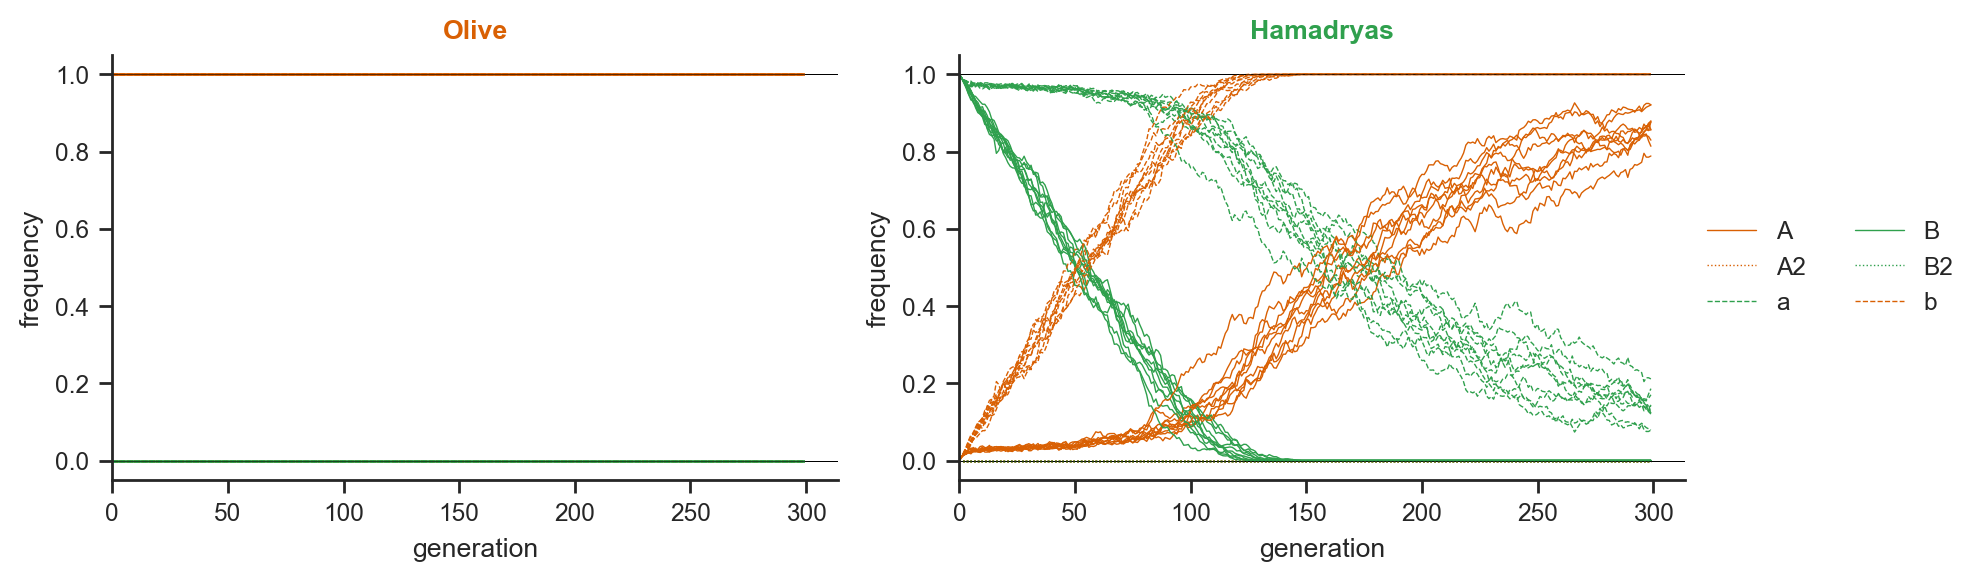

In [6]:
#| output: false

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
for i in range(10):
    twolocus_twoallele_plot(
        compute_twolocus_twoallele_sample_data(
            generations = 300,          # nr generations simulated
            N1 = 1000, N2 = 1000,       # size of populations
            M1 = 0, M2 = 10,            # migrants recieved in pop 1 and 2 in each generation
            init_pulse1 = 0.0,          # frequency of migrants in population 1 at generation 1
            init_pulse2 = 0.0,          # frequency of migrants in population 1 at generation 1
            A2_freq = 0, 
            B2_freq = 0,                # 
            AB_bdmi_s = -0.5,           # selection on genotypes with both A and B,
            ab_bdmi_s = -0,             # selection on genotypes with both A and B,
            A_s = 0, A2_s = 0, a_s = 0, # selection on individual variants locus 1 irrespective of background
            B_s = 0, B2_s = 0, b_s = 0, # selection on individual variants locus 2 irrespective of background
            AB_bdmi_dom = 0.5,          #
            A_dom = 0.5, B_dom = 0.5,   #
        ), axes=axes, pop1='Olive', pop2='Hamadryas', linewidth=0.5, # color1='red',  color2='blue'
        ) ;

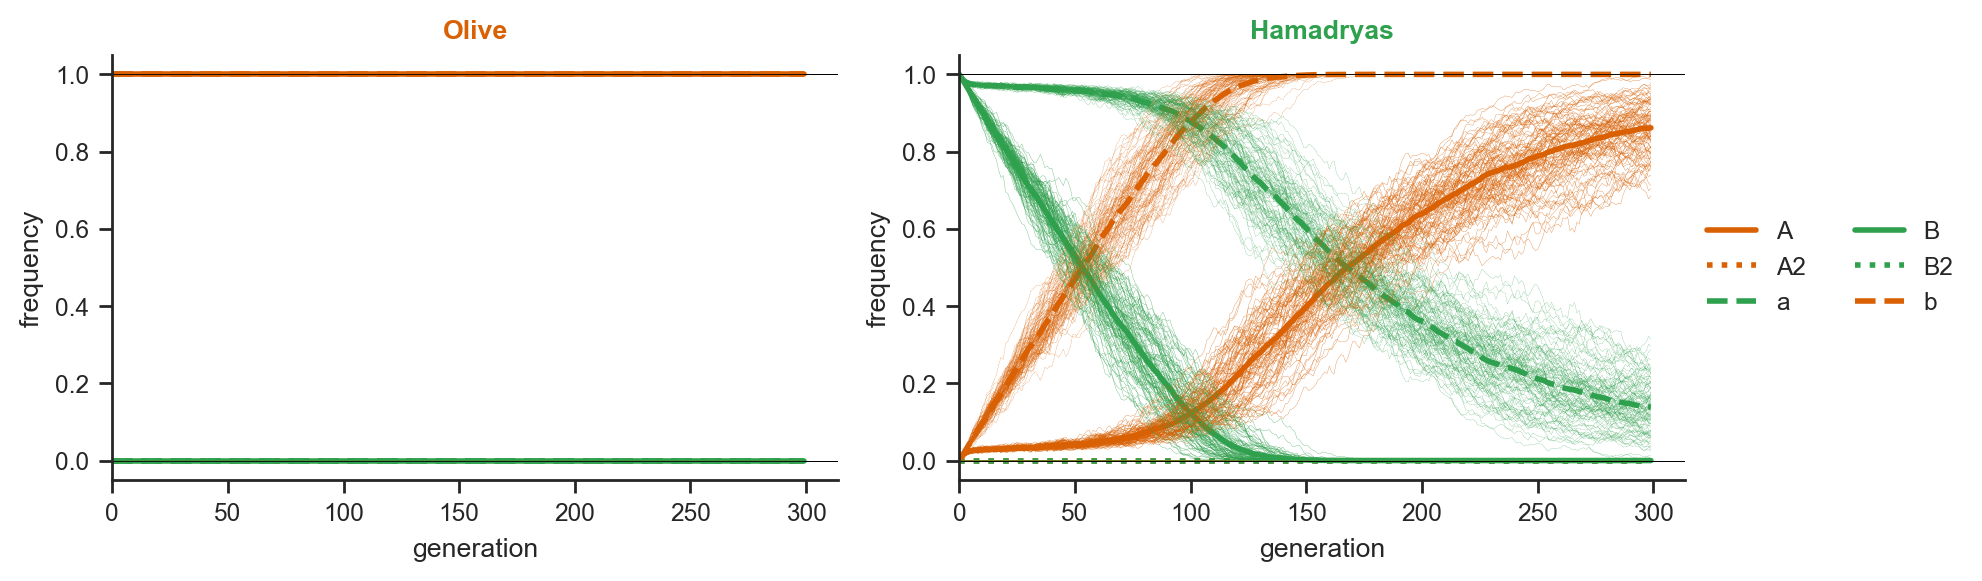

In [7]:
#| output: false

from functools import partial
fun = partial(compute_twolocus_twoallele_sample_data, generations = 300,                 # nr generations simulated
                                               N1 = 1000, N2 = 1000,               # size of populations
                                               M1 = 0, M2 = 10,                     # migrants recieved in pop 1 and 2 in each generation
                                               init_pulse1 = 0.0,       # frequency of migrants in population 1 at generation 1
                                               init_pulse2 = 0.0,          # frequency of migrants in population 1 at generation 1
                                               A2_freq = 0, 
                                               B2_freq = 0,           # 
                                               AB_bdmi_s = -0.5,                  # selection on genotypes with both A and B,
                                               ab_bdmi_s = -0,          # selection on genotypes with both A and B,
                                               A_s = 0, A2_s = 0, a_s = 0,           # selection on individual variants locus 1 irrespective of background
                                               B_s = 0, B2_s = 0, b_s = 0,             # selection on individual variants locus 2 irrespective of background
                                               AB_bdmi_dom = 0.5,                  #
                                               A_dom = 0.5, B_dom = 0.5,             #
                                              )

# interations, generations, populations, alleles (A, A2, a, B, B2, b):
tensor = np.stack([fun(iteration=1) for _ in range(100)])  

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

tensor_means = np.mean(tensor, axis=0)
twolocus_twoallele_plot(tensor_means, pop1='Olive', pop2='Hamadryas',
                linewidth=2, axes=axes) ;

for i in range(tensor.shape[0]):
    twolocus_twoallele_plot(tensor[i,:,:,:], pop1='Olive', pop2='Hamadryas',
                    linewidth=0.1, axes=axes)

In [8]:
def plot_scenario(samples, plot_all=False, **kwargs):
    
    
    # interations, generations, populations, alleles (A, A2, a, B, B2, b):
    # fun = partial(compute_twolocus_twoallele_sample_data, **kwargs)
    # tensor = np.stack([fun(iteration=1) for _ in range(samples)])  
    kwargs['iteration'] = 1
    fun = partial(compute_twolocus_twoallele_sample_data, **kwargs)
    tensor = np.stack(pool.map(fun, range(samples)))

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=stats.ConstantInputWarning)
        generations = list(range(tensor.shape[1]))
        
        A_spearman = [stats.spearmanr(tensor[:, g, 0, 0], tensor[:, g, 1, 0]).statistic for g in generations]
        B_spearman = [stats.spearmanr(tensor[:, g, 0, 3], tensor[:, g, 1, 3]).statistic for g in generations]

        A_pearson = [stats.pearsonr(tensor[:, g, 0, 0], tensor[:, g, 1, 0]).statistic for g in generations]
        B_pearson = [stats.pearsonr(tensor[:, g, 0, 3], tensor[:, g, 1, 3]).statistic for g in generations]
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, height_ratios=[2,2])

    color1 = '#D96003'
    color2 = '#2FA04D'
    
    tensor_means = np.mean(tensor, axis=0)
    twolocus_twoallele_plot(tensor_means, #color1=color1, color2=color2, #pop1='Olive', pop2='Hamadryas',
                    linewidth=2, axes=axes[0, :], xlabel=None) ;

    if plot_all:
        for i in range(tensor.shape[0]):
            twolocus_twoallele_plot(tensor[i,:,:,:], #color1=color1, color2=color2, #pop1='Olive', pop2='Hamadryas',
                            linewidth=0.1, axes=axes[0, :], xlabel=None, alpha=1/np.log2(samples))


    if 'startmix' in kwargs:
        axes[0, 0].axhline(y=1-kwargs['startmix'], linewidth=2, linestyle='dotted', color='gray')
        axes[0, 0].axhline(y=kwargs['startmix'], linewidth=2, linestyle='dotted', color='gray')
        axes[0, 1].axhline(y=1-kwargs['startmix'], linewidth=2, linestyle='dotted', color='gray')
        axes[0, 1].axhline(y=kwargs['startmix'], linewidth=2, linestyle='dotted', color='gray')

    axes[1, 0].plot(generations, A_spearman, label='spearman', linewidth=2, color=color1)
    axes[1, 0].plot(generations, B_spearman, label='spearman', linewidth=2, color=color2)
    axes[1, 0].set_ylabel('coeficient')    
    axes[1, 0].set_ylim(-1, 1)    
    axes[1, 0].set_xlabel('generation')    
    axes[1, 0].set_title("Spearman cor of derived freq in pop1 and pop2" , fontweight='bold')
    axes[1, 0].axhline(y=0, linewidth=0.2, color='black')

    axes[1, 1].plot(generations, A_pearson, label='pearson', linewidth=2, color=color1)
    axes[1, 1].plot(generations, B_pearson, label='pearson', linewidth=2, color=color2)
    axes[1, 1].set_ylabel('coeficient')    
    axes[1, 1].set_ylim(-1, 1)    
    axes[1, 1].set_xlabel('generation')    
    axes[1, 1].set_title("Pearson cor of derived freq in pop1 and pop2" , fontweight='bold')
    axes[1, 1].axhline(y=0, linewidth=0.2, color='black')

#    axes[1, 0].set_ylabel('spearman')
    # axes[1, 1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()

# Model

## Two loci with two alleles

- Standard BDMI case with incompatible derived alleles A and B

```
       Population 1                   Population 2
       
          1   2                          1   2
        --A---b--                      --a---B--    
        --A---b--                      --a---B--   
                          
    A fixed, b fixed                a fixed, B fixed
```

## Two loci with three alleles

- Variant including A2 and B2. 
- A2 can represent another derived allele originatig in population 1
- A2 can also be made to represent the ancestral a-allele in population 1 (if you sum simulated a and A2 frequences.
- Same applies to B2

```
          1   2                          1   2
        --A---b--                      --a---B--    
        --A2--b--                      --a---B2-   
                          
A, A2 segregating, b fixed     a fixed, B, B2 segregating
```

---

## Population parameters

- `generations = 1000`: Number of generations simulated.
- `N1 = 30000`: Size of population 1.
- `N2 = 30000`: Size of population 2.
- `M1 = 0`: Migrants recieved in population 1 in each generation.
- `M2 = 0`: Migrants recieved in population 2 in each generation.
- `init_pulse1 = 0`: Initial migrant frequency in population 1.
- `init_pulse2 = 0`: Initial migrant frequency in population 2.
- `A2_freq = 0`: Frequency of A2 allele (0 imples an A frequency of 1).
- `B2_freq = 0`: Frequency of B2 allele (0 imples an B frequency of 1).

---

## Selection and dominance parameters
    
- `AB_bdmi_s = 0`: Selection on genotypes with both A and B,
- `ab_bdmi_s = 0`: Selection on genotypes with both A and B,
- `A_s = 0`: Independent selection on A.
- `A2_s = 0`: Independent selection on A2.
- `a_s = 0`: Independent selection on a.           
- `B_s = 0`: Independent selection on B.
- `B2_s = 0`: Independent selection on B2.
- `b_s = 0`: Independent selection on b.
- `AB_bdmi_dom = 0.5`: Dominance of AB haplotype.
- `A_dom = 0.5`: Dominance of A allele.
- `B_dom = 0.5`: Dominance of B allele.

---

In [9]:
# #| output: false

# twolocus_twoallele_plot(
#     compute_twolocus_twoallele_sample_data(
#             generations = 300,          # nr generations simulated
#             N1 = 30000, N2 = 30000,     # size of populations
#             M1 = 0, M2 = 300,           # migrants recieved in pop 1 and 2 in each generation
#             init_pulse1 = 0.1,          # frequency of migrants in population 1 at generation 1
#             init_pulse2 = 0.3,          # frequency of migrants in population 1 at generation 1
#             A2_freq = 0.1, 
#             B2_freq = 0.1,              # 
#             AB_bdmi_s = -0.1,           # selection on genotypes with both A and B,
#             ab_bdmi_s = -0.05,          # selection on genotypes with both A and B,
#             A_s = 0, A2_s = 0, a_s = 0, # selection on individual variants locus 1 irrespective of background
#             B_s = 0, B2_s = 0, b_s = 0, # selection on individual variants locus 2 irrespective of background
#             AB_bdmi_dom = 0.5,          #
#             A_dom = 0.5, B_dom = 0.5,   #
#             ),
#     ) ;

---

# Reproducing Schumer 2018 plot

---

## Schumer et al. 2028 Fig. S6

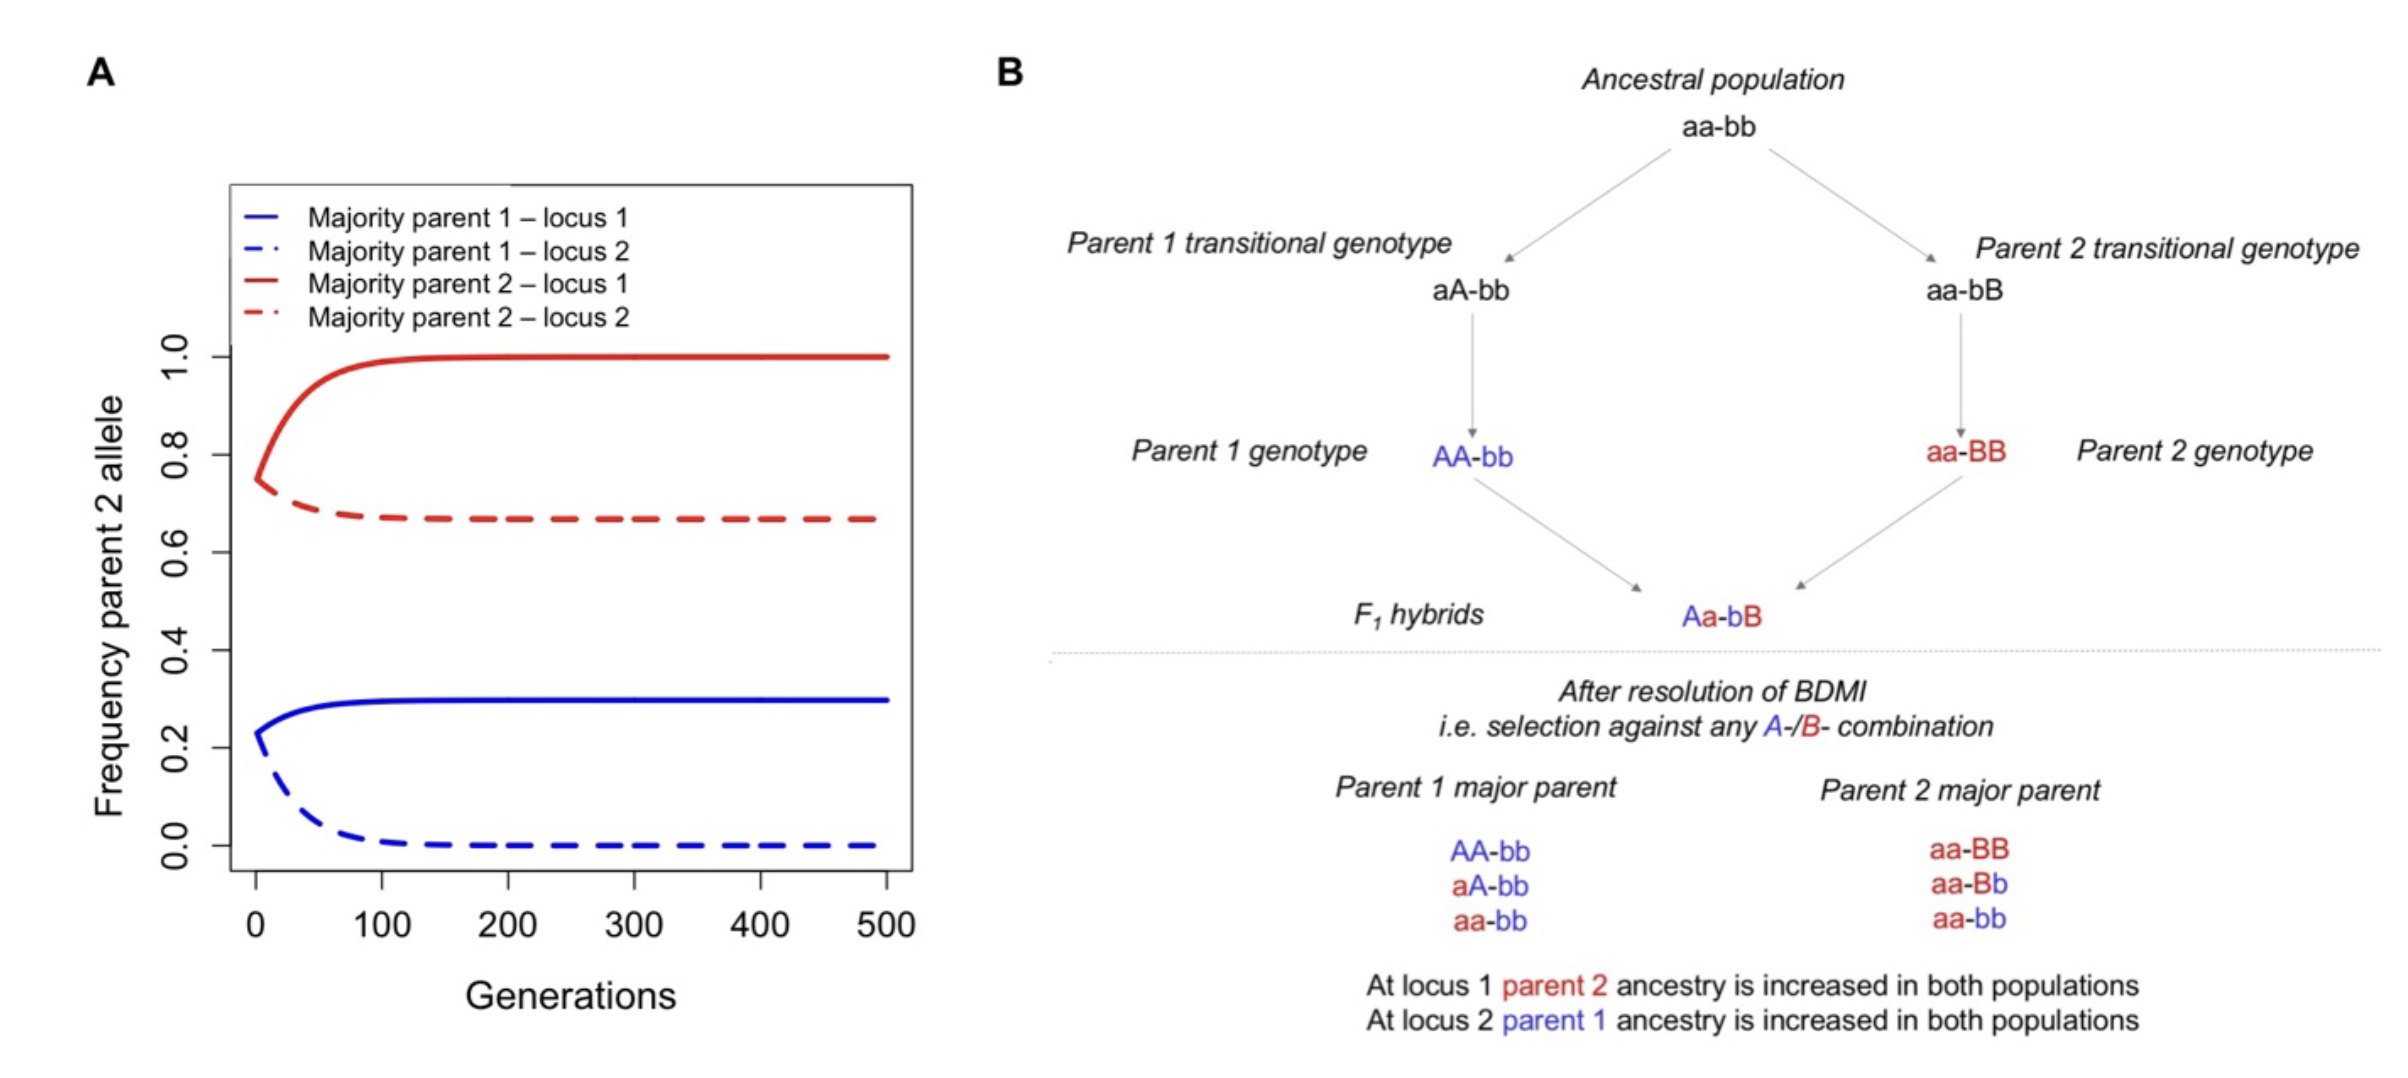

The b alleles, not incompatible with anything, somewhat displace the A alleles while the incompatible B alleles segregate.

---

## Shumer supplementary 

- Instant mixing (`startmix`) of populations with no subsequent migration
- It is assumed that there is no positive selection on A and B. I.e. the BDMI has developed neutrally.
  

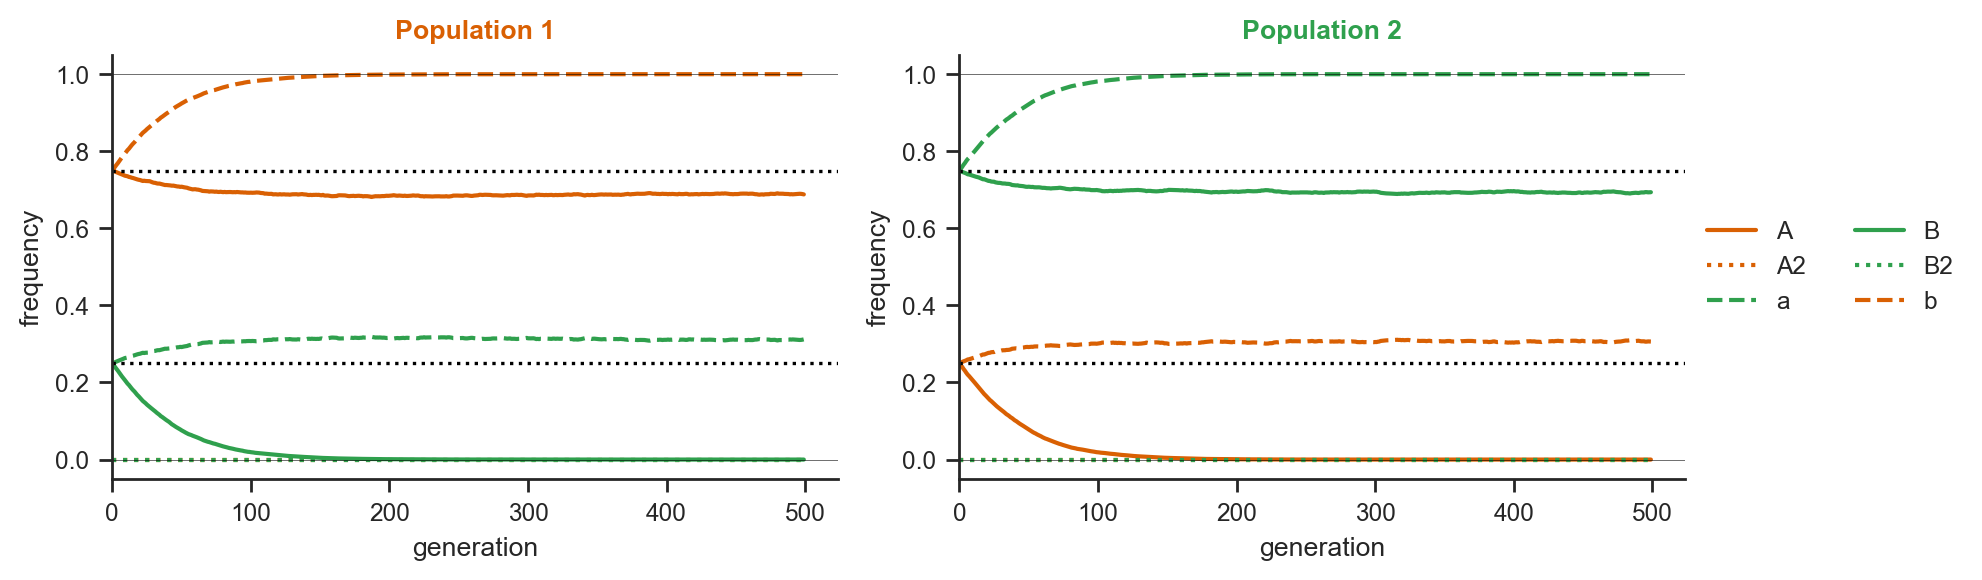

In [10]:
startmix = 0.25
data = compute_twolocus_twoallele_sample_data(N1=500000, N2=500000, M1=0, M2=0, 
                                              generations=500, 
                                              startmix=startmix, 
                                              AB_bdmi_s=-0.05)
ax1, ax2 = twolocus_twoallele_plot(data) 
ax1.axhline(y=1-startmix, linestyle='dotted', color='black')
ax1.axhline(y=startmix, linestyle='dotted', color='black')
ax2.axhline(y=1-startmix, linestyle='dotted', color='black')
ax2.axhline(y=startmix, linestyle='dotted', color='black') ;

---

# Between-population correlation of A and B frequency across many loci

In [55]:
#| echo: true
samples = 1000
s = -0.01

---

## All loci with same AB_bdmi_s

CPU times: user 8min 15s, sys: 2.01 s, total: 8min 17s
Wall time: 3min 4s


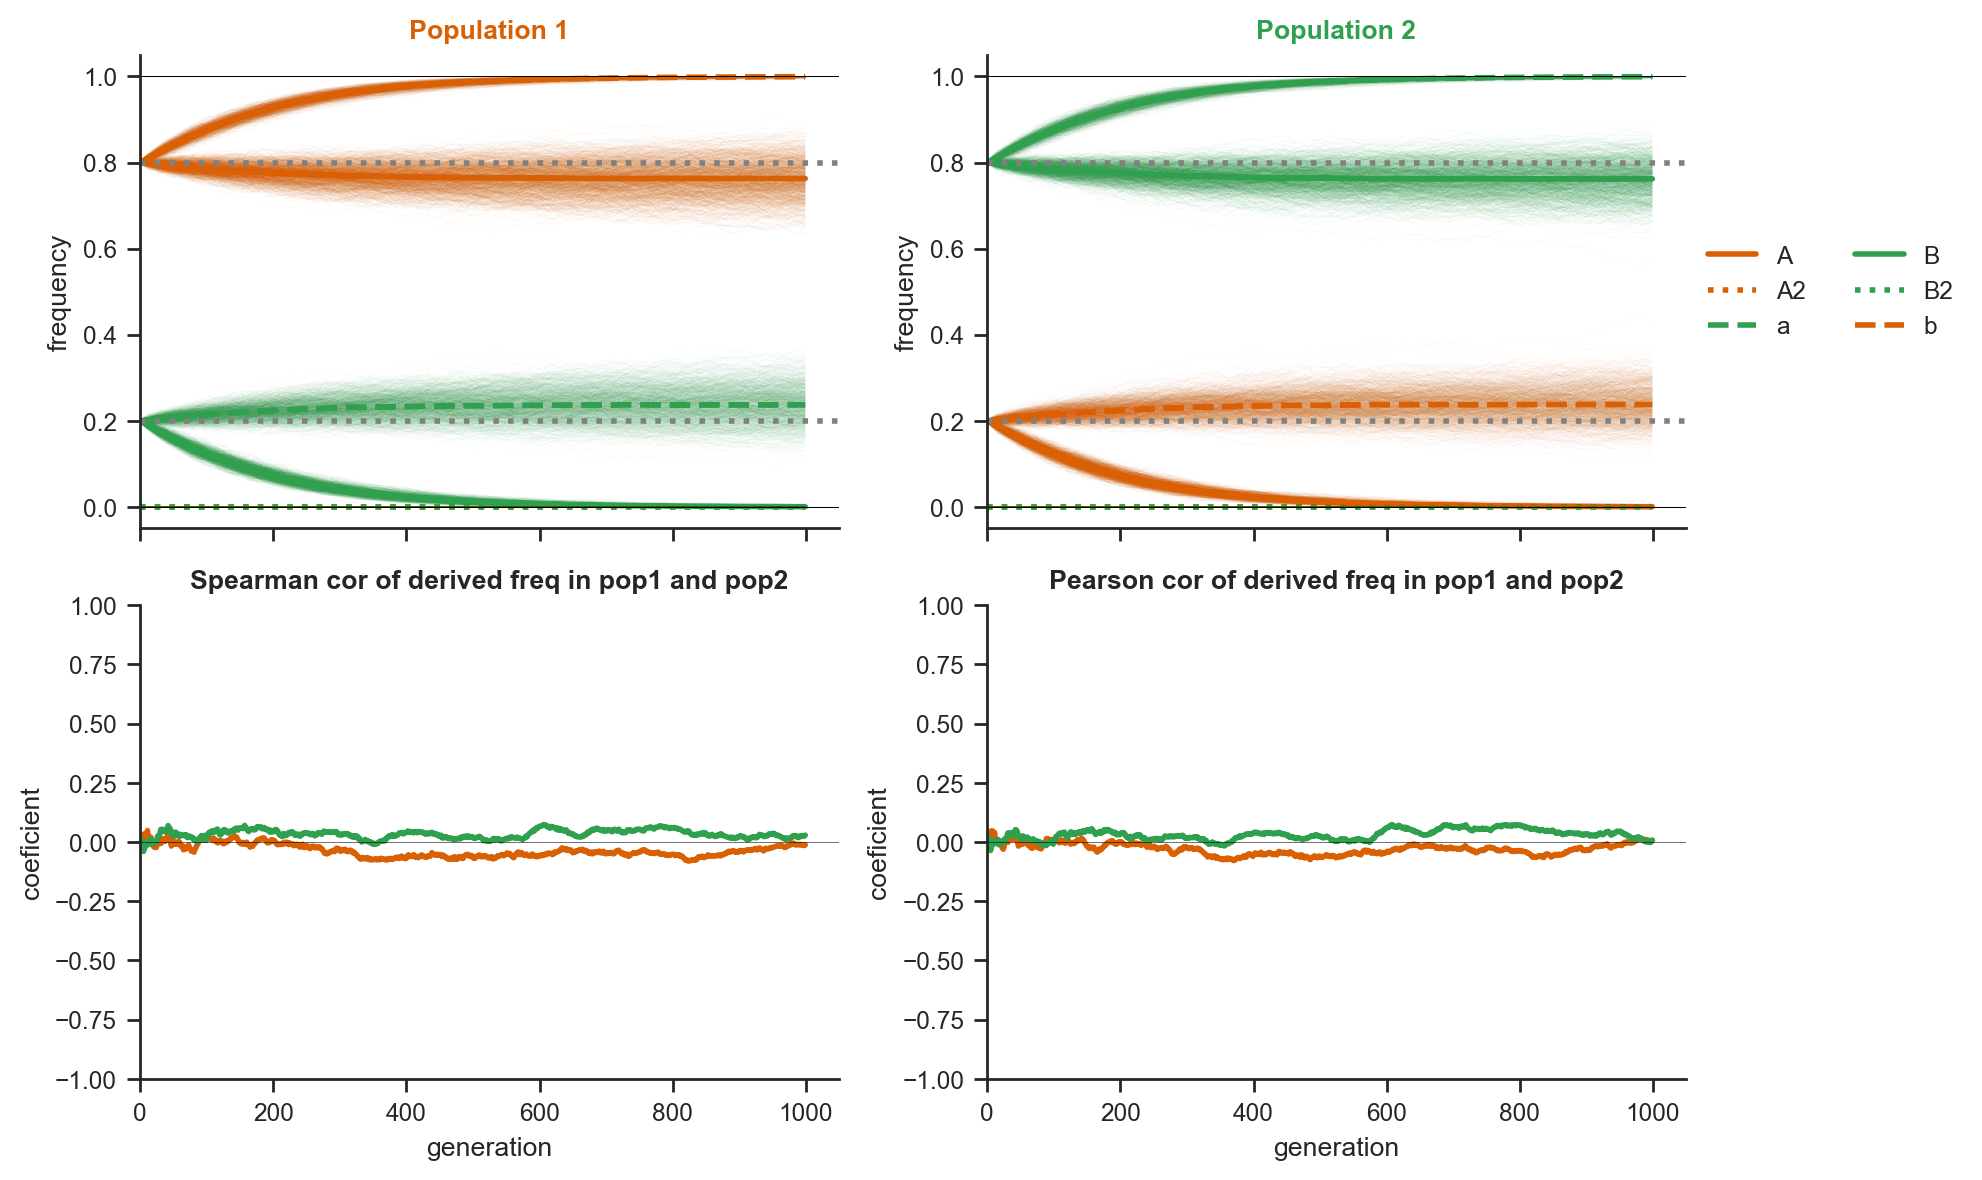

In [56]:
%%time
#| echo: true
plot_scenario(samples, plot_all=True, startmix=0.2, AB_bdmi_s=s)

---

## Gamma distributed s: `gam_s`

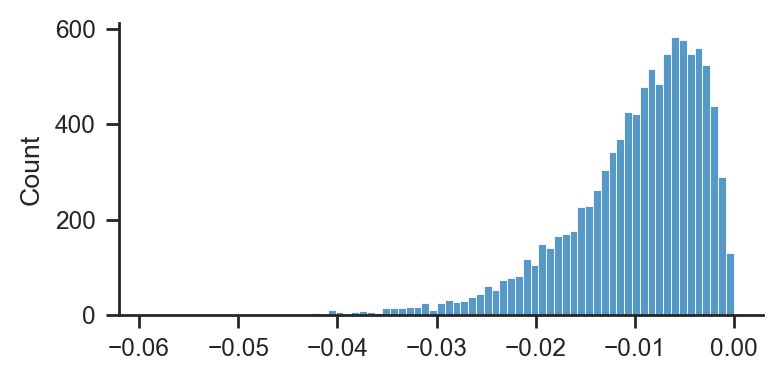

In [57]:
#| echo: false
#| label: fig-gamma
#| fig-cap: "Gamma distributed s"

def gam_s():
    s = 0.01
    return -gamma(2, np.abs(s) / 2, 1)[0]

sns.displot([gam_s() for _ in range(10000)], height=2, aspect=2) ;

In [58]:
#| echo: false
#| label: doc-gamma

Markdown(f"""
         
Allows s to be gamma distributed...

""")


         
Allows s to be gamma distributed...



---

## Interspersed non-zero s: `inter_s`

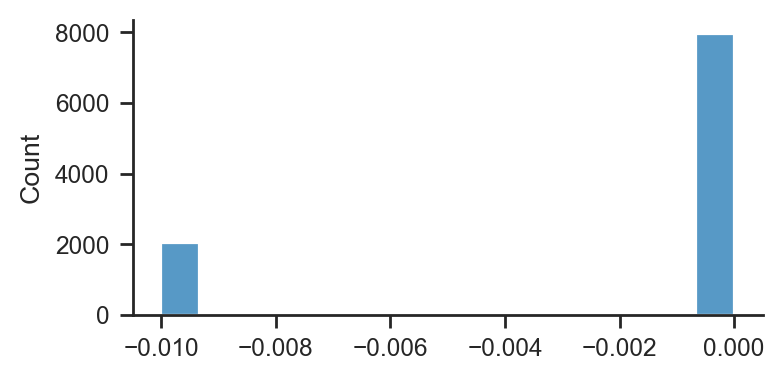

In [59]:
#| echo: false
#| label: fig-interspersed
#| fig-cap: "This is a figure caption"

def inter_s():
    s = -0.01
    return s * np.random.choice([0, 1], p=(0.8, 0.2))

sns.displot([inter_s() for _ in range(10000)], height=2, aspect=2) ;

---

## "Almost fixed" A and B

E.g. including only sites fixed in a large sample.

Hack: beta dist A2_freq and B2_freq:

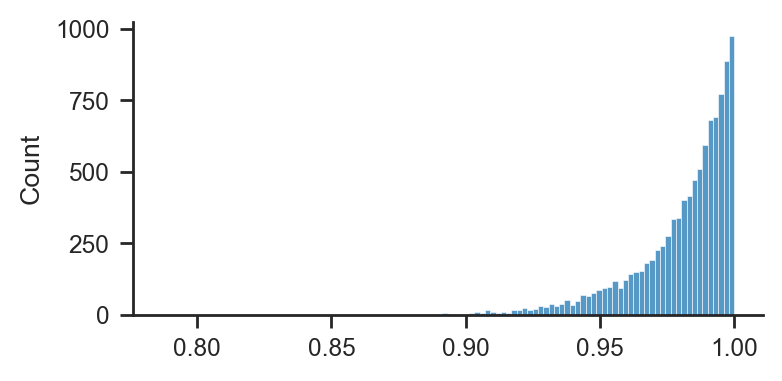

In [60]:
def bfr():
    return beta(1, 50)

sns.displot([1-bfr() for _ in range(10000)], height=2, aspect=2) ;

---

# Initial pulse only

---

## Adding gamma distributed s

### No BDMI

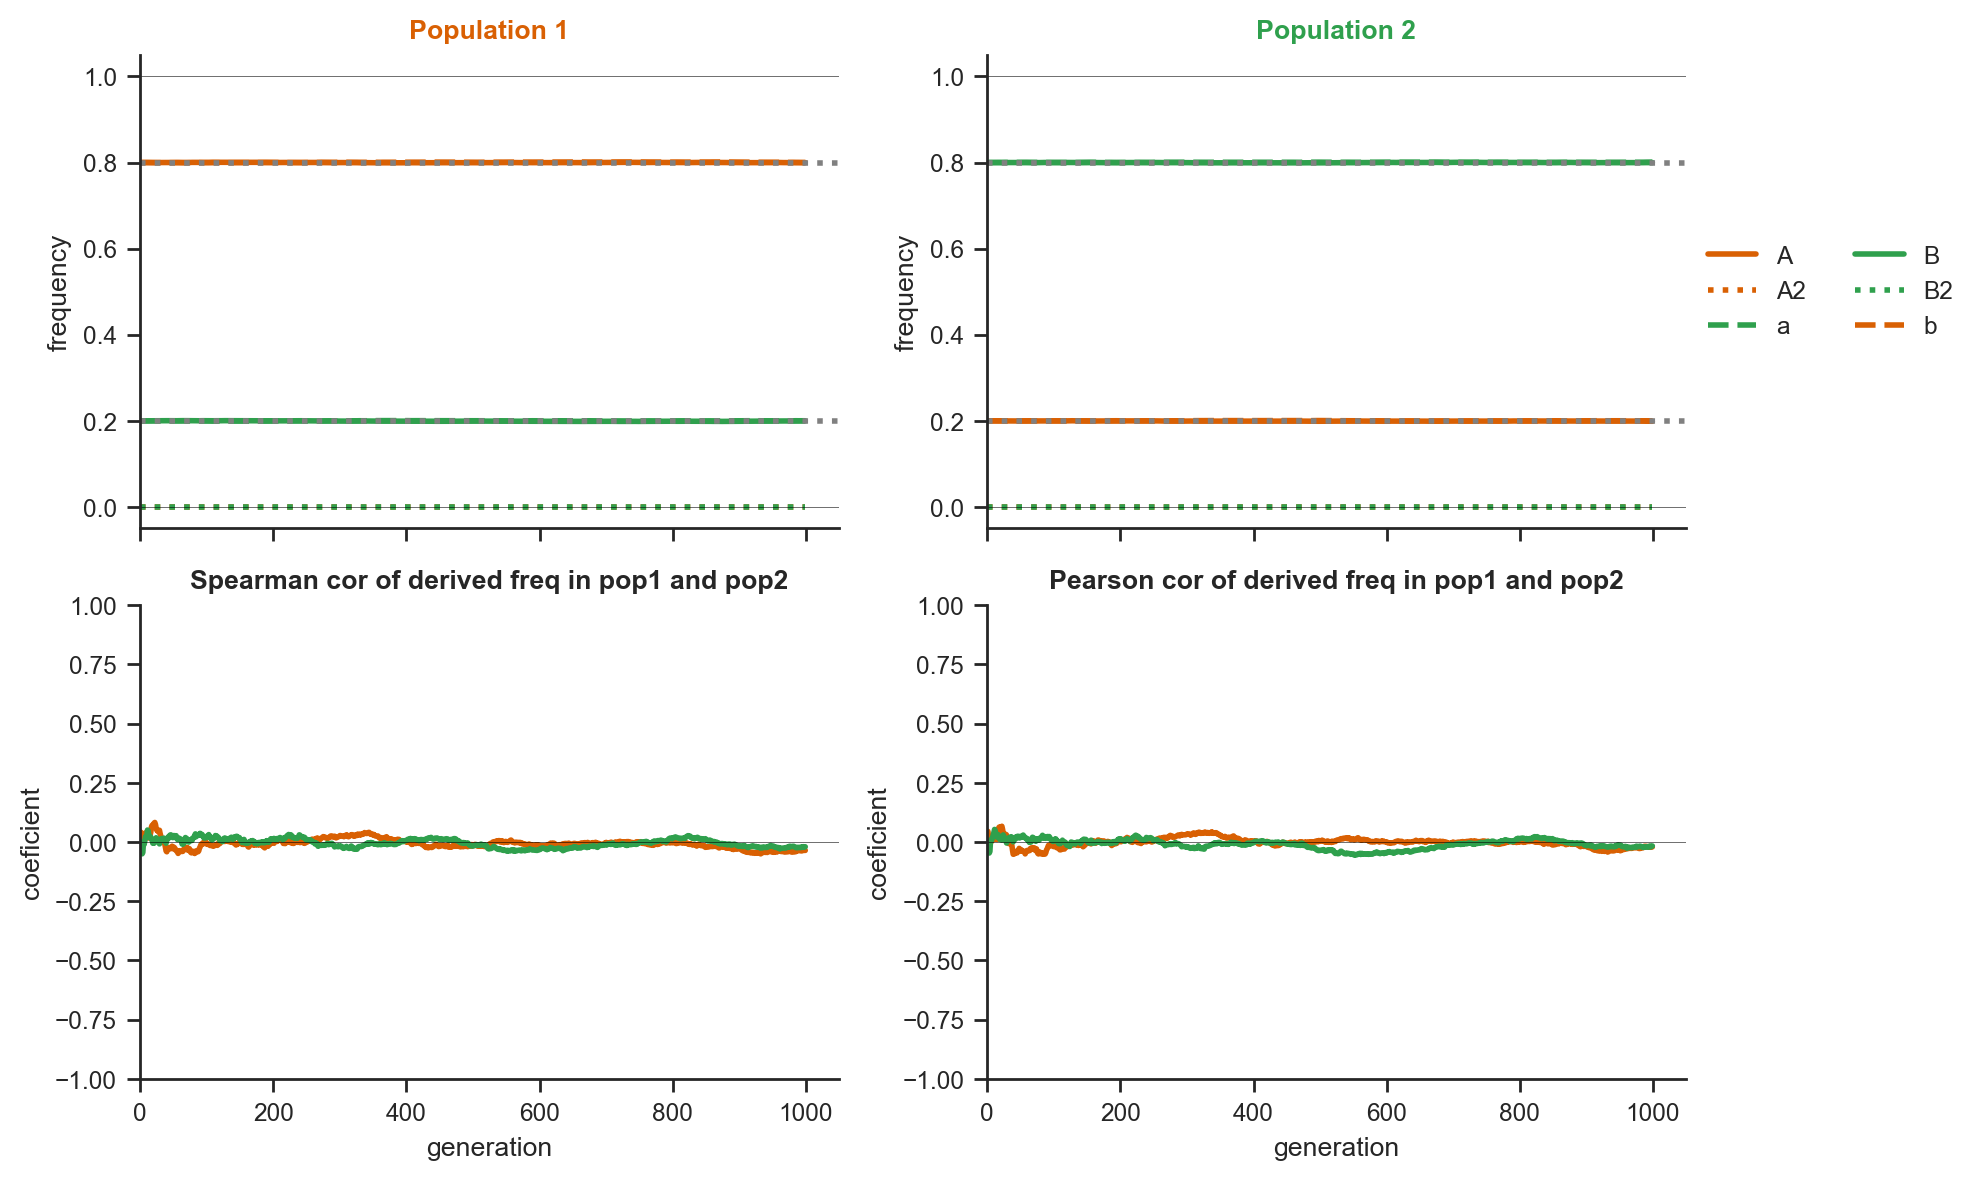

In [62]:
#| echo: true
plot_scenario(samples, startmix=0.2, AB_bdmi_s=0)

---

## Adding gamma distributed s

### BDMI

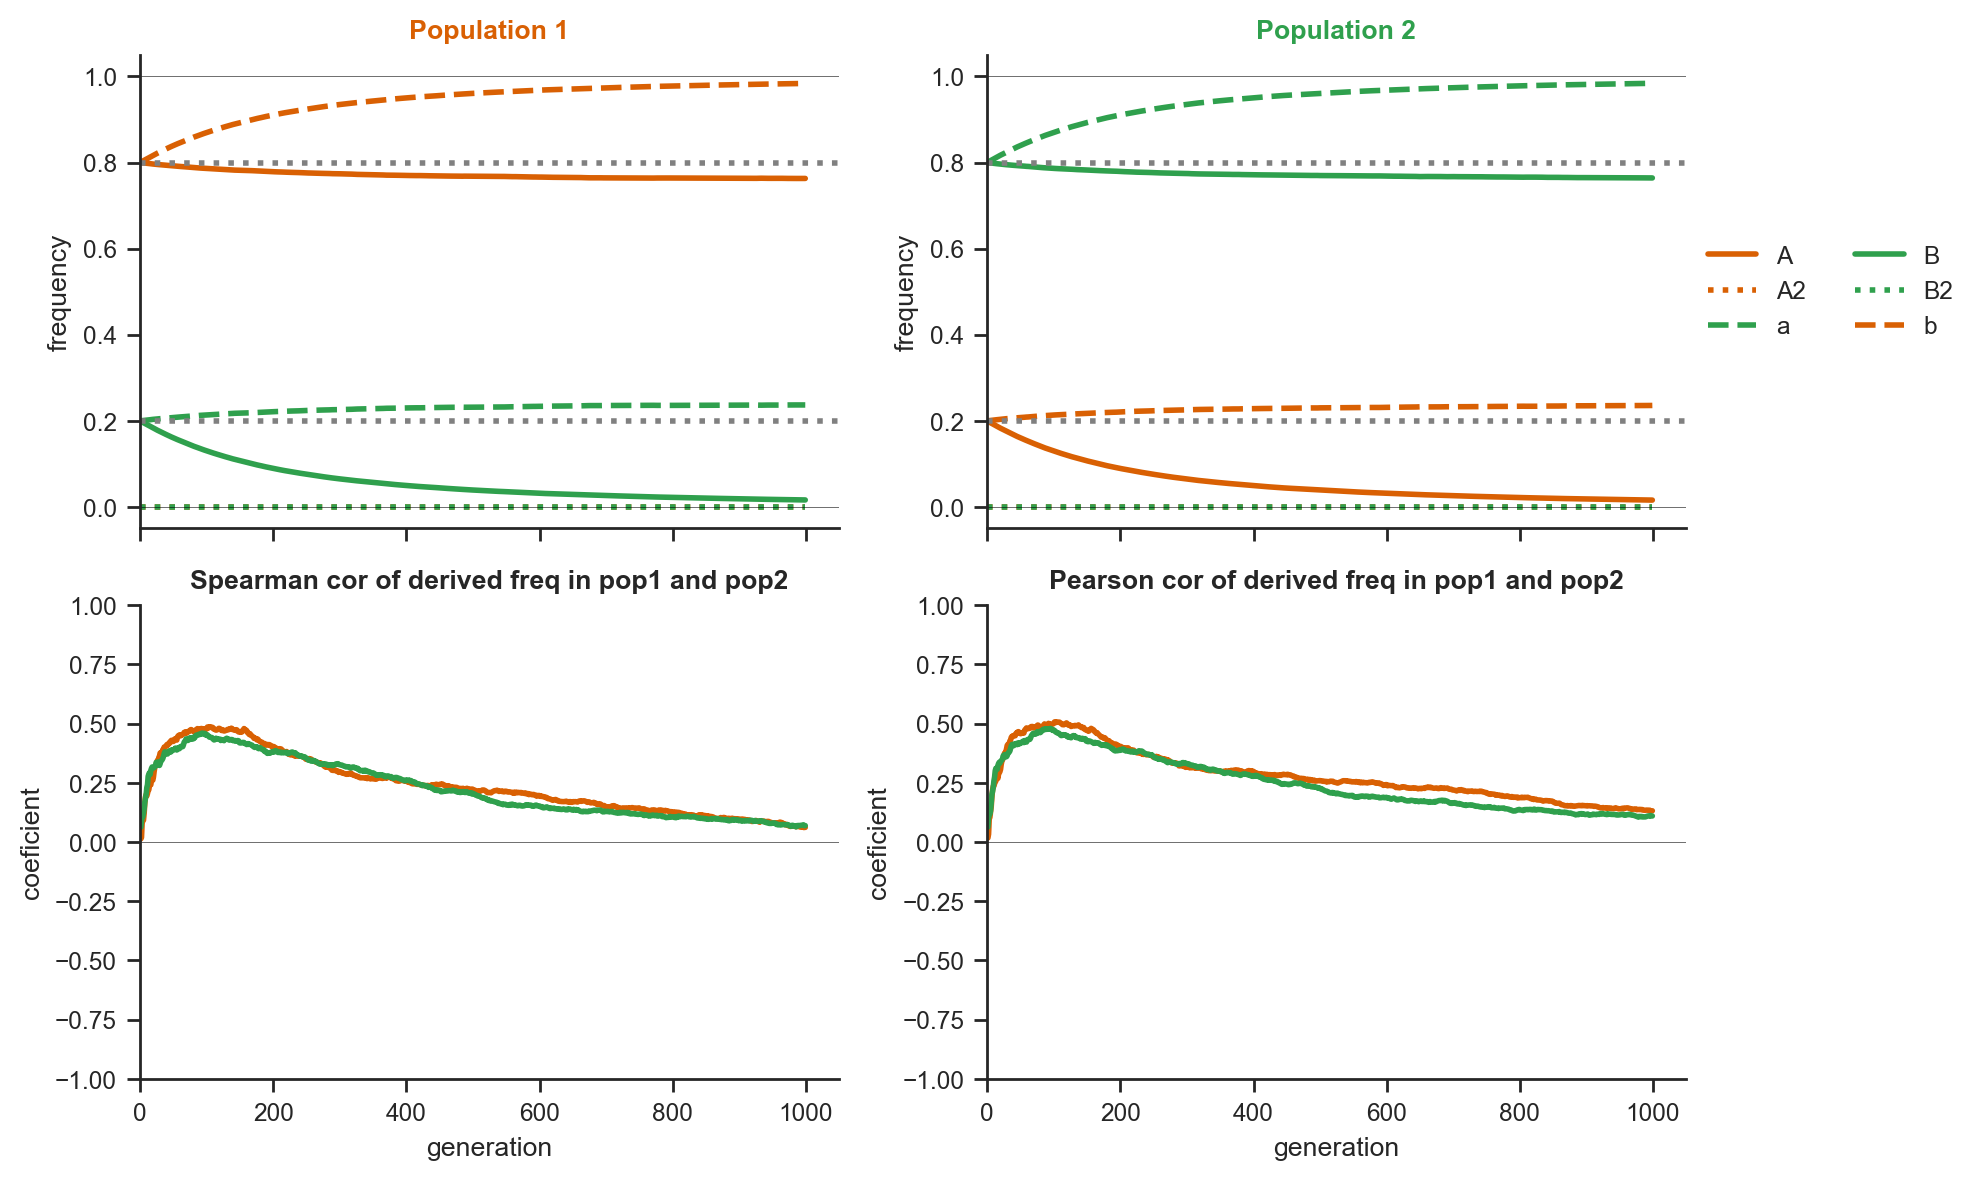

In [61]:
#| echo: true
plot_scenario(samples, startmix=0.2, AB_bdmi_s=gam_s)

---

## Adding interspersed bdmi

### No BDMI

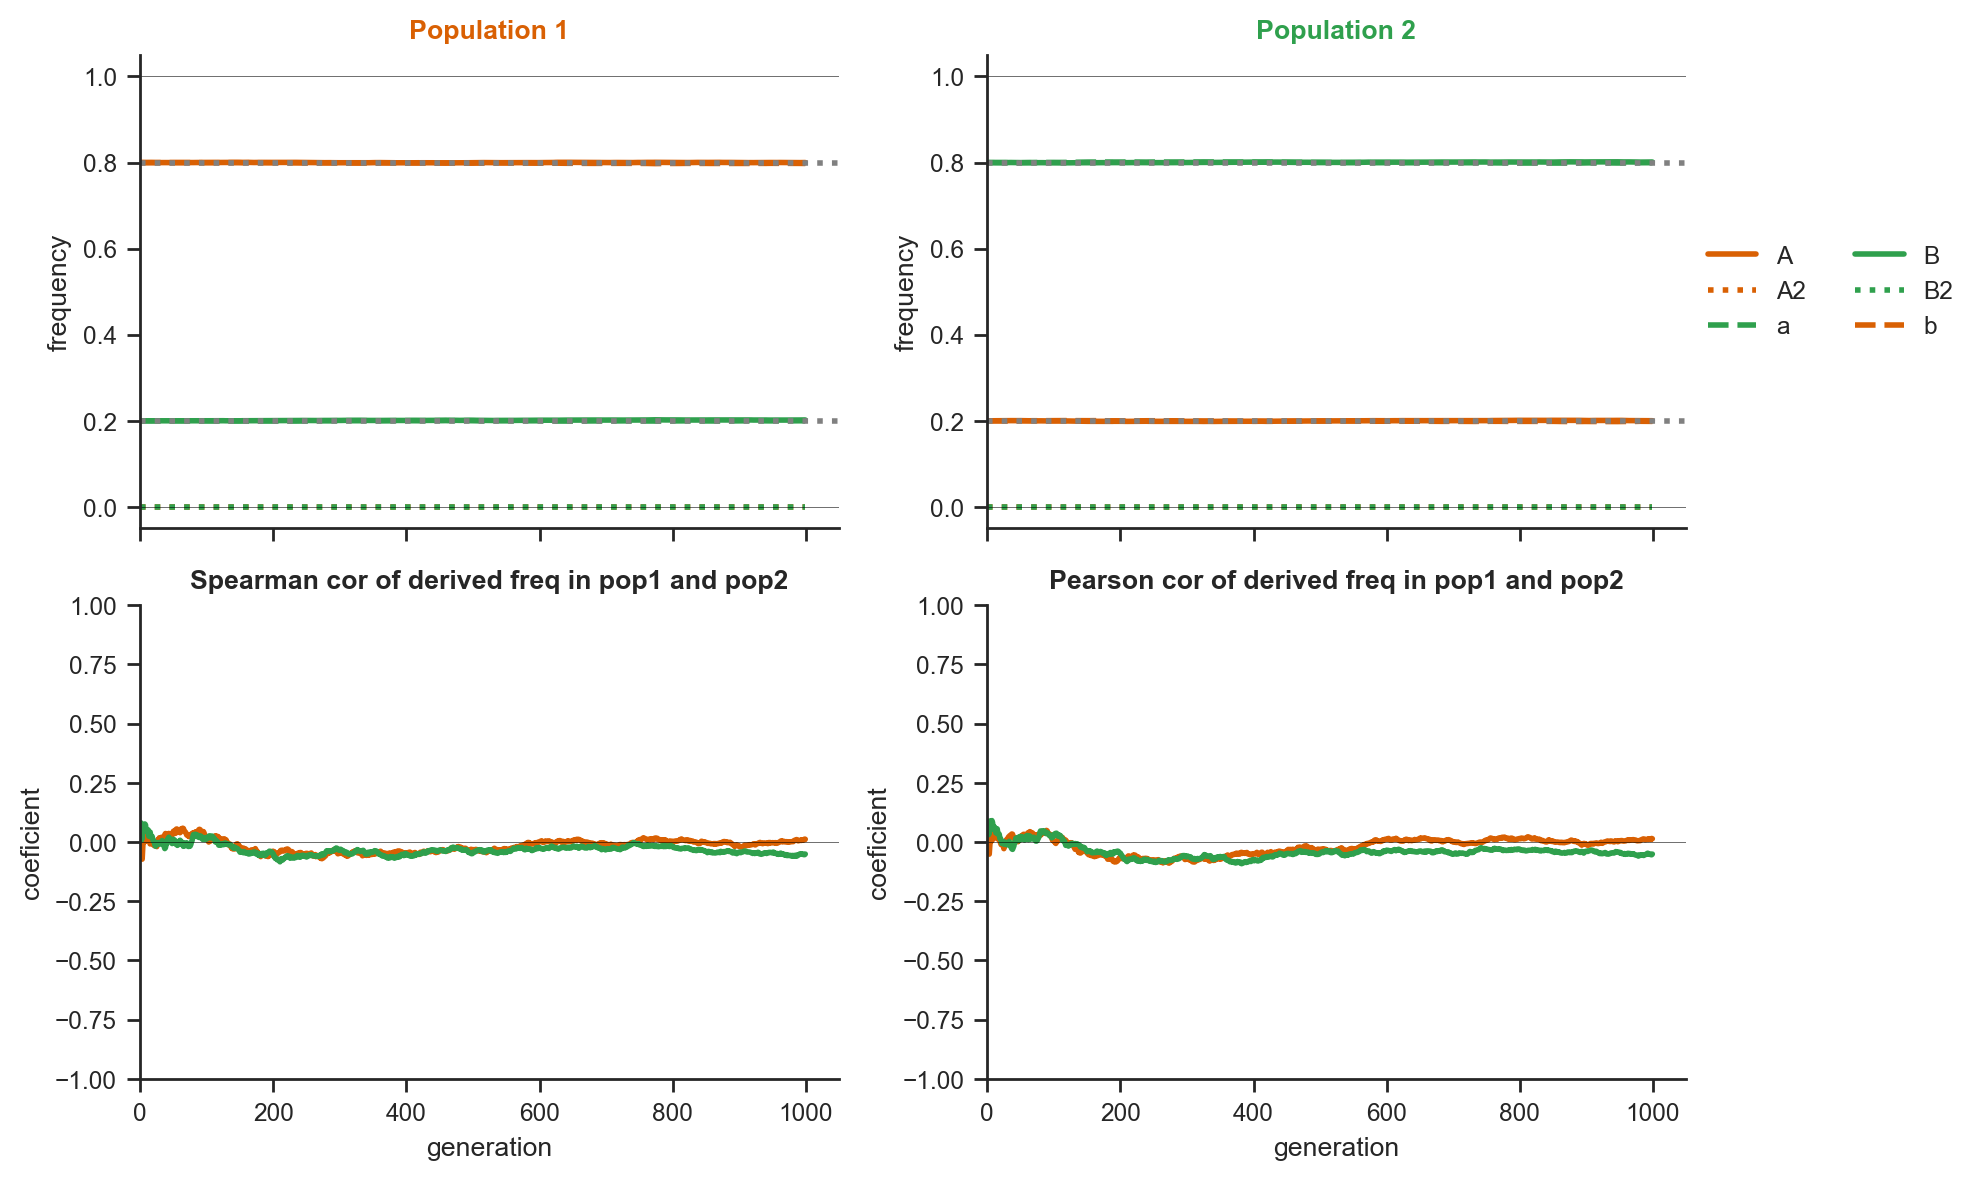

In [63]:
#| echo: true
plot_scenario(samples, startmix=0.2, AB_bdmi_s=0)

---

## Adding interspersed bdmi

### BDMI

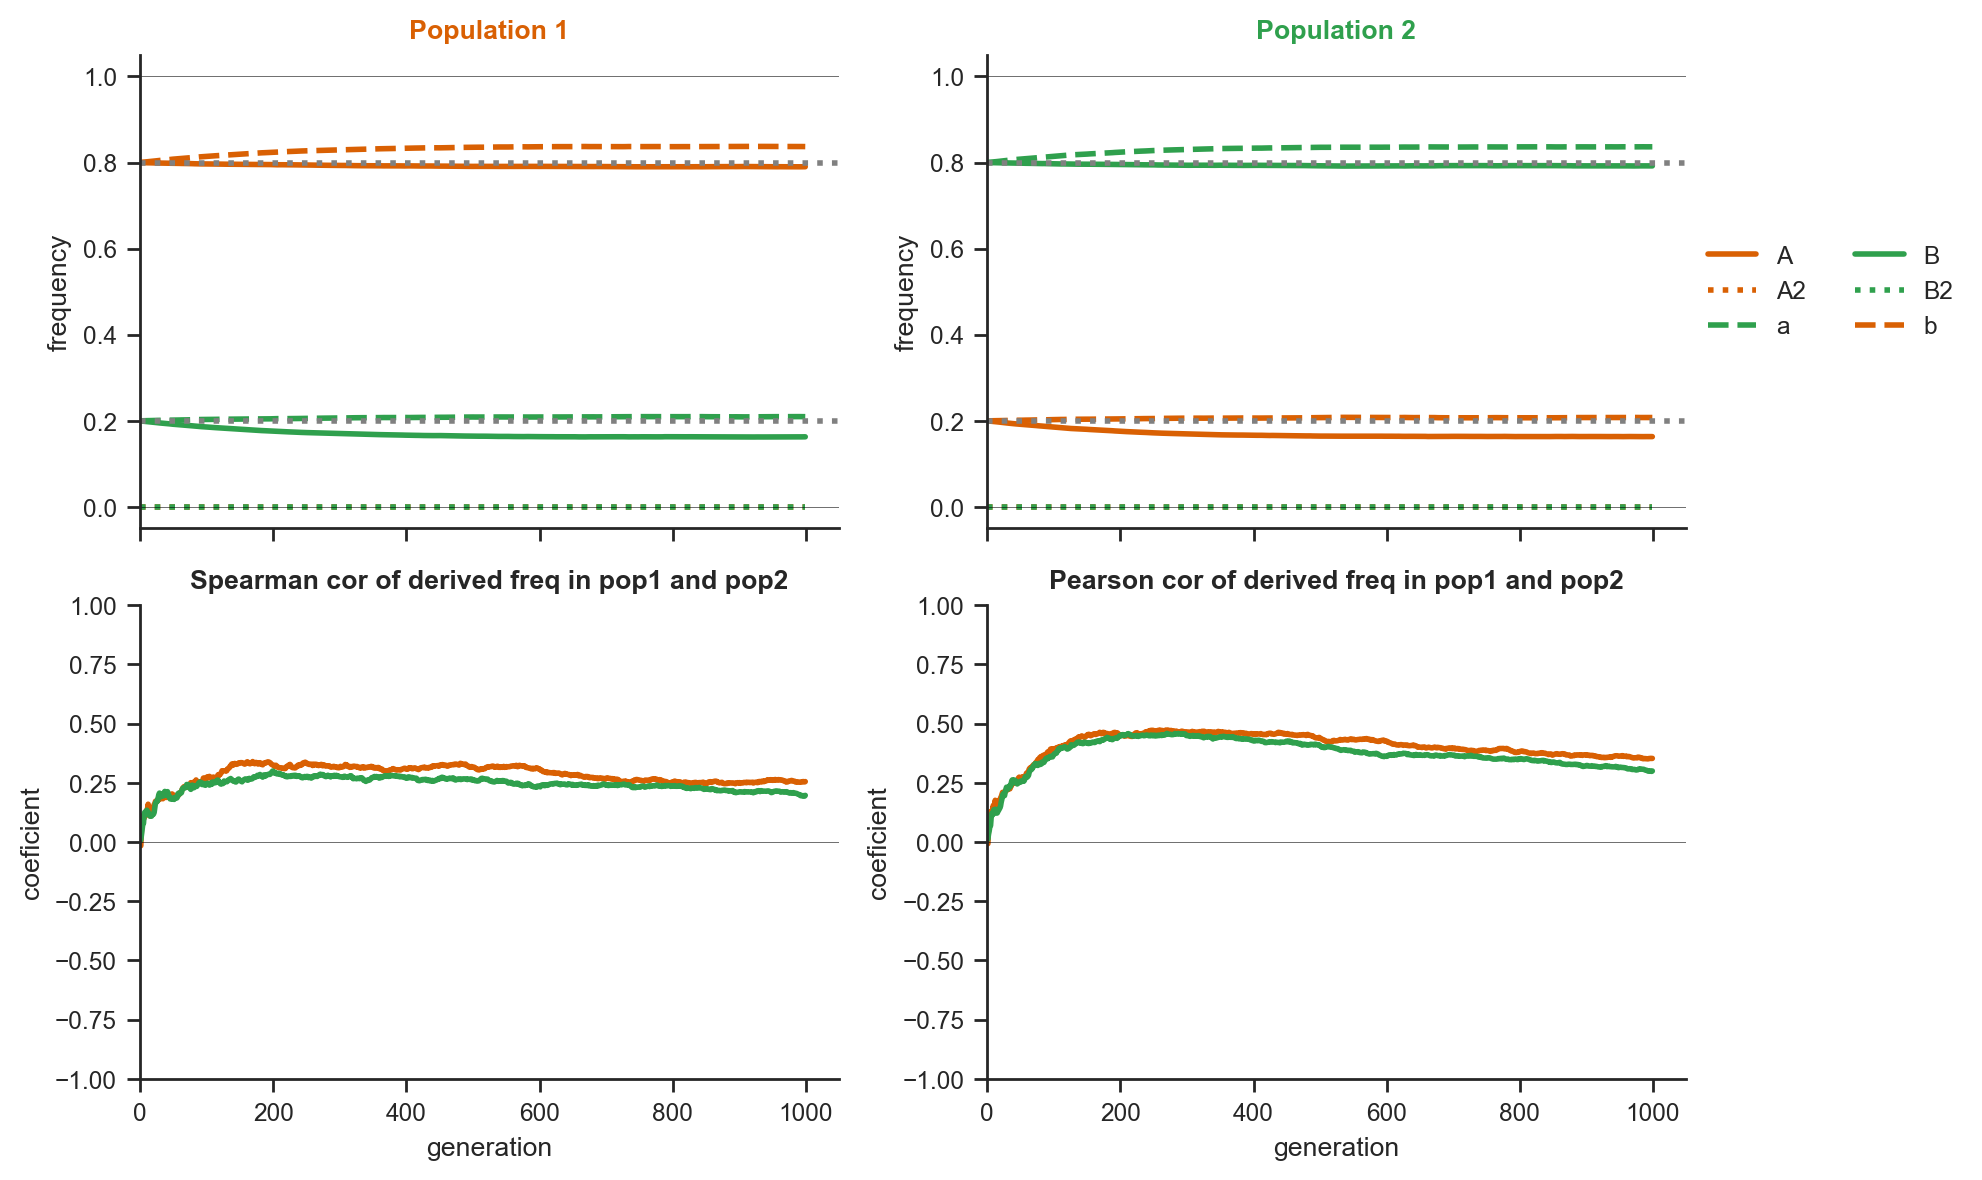

In [64]:
#| echo: true
plot_scenario(samples, startmix=0.2, AB_bdmi_s=inter_s)

---

## Adding "almost fixed" A and B

### No BDMI

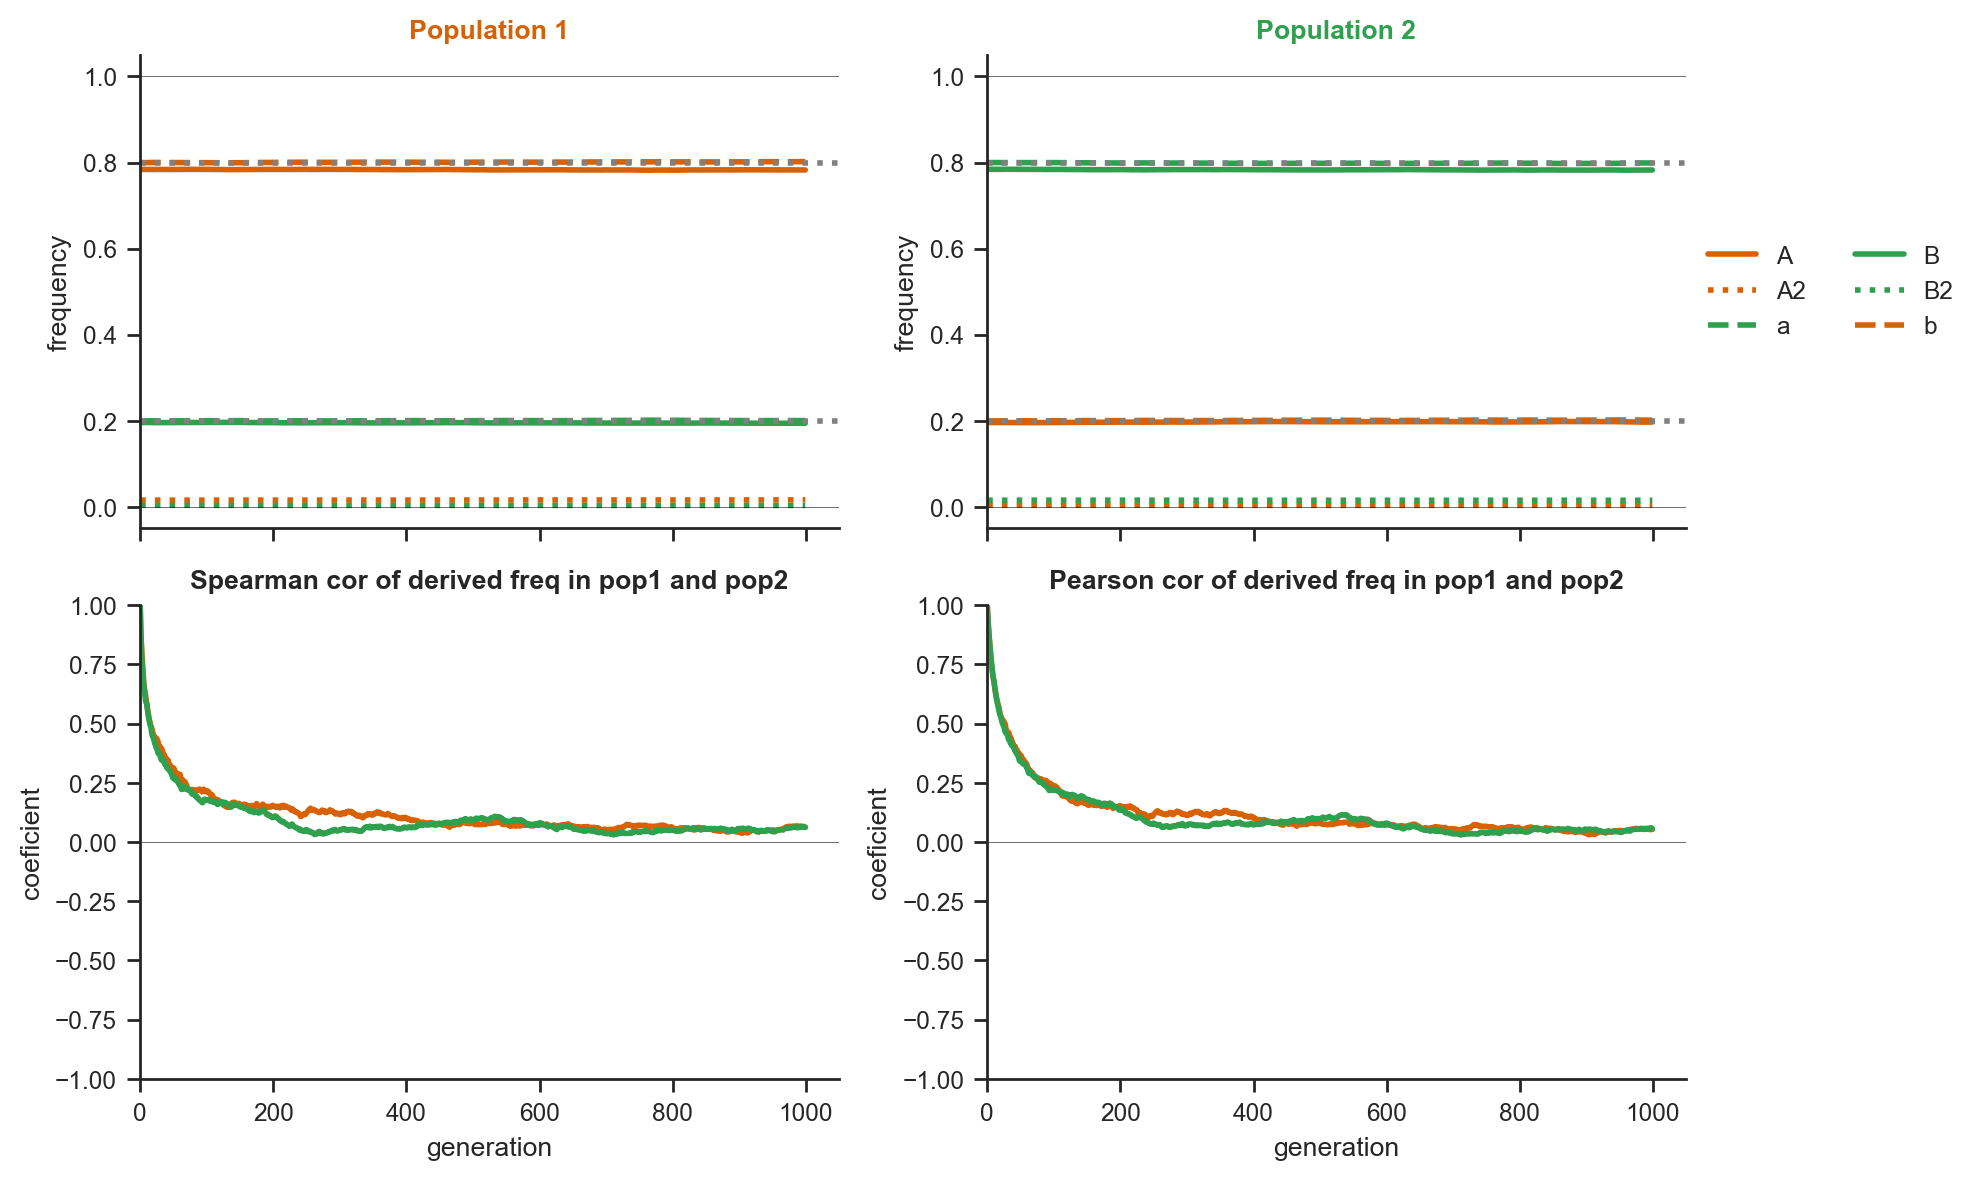

In [65]:
#| echo: true
plot_scenario(samples, startmix=0.2, AB_bdmi_s=0, A2_freq=bfr, B2_freq=bfr)

---

## Adding "almost fixed" A and B

### BDMI

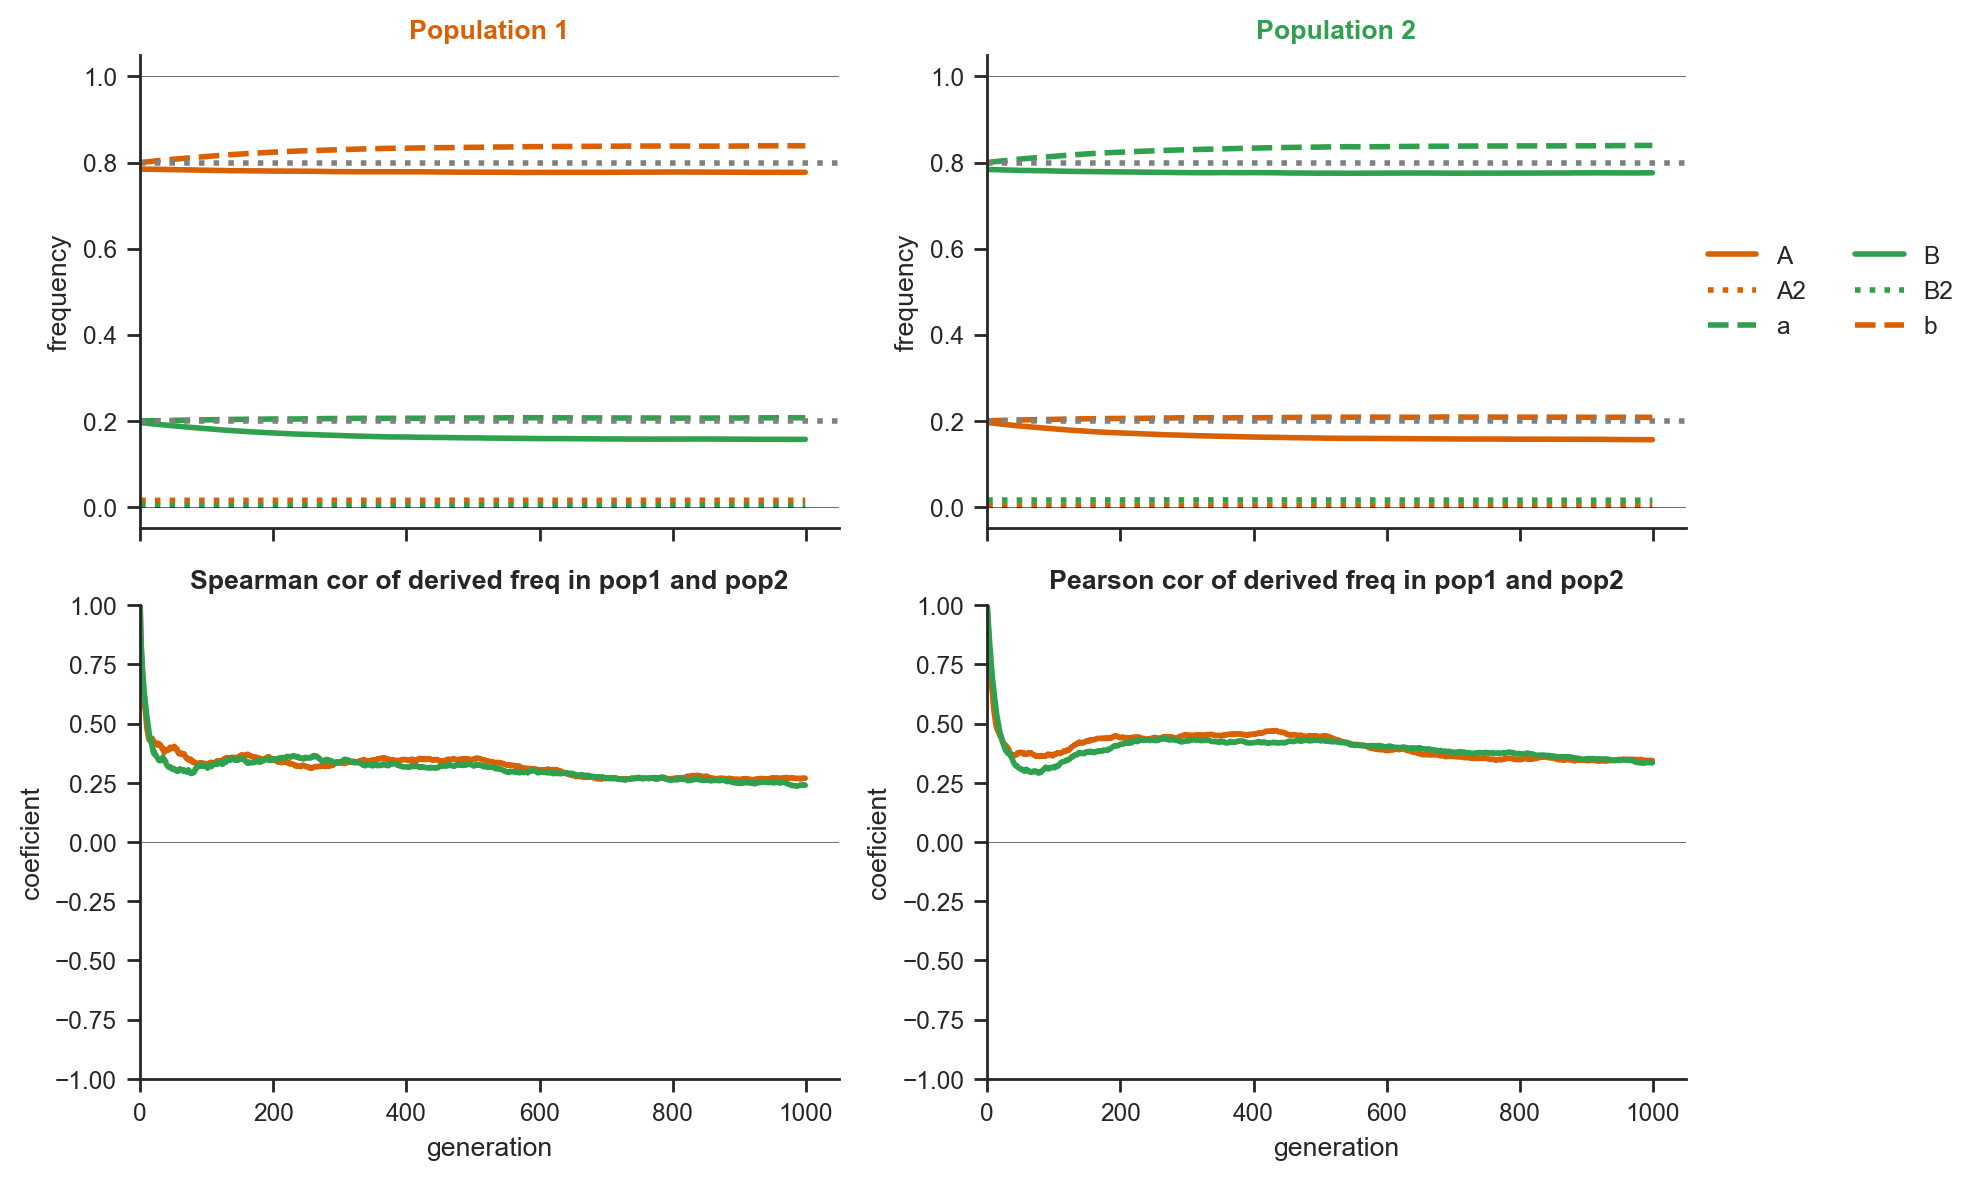

In [66]:
#| echo: true
plot_scenario(samples, startmix=0.2, AB_bdmi_s=inter_s, A2_freq=bfr, B2_freq=bfr)

---

# Protracted initial pulse

---

## Strong migration in first 100 generations

### No BDMI

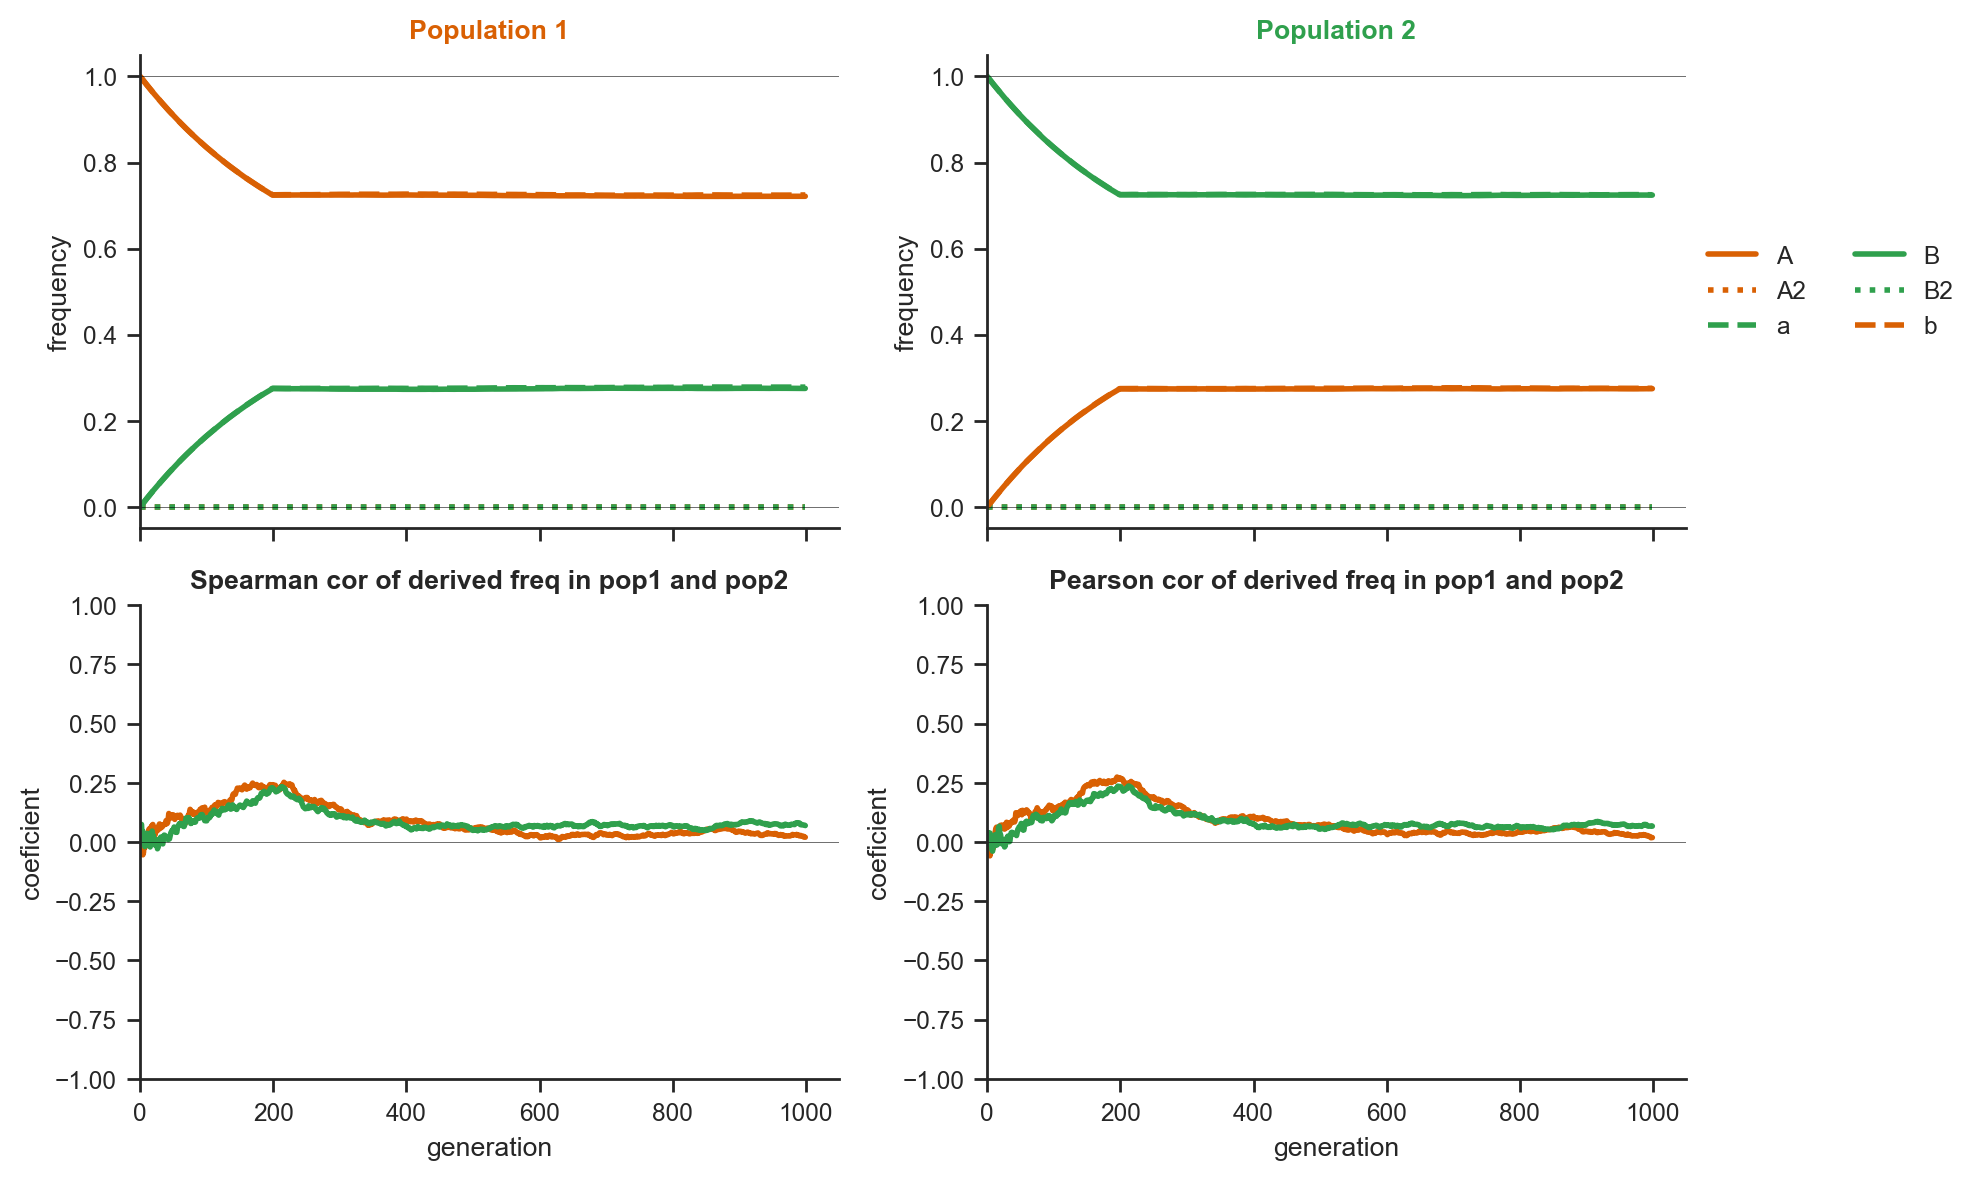

In [68]:
#| echo: true
plot_scenario(samples, M1=100, M2=100, mig_interval=(0, 200), AB_bdmi_s=-0)

---

## Strong migration in first 100 generations

### BDMI

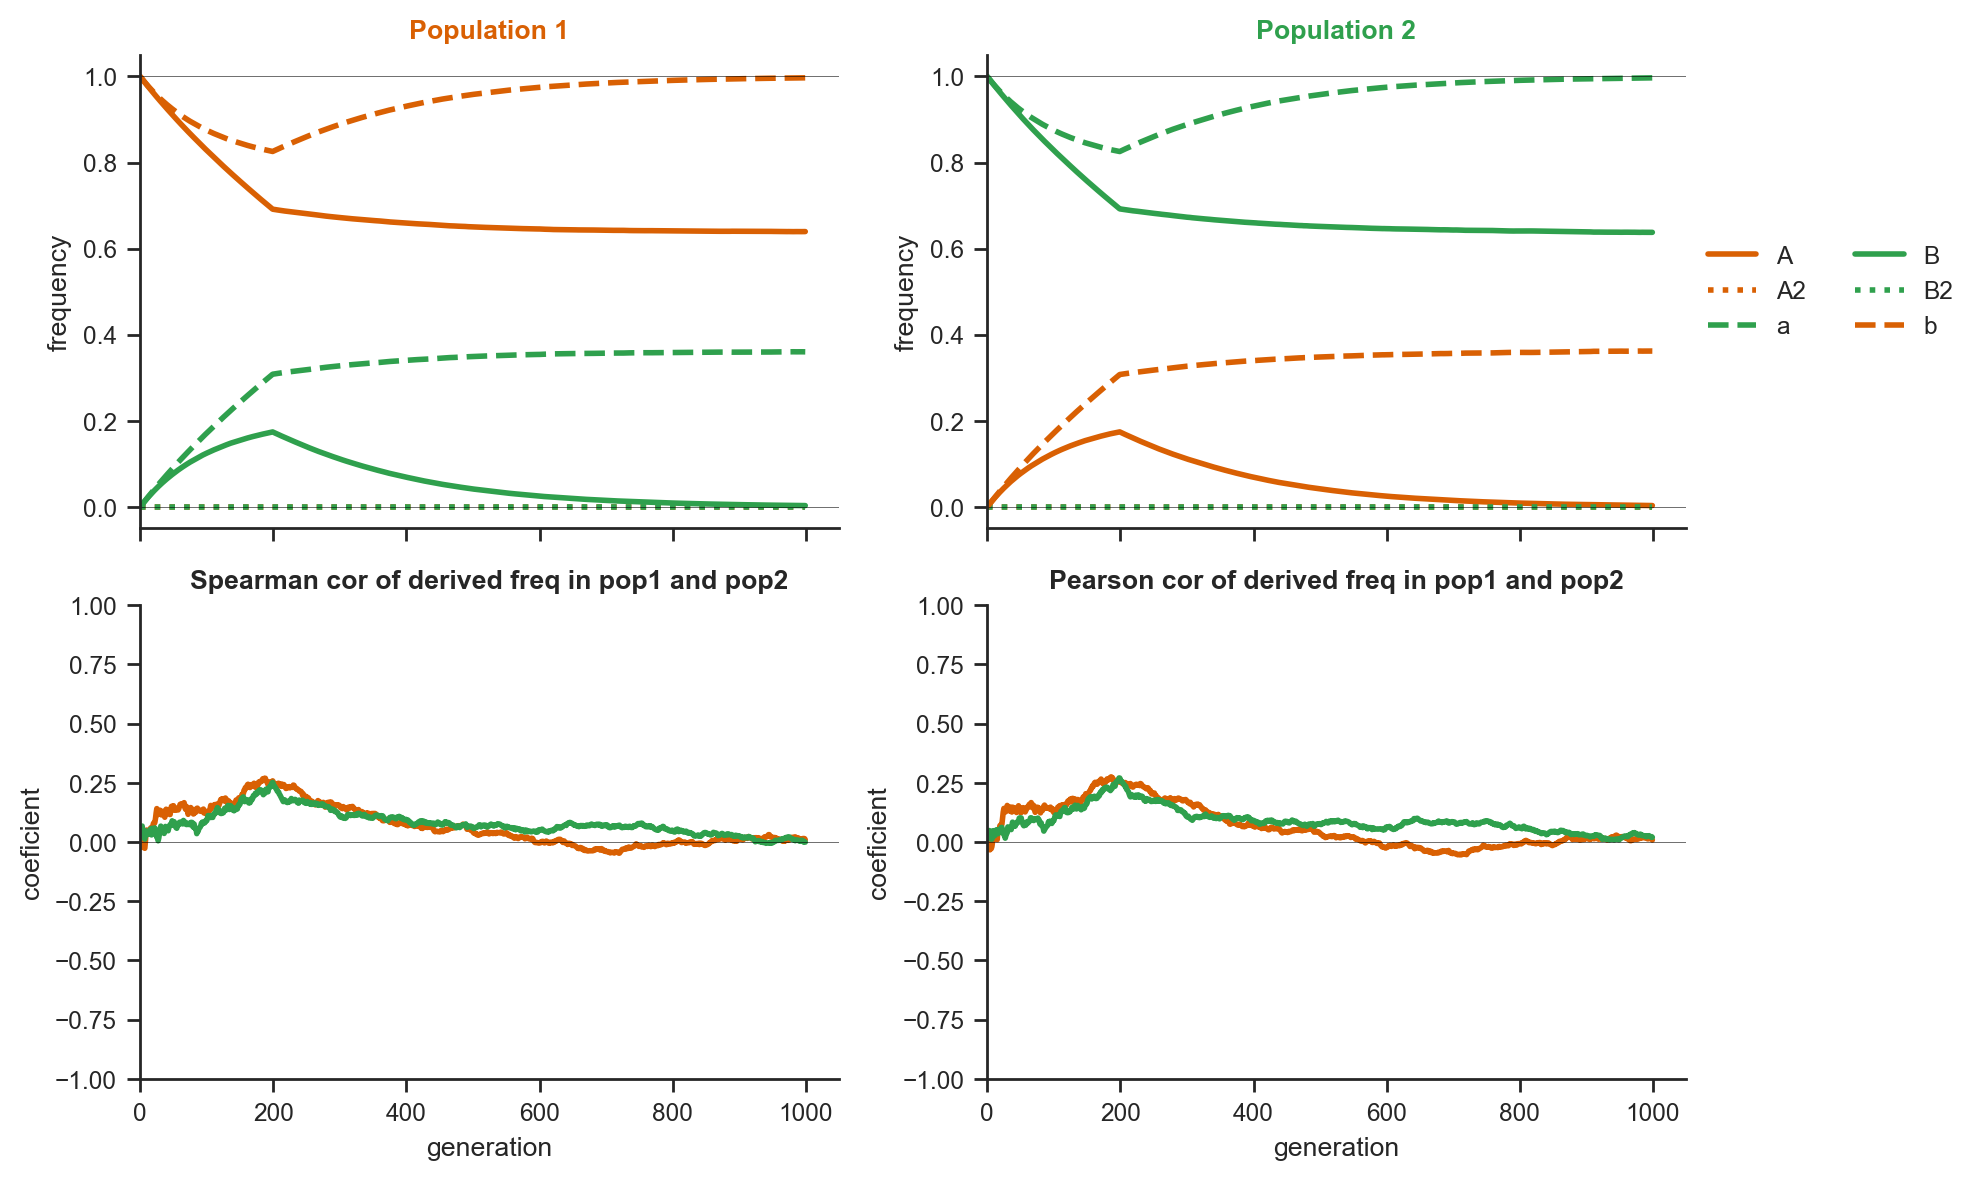

In [69]:
#| echo: true
plot_scenario(samples, M1=100, M2=100, mig_interval=(0, 200), AB_bdmi_s=s)

---

# Ongoing migration

---

## Migration

### No BDMI

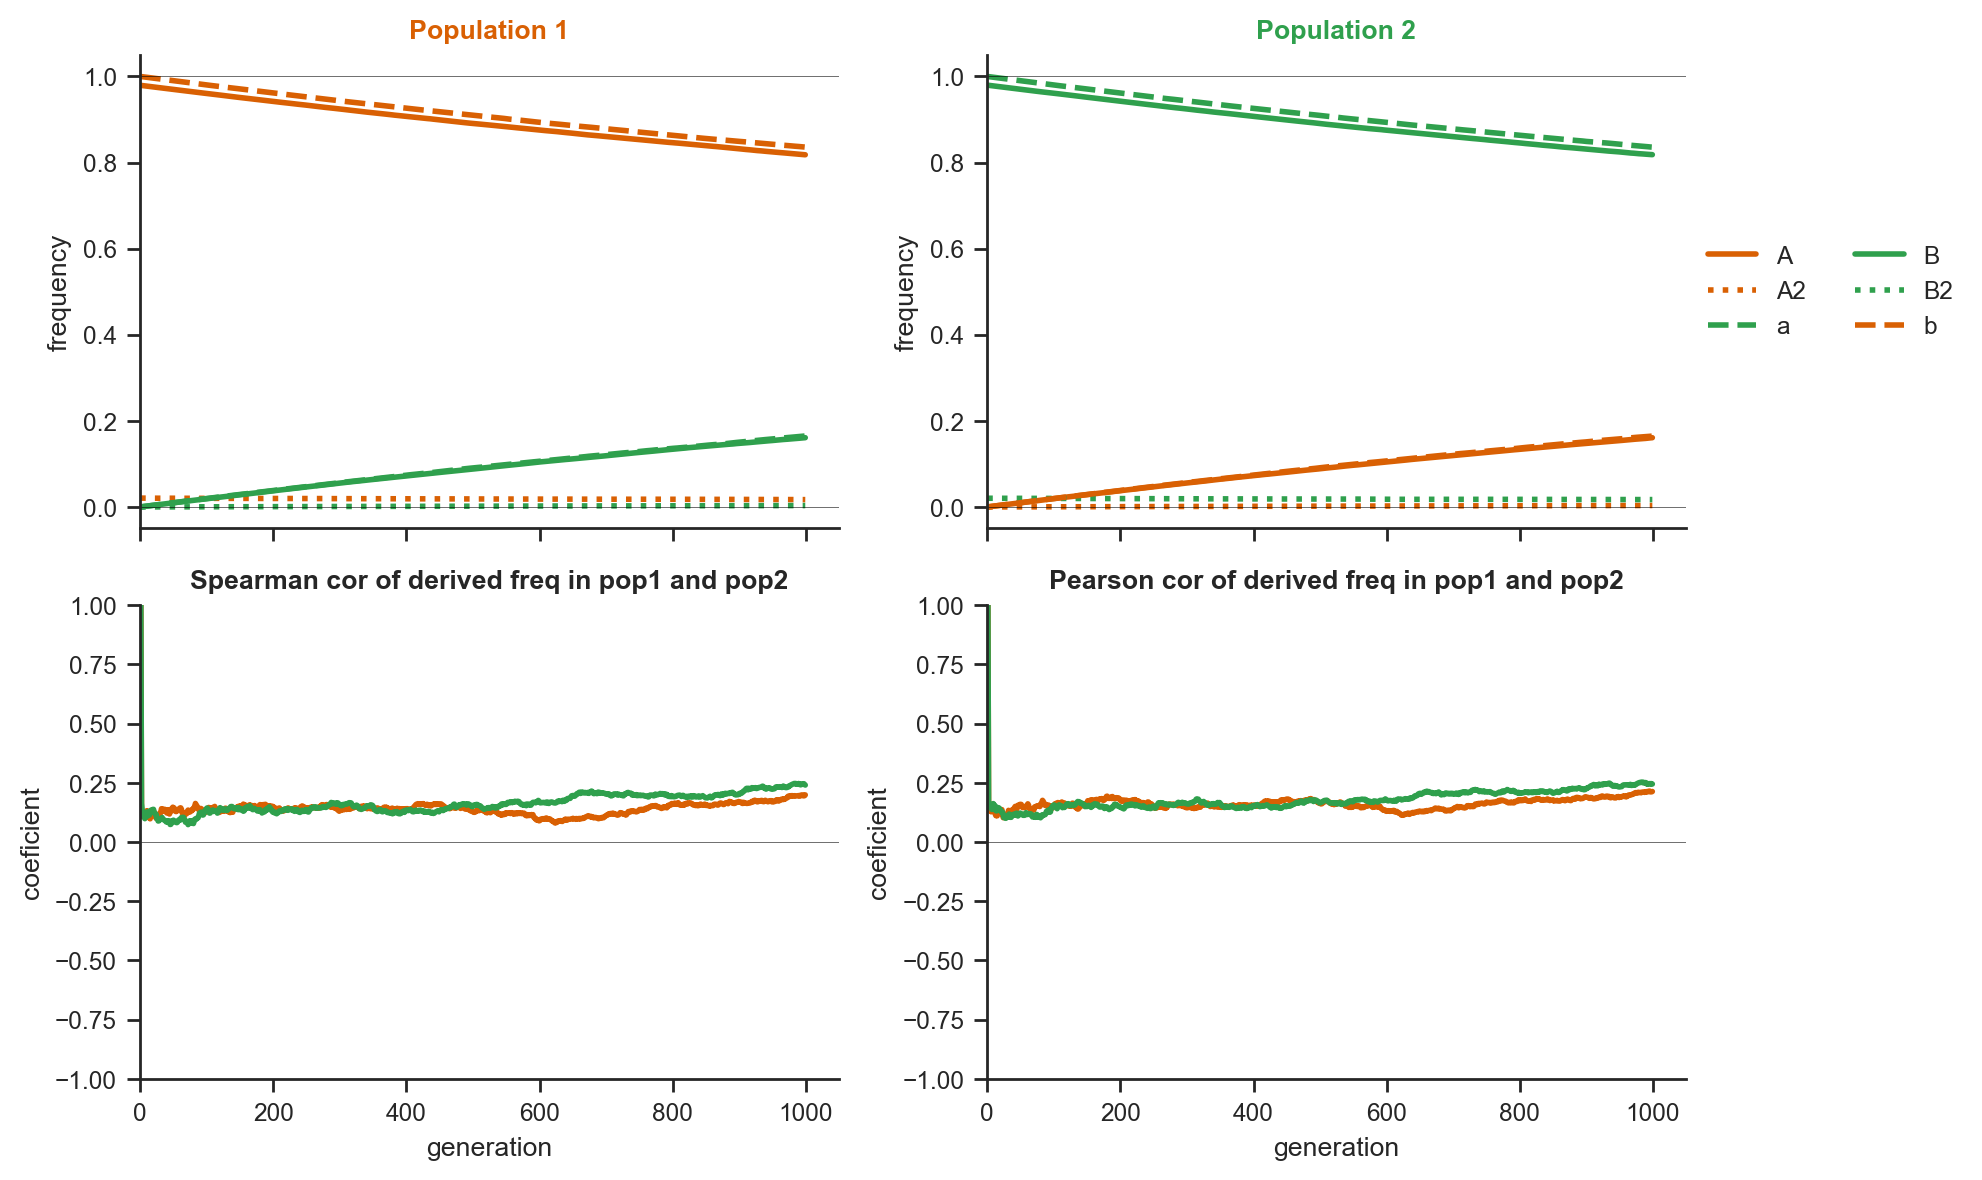

In [70]:
#| echo: true
plot_scenario(samples, M1=10, M2=10, A2_freq=bfr, B2_freq=bfr, AB_bdmi_s=0)

---

## Migration

### BDMI

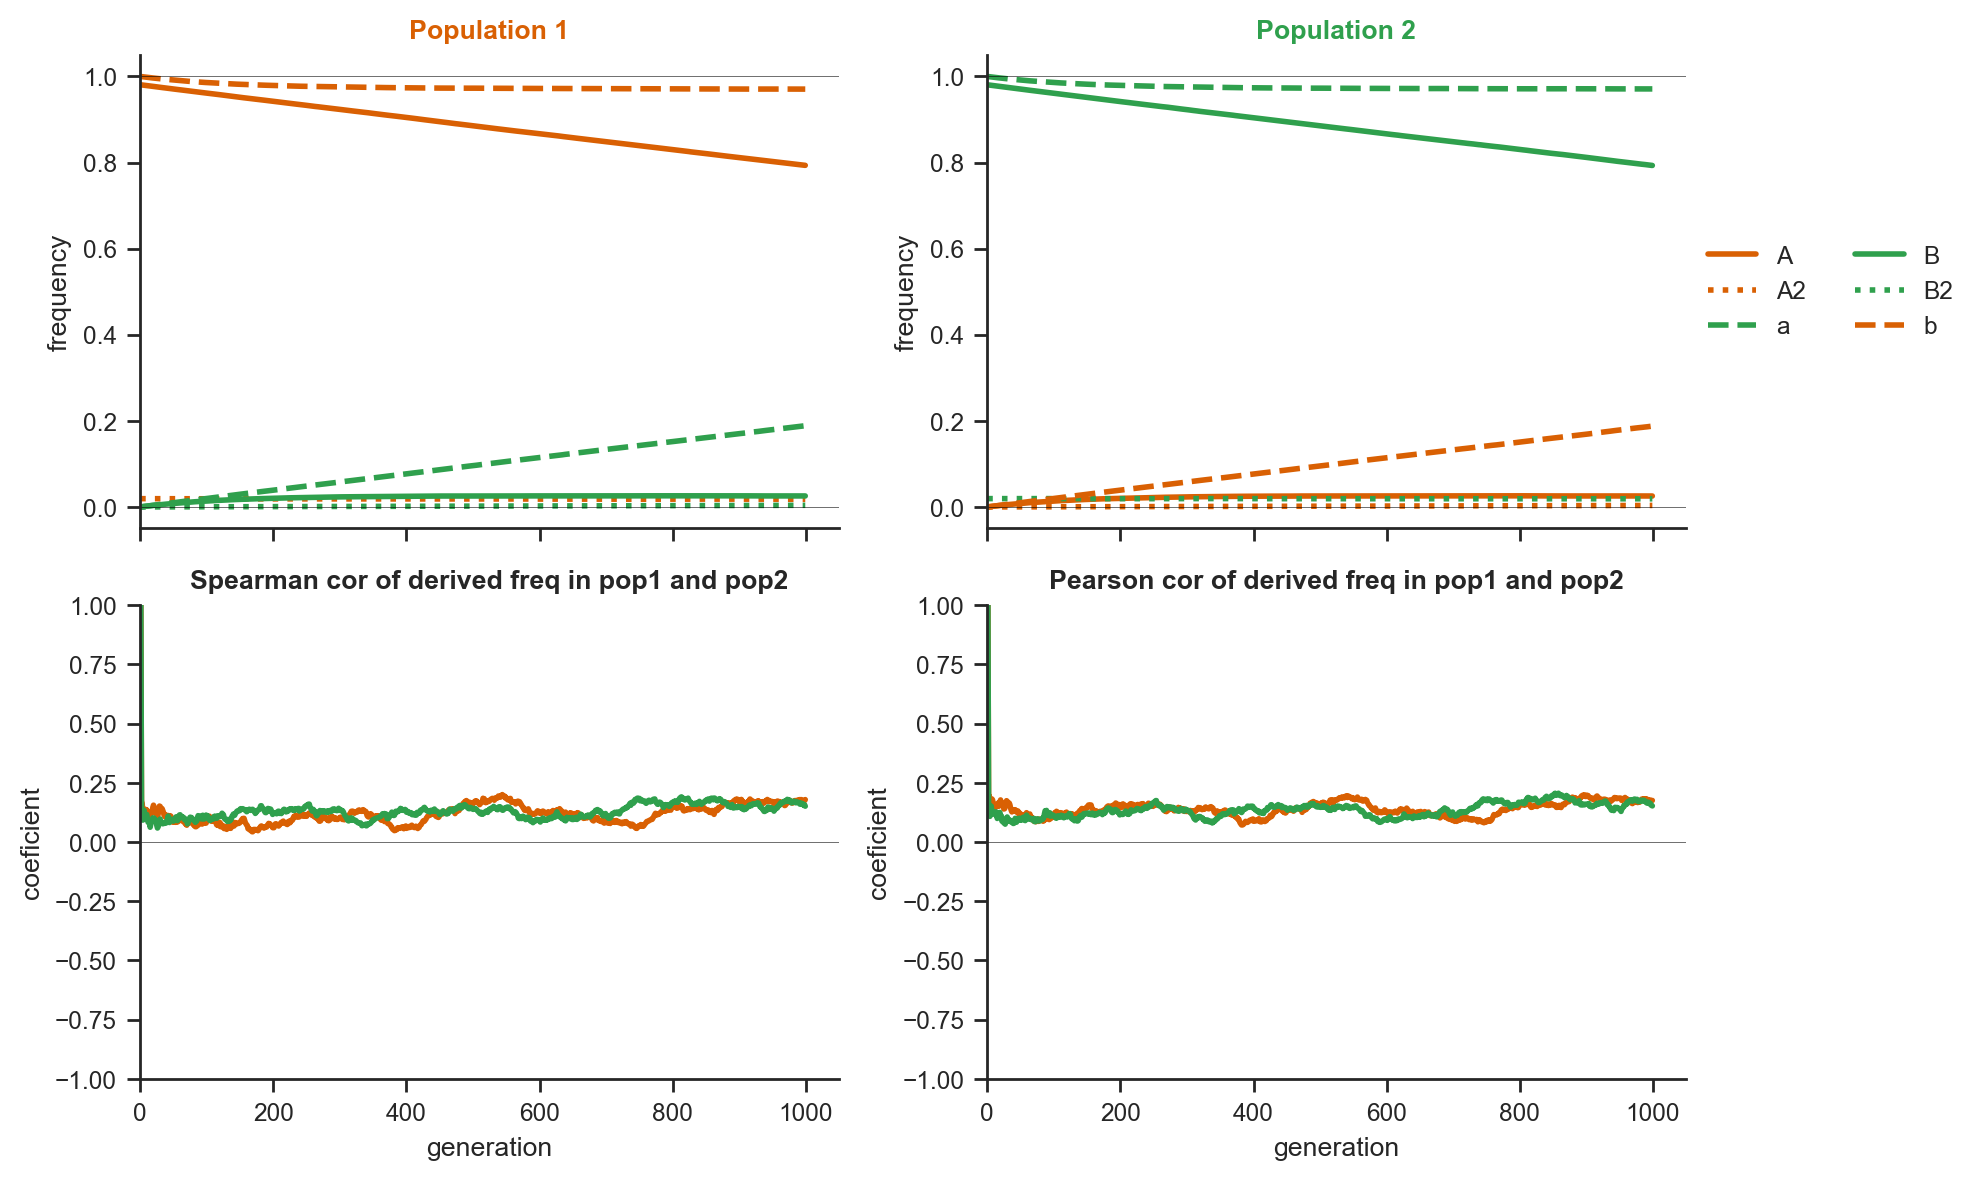

In [71]:
#| echo: true
plot_scenario(samples, M1=10, M2=10, A2_freq=bfr, B2_freq=bfr, AB_bdmi_s=s)

---

## Stronger migration

### No BDMI

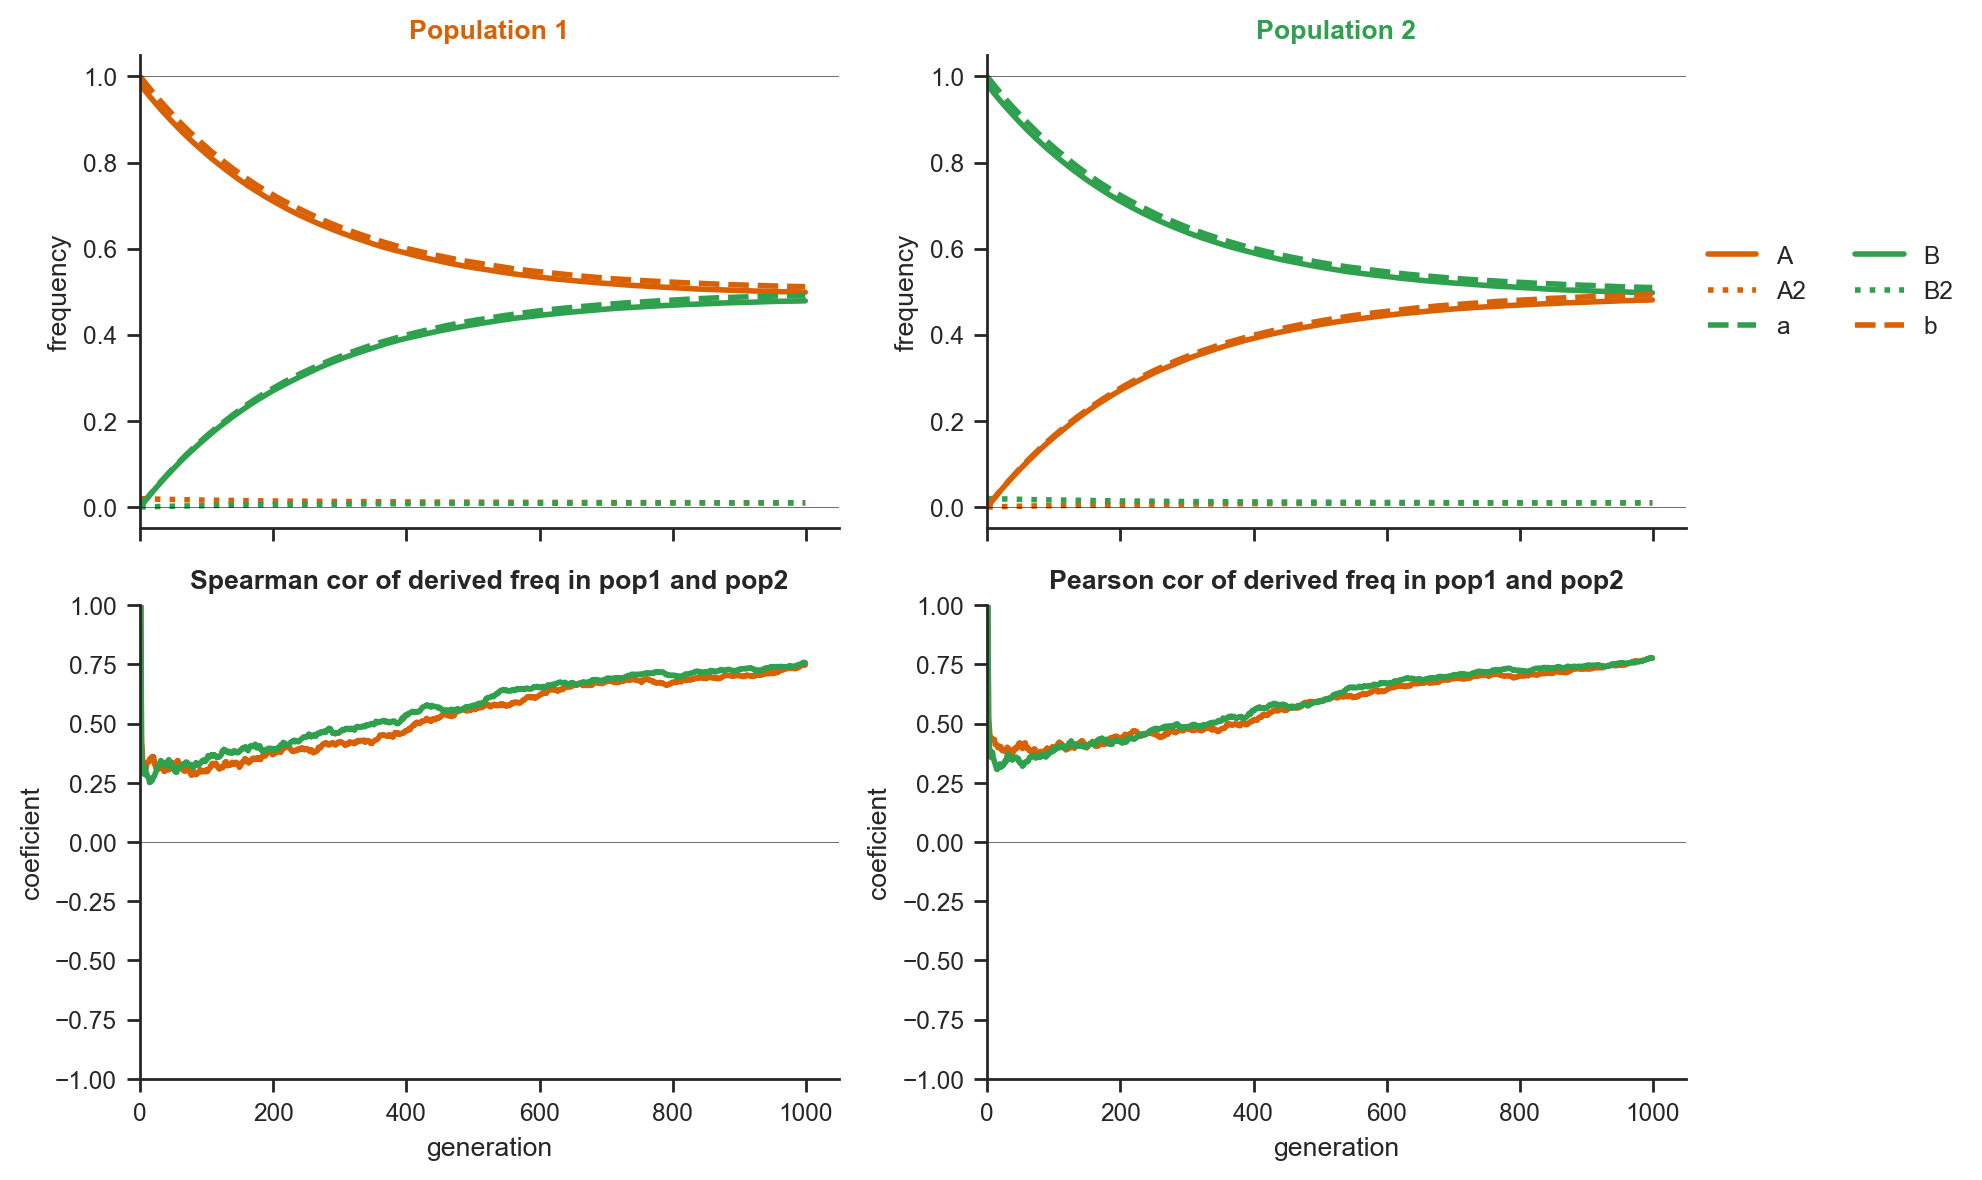

In [72]:
#| echo: true
plot_scenario(samples, M1=100, M2=100, A2_freq=bfr, B2_freq=bfr, AB_bdmi_s=0)

---

## Stronger migration

### BDMI

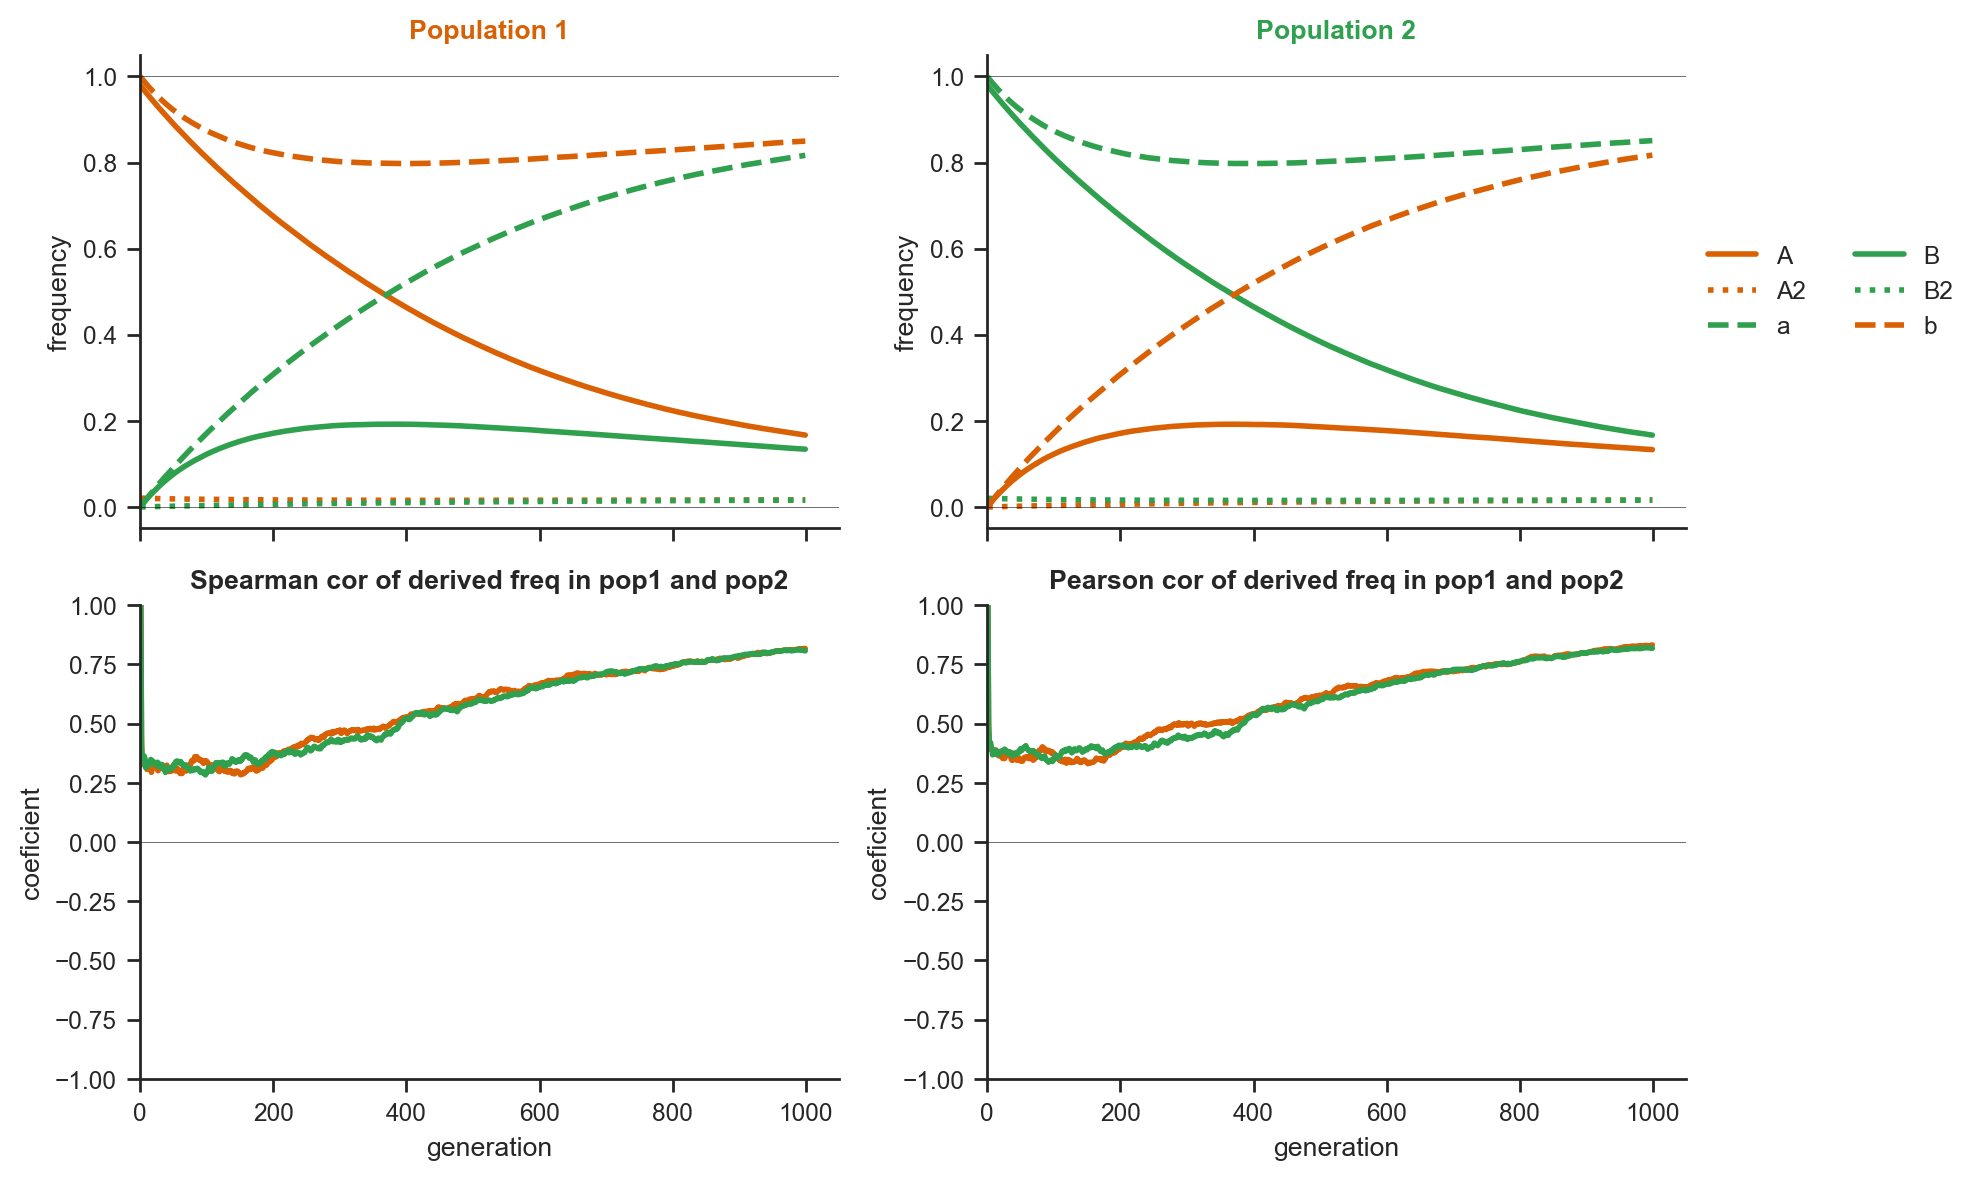

In [73]:
#| echo: true
plot_scenario(samples, M1=100, M2=100, A2_freq=bfr, B2_freq=bfr, AB_bdmi_s=s)

---

## Allele swapping


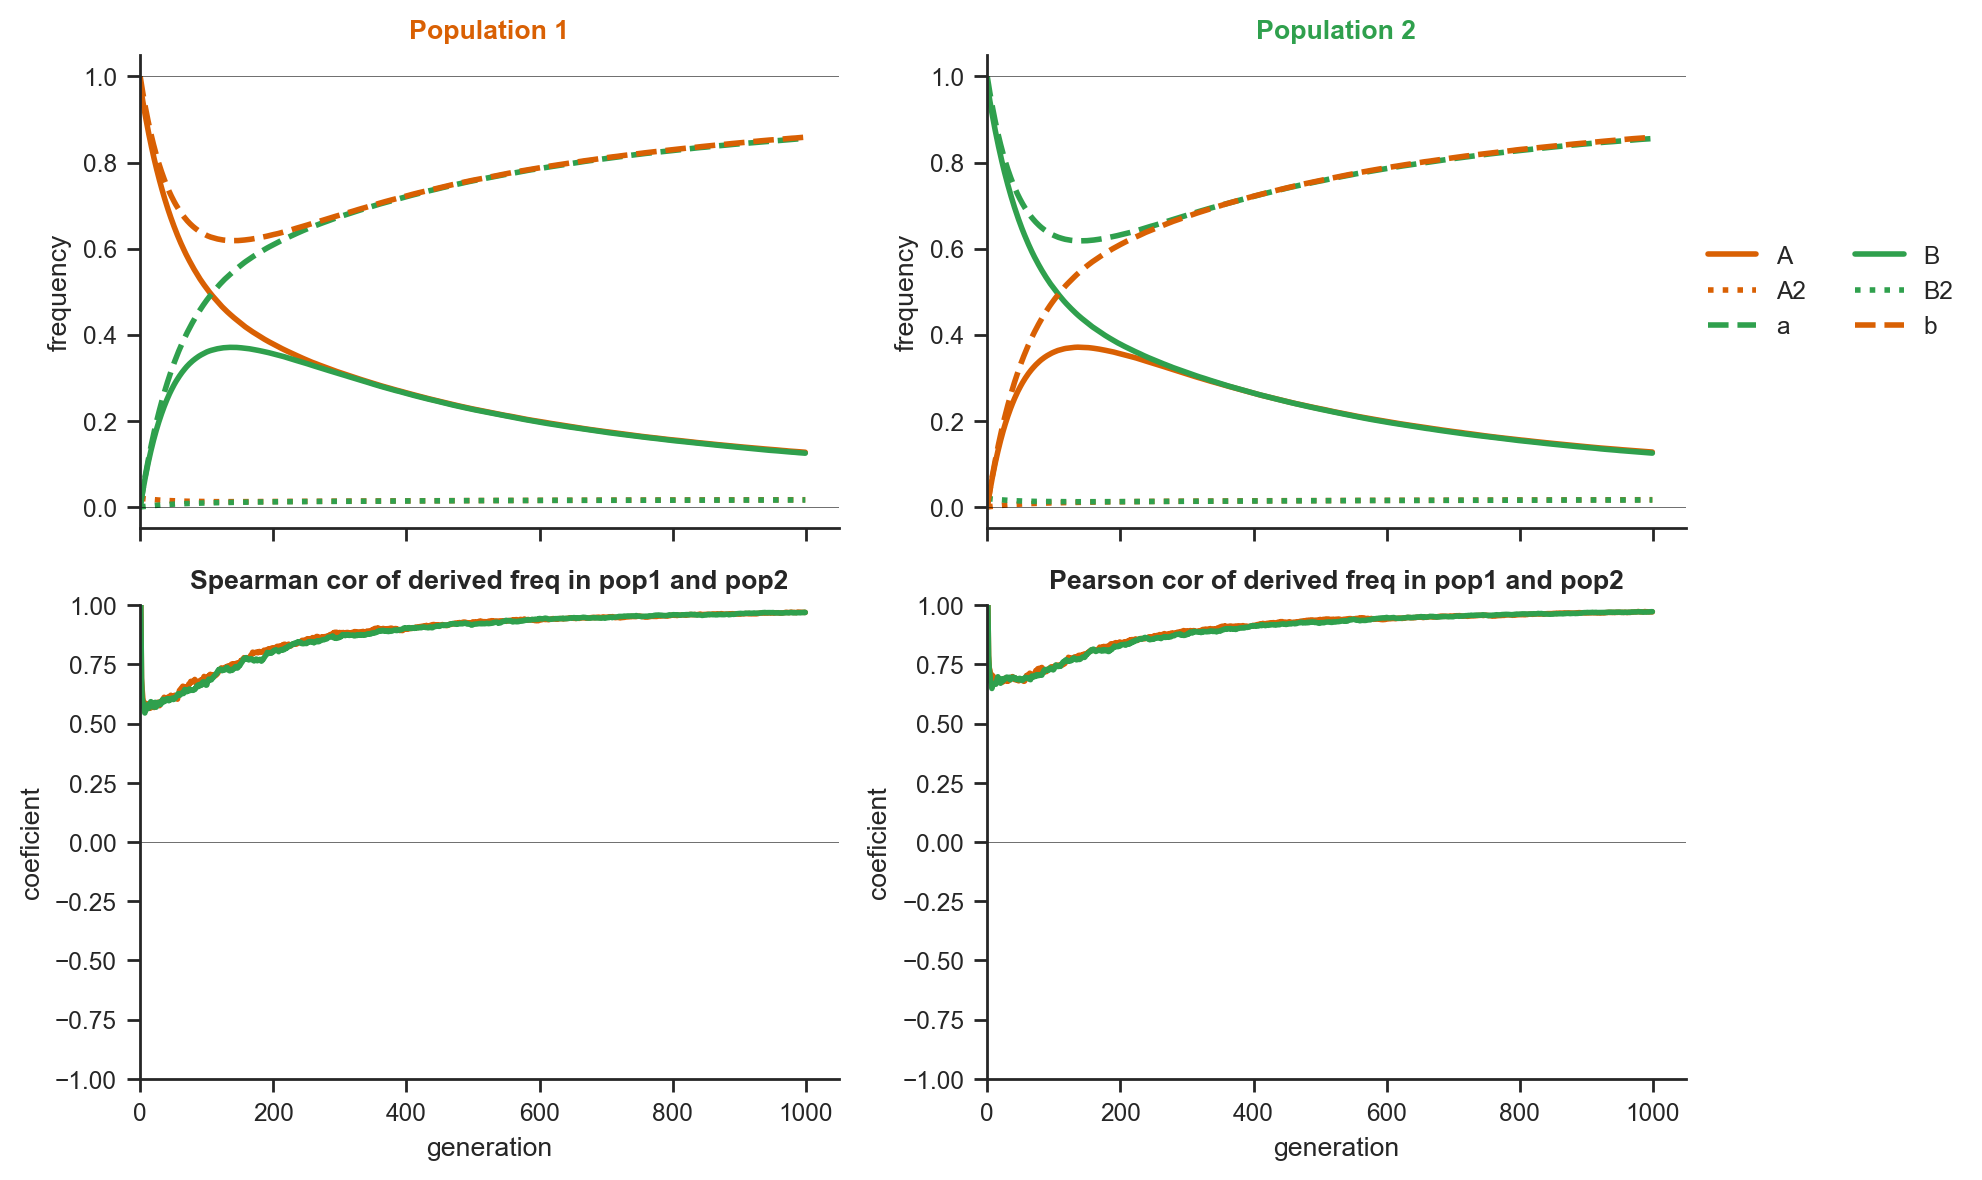

In [74]:
#| echo: true
plot_scenario(samples, M1=500, M2=500, A2_freq=bfr, B2_freq=bfr, AB_bdmi_s=s)

---

# Swamping

---

## Stronger migration

### No BDMI

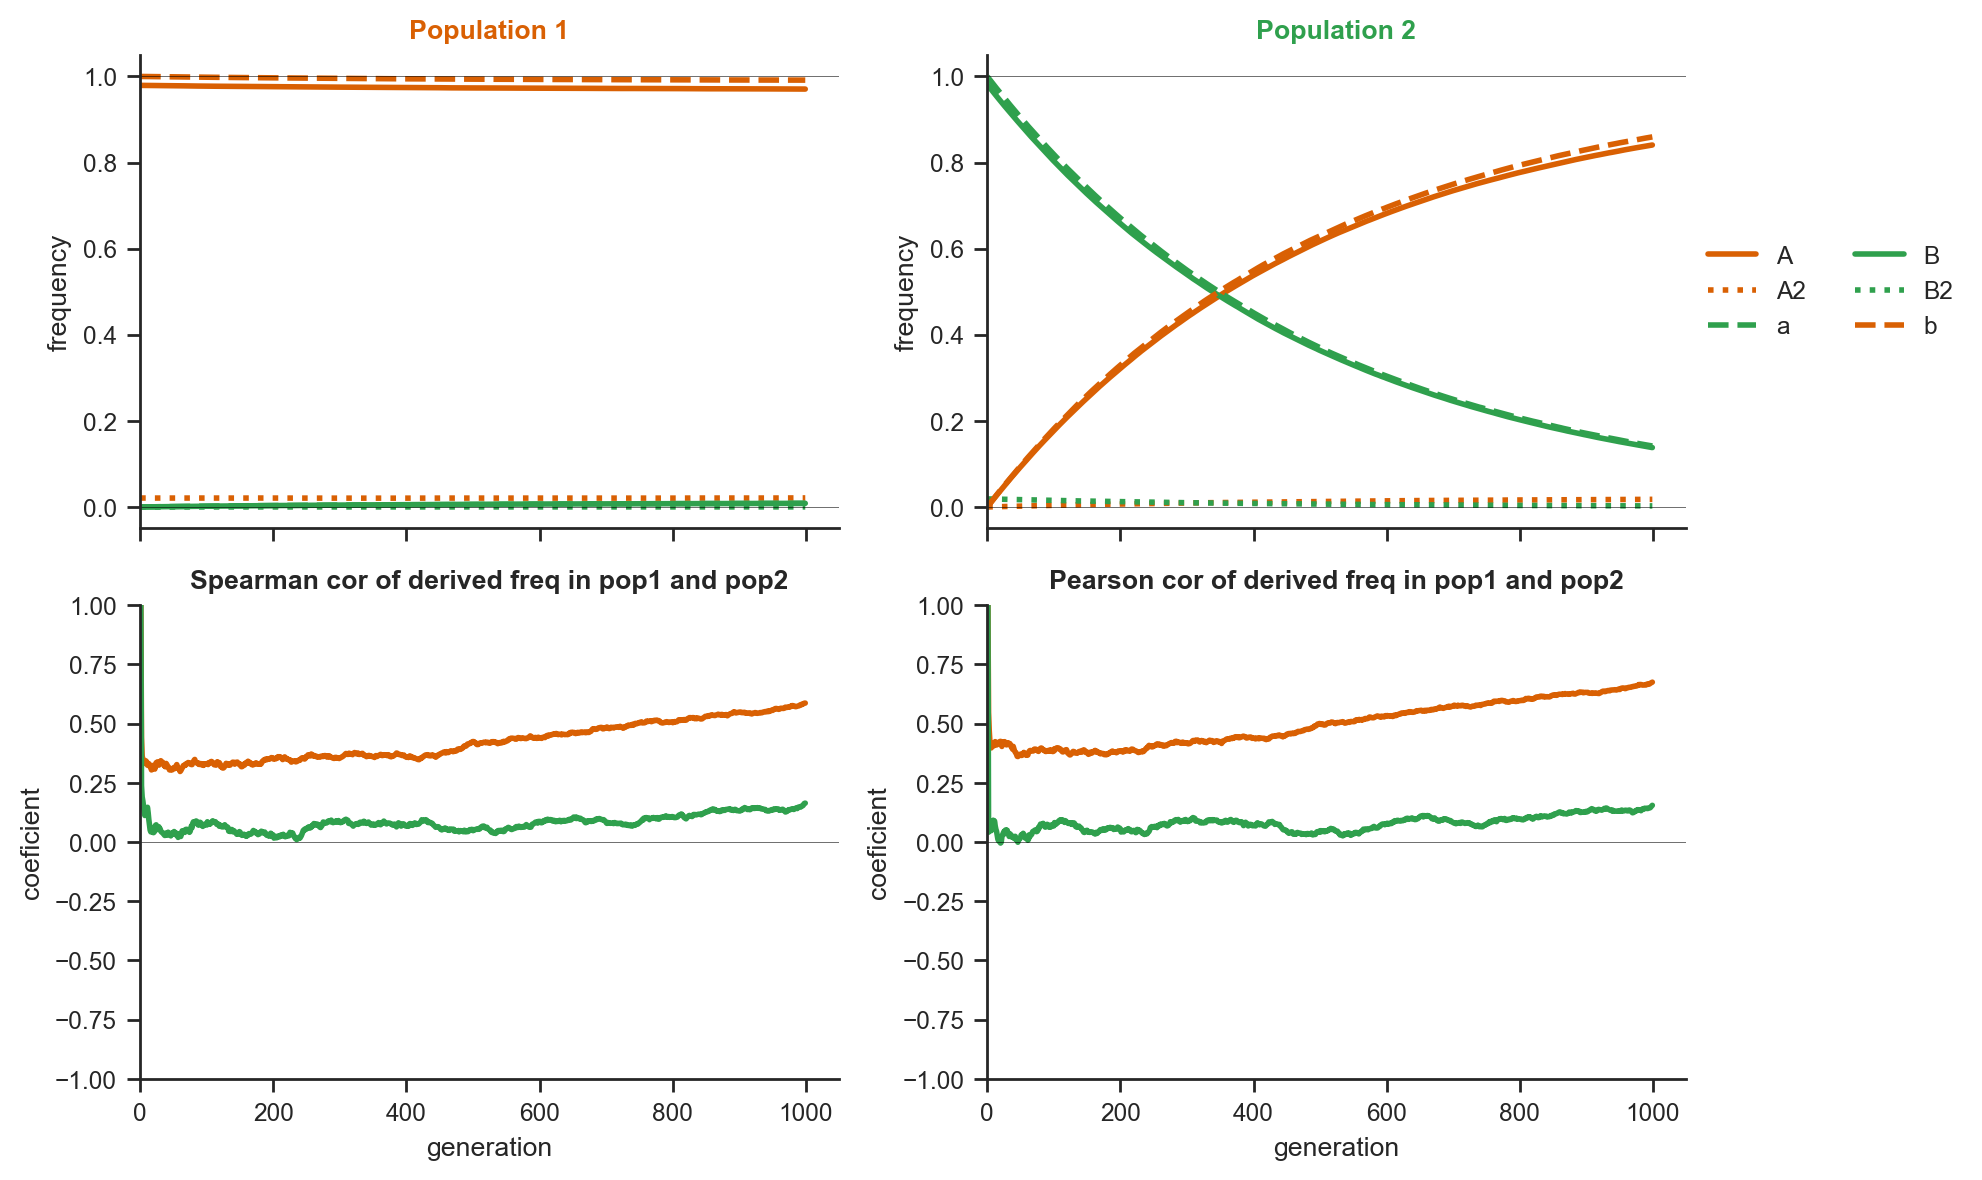

In [75]:
#| echo: true
plot_scenario(samples, M1=1, M2=100, A2_freq=bfr, B2_freq=bfr, AB_bdmi_s=0)

---

## Stronger migration

### BDMI

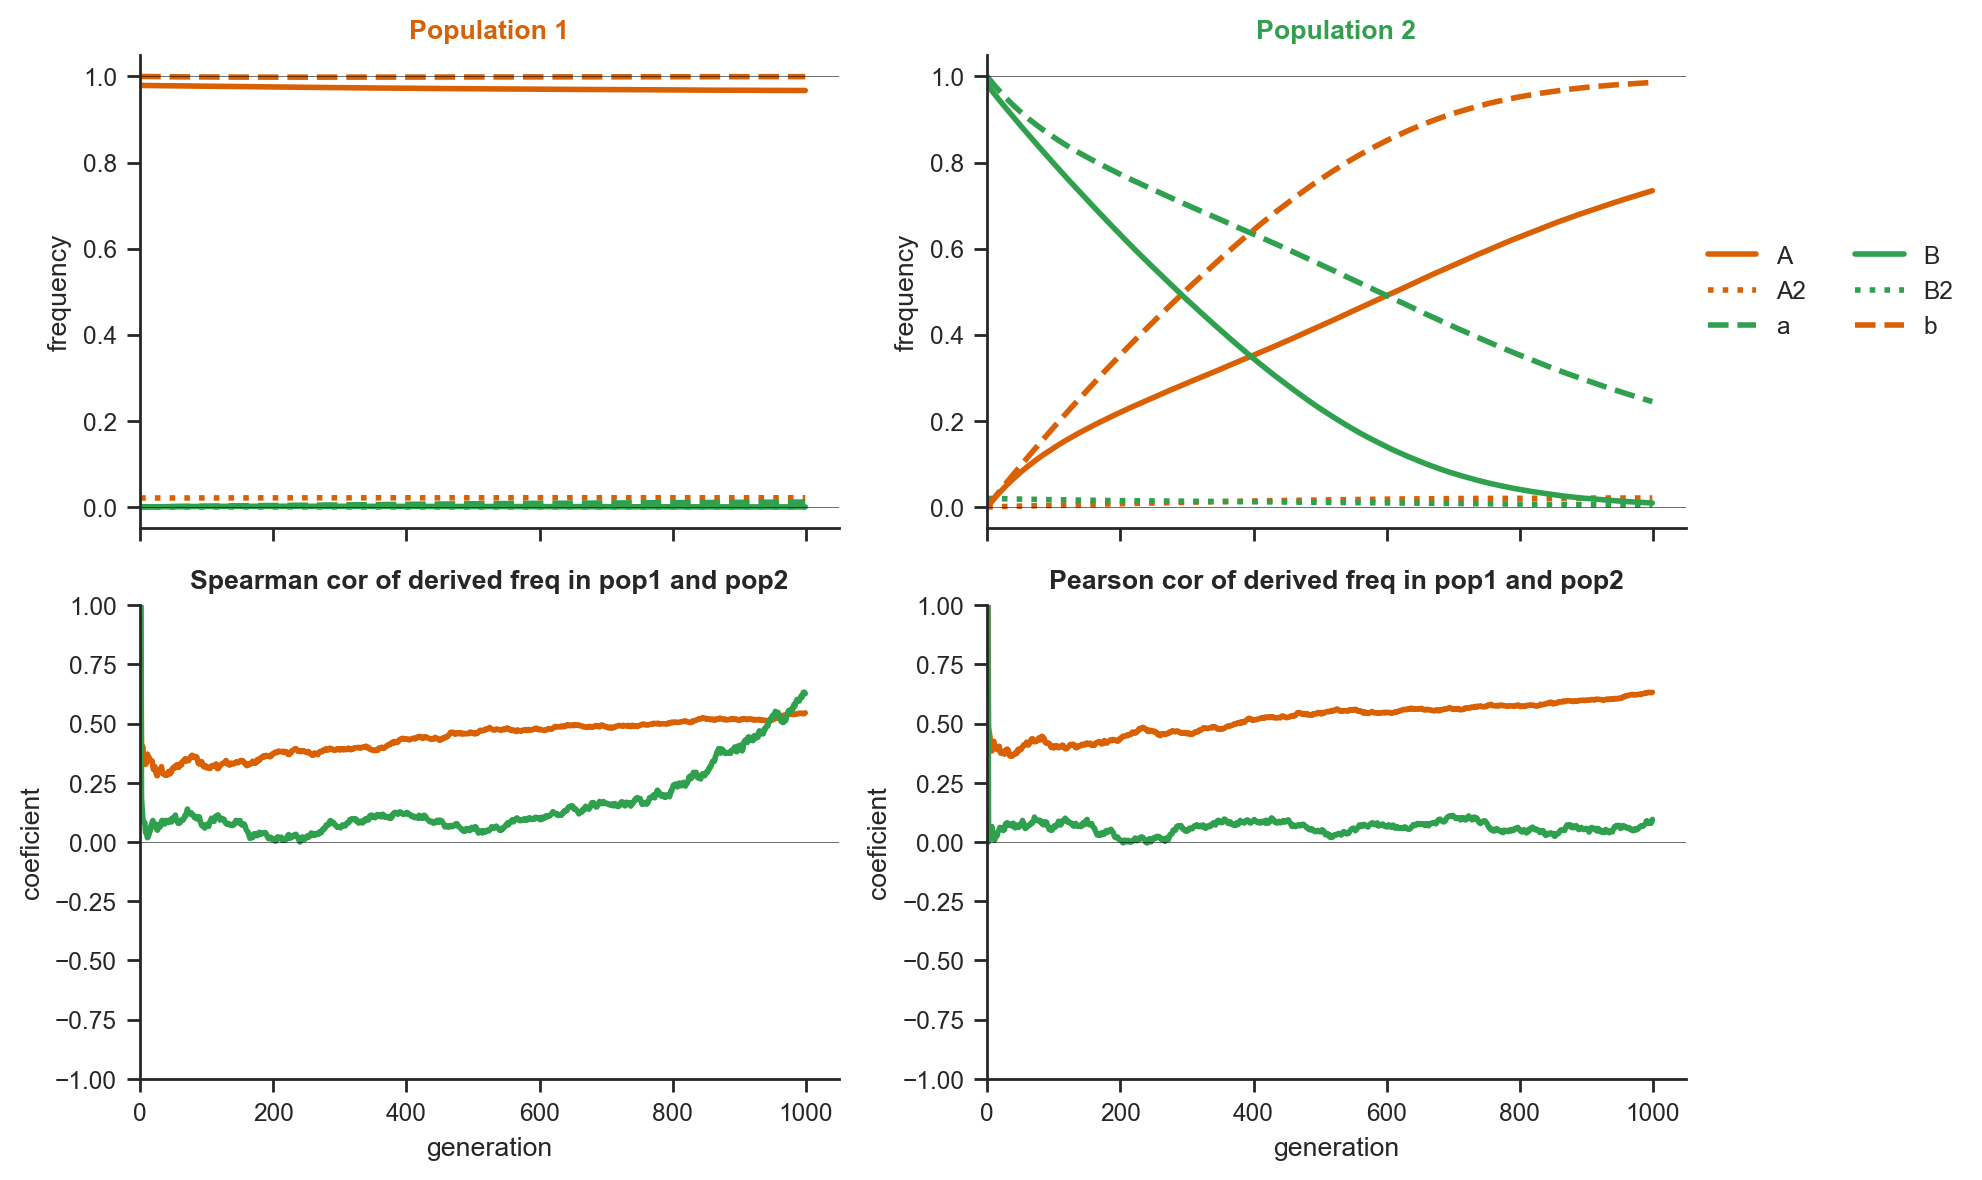

In [76]:
#| echo: true
plot_scenario(samples, M1=1, M2=100, A2_freq=bfr, B2_freq=bfr, AB_bdmi_s=s)

# Baboon scenarios

---

## BDMI on both AB and ab combinations and 1% constant migration

## Negative selection: -0.5

---

In [87]:
# #| echo: true
# plot_scenario(samples, N1=30000, N2=30000, M1=0, M2=300, A2_freq=bfr, B2_freq=bfr, 
#               AB_bdmi_s=-0.5, ab_bdmi_s=-0.25)

In [86]:
# #| echo: true
# plot_scenario(samples, N1=30000, N2=30000, M1=0, M2=300, A2_freq=0, B2_freq=0, 
#               AB_bdmi_s=-0.5, ab_bdmi_s=-0.25)

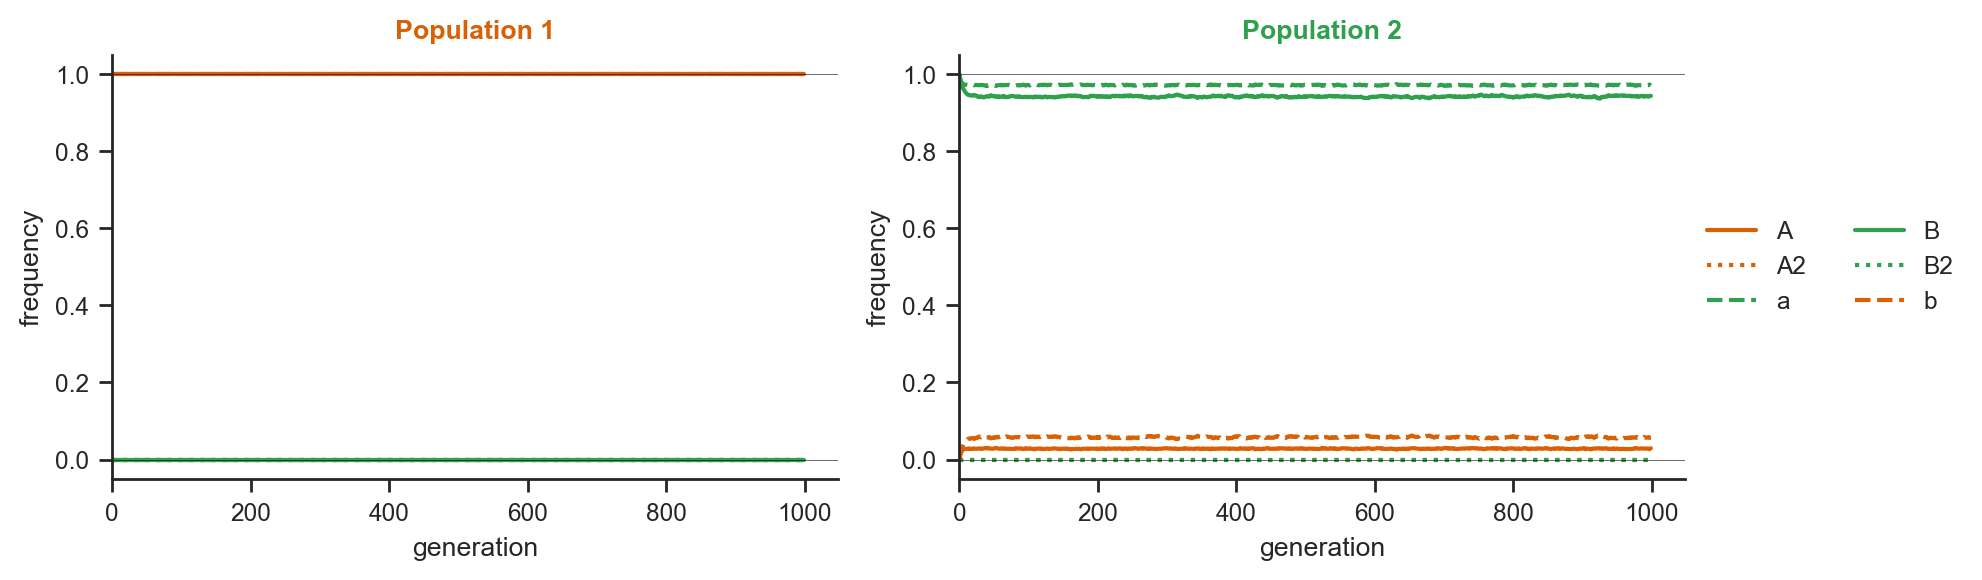

In [13]:
twolocus_twoallele_plot(
    compute_twolocus_twoallele_sample_data(generations=1000,
                                              N1=30000, N2=30000, 
                                              M1=0, M2=300,  
                                              init_pulse1=0, init_pulse2=0,
                                              A2_freq=0, B2_freq=0, 
                                              AB_bdmi_s=-0.5, ab_bdmi_s=-0.25,
                                              A_s=0, B_s=0,
                                              A2_s=0, B2_s=0, 
                                              a_s=0, b_s=0, 
                                              AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

---

Here fixing introgression requires an initial pulse swapping MPA in population 2:

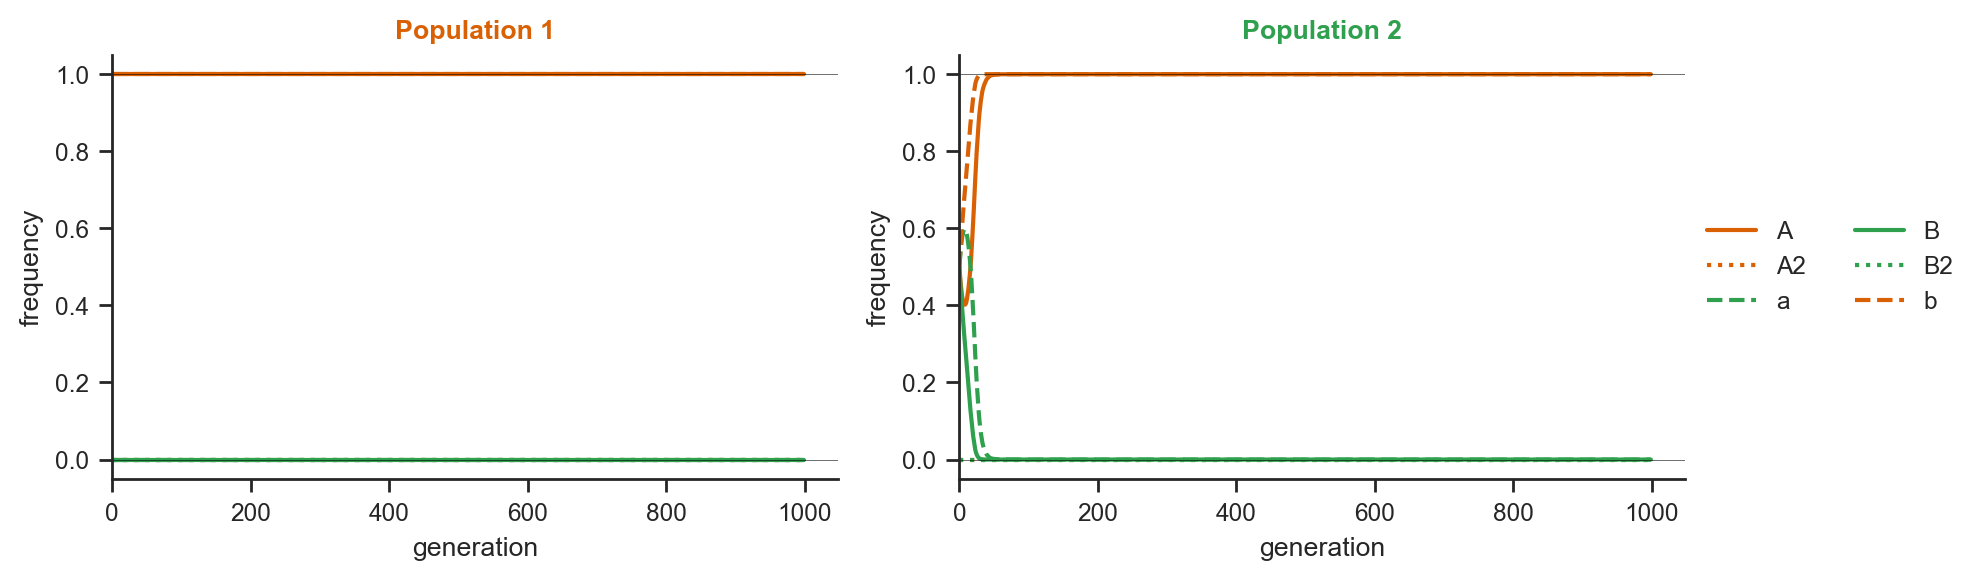

In [14]:
twolocus_twoallele_plot(
    compute_twolocus_twoallele_sample_data(generations=1000,
                                              N1=30000, N2=30000, 
                                              M1=0, M2=300,  
                                              init_pulse1=0, init_pulse2=0.5,
                                              A2_freq=0, B2_freq=0, 
                                              AB_bdmi_s=-0.5, ab_bdmi_s=-0.25,
                                              A_s=0, B_s=0,
                                              A2_s=0, B2_s=0, 
                                              a_s=0, b_s=0, 
                                              AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

---

## Negative selection: -0.15

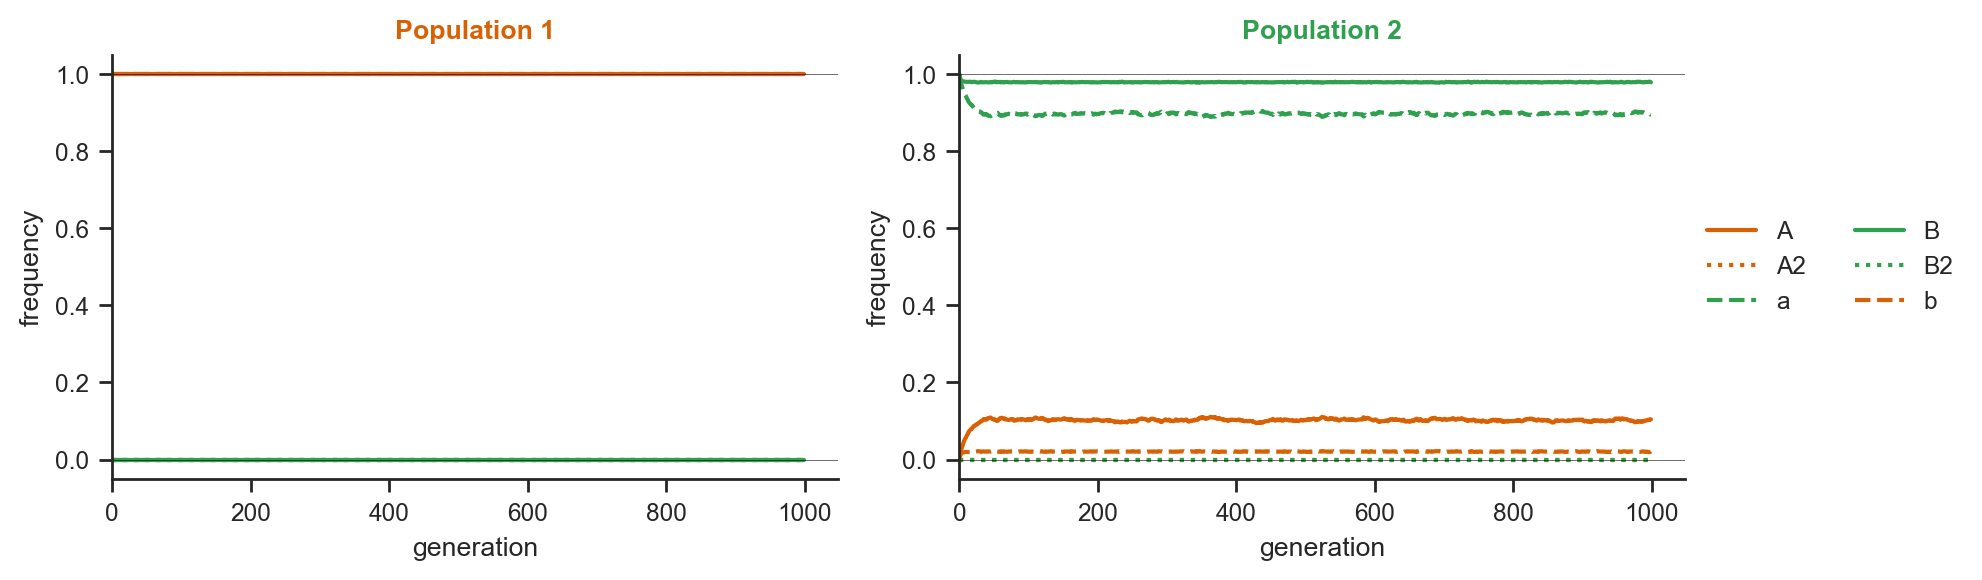

In [15]:
twolocus_twoallele_plot(
    compute_twolocus_twoallele_sample_data(generations=1000,
                                              N1=30000, N2=30000, 
                                              M1=0, M2=300,  
                                              init_pulse1=0, init_pulse2=0,
                                              A2_freq=0, B2_freq=0, 
                                              AB_bdmi_s=-0.15, ab_bdmi_s=-0.7,
                                              A_s=0, B_s=0,
                                              A2_s=0, B2_s=0, 
                                              a_s=0, b_s=0, 
                                              AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

---

Here fixing introgression only requires an initial pulse reducing MPA to 0.6. The migration-selection equilibrium already shifts it about 10% (above)

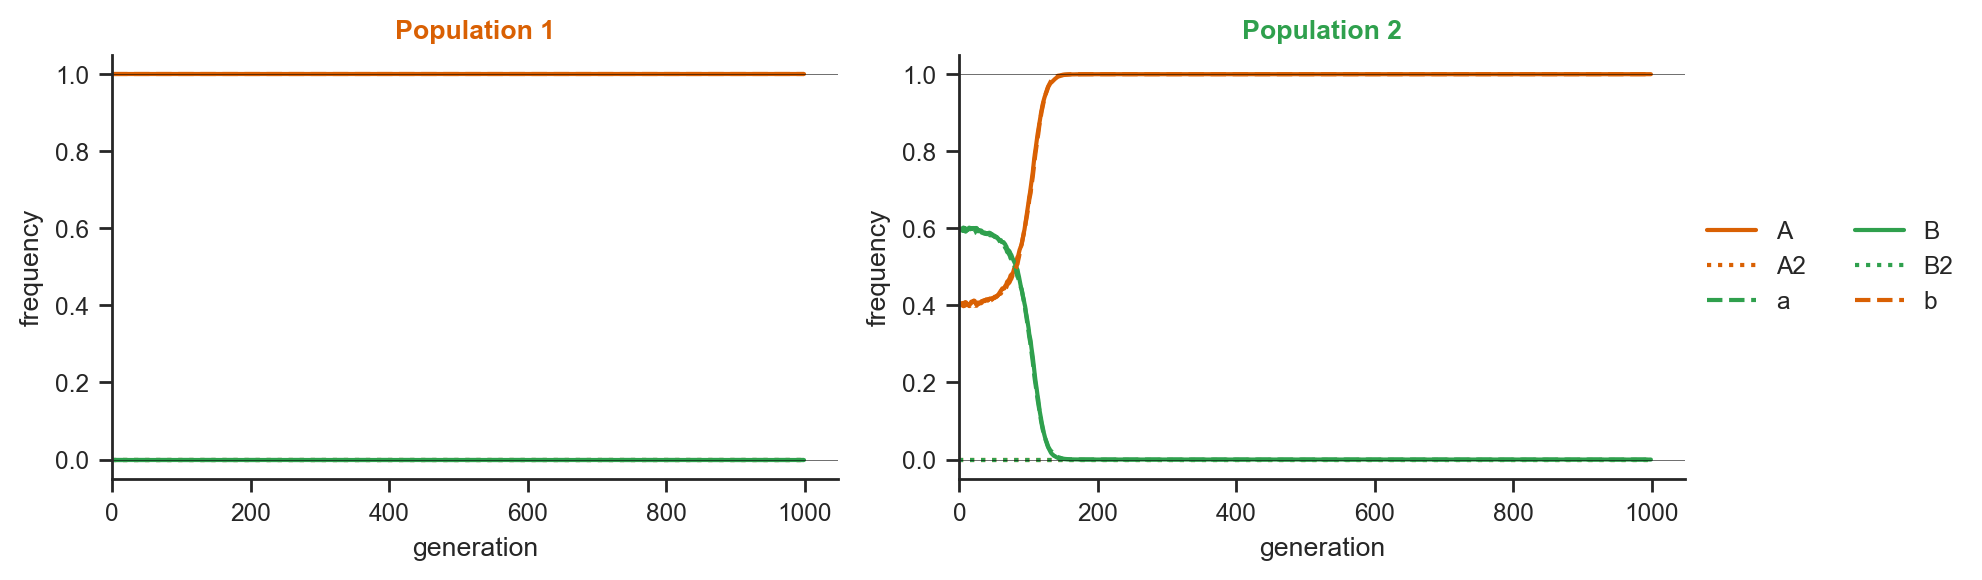

In [16]:
twolocus_twoallele_plot(
    compute_twolocus_twoallele_sample_data(generations=1000,
                                              N1=30000, N2=30000, 
                                              M1=0, M2=300,  
                                              init_pulse1=0, init_pulse2=0.4,
                                              A2_freq=0, B2_freq=0, 
                                              AB_bdmi_s=-0.15, ab_bdmi_s=-0.15,
                                              A_s=0, B_s=0,
                                              A2_s=0, B2_s=0, 
                                              a_s=0, b_s=0, 
                                              AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

---

## Negative selection: -0.1

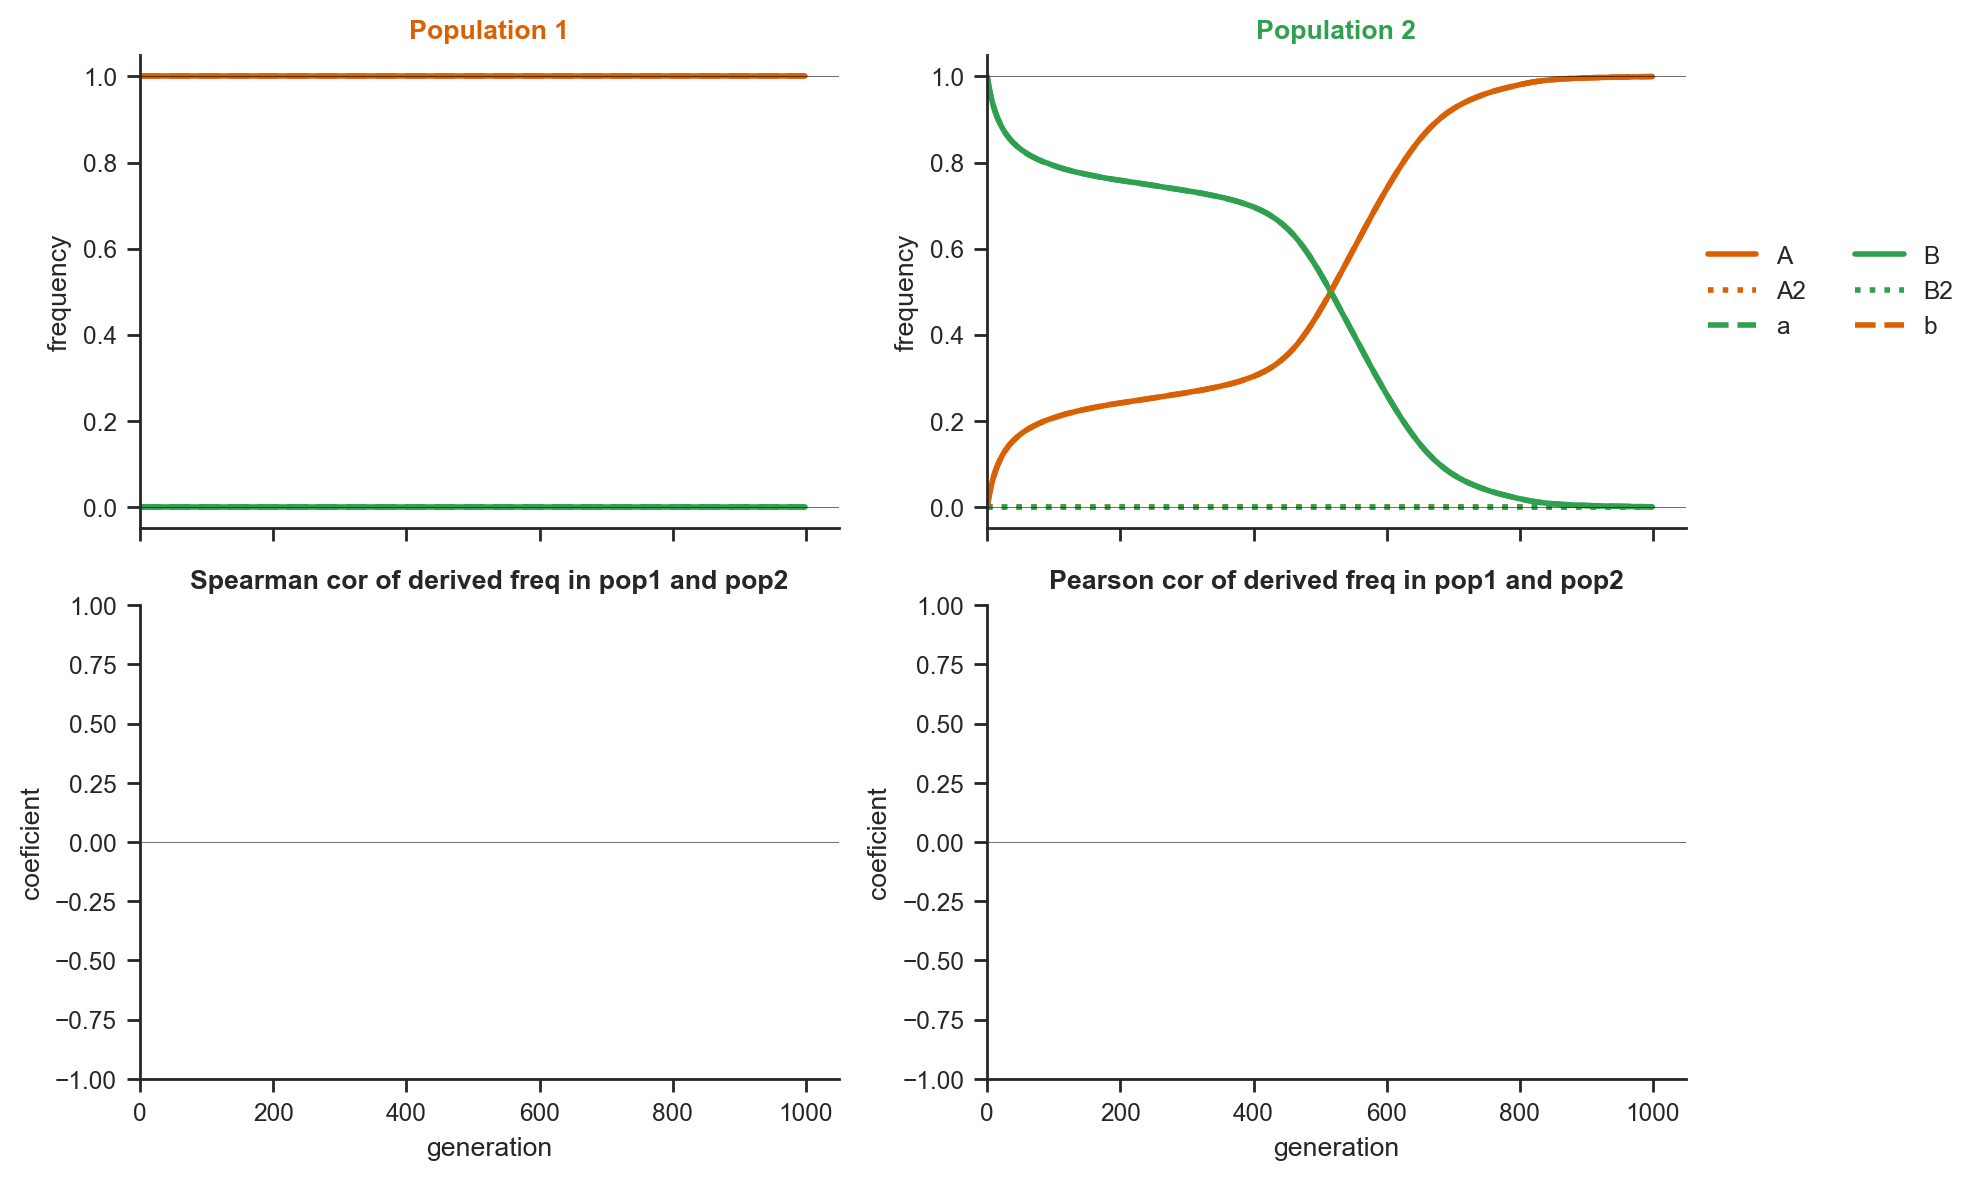

In [80]:
#| echo: true
plot_scenario(samples, N1=30000, N2=30000, M1=0, M2=300, A2_freq=0, B2_freq=0, 
              AB_bdmi_s=-0.1, ab_bdmi_s=-0.1)

In [85]:
# #| echo: true
# plot_scenario(samples, generations=3000, N1=30000, N2=30000, M1=0, M2=30, A2_freq=bfr, B2_freq=bfr, 
#               AB_bdmi_s=s, ab_bdmi_s=s)

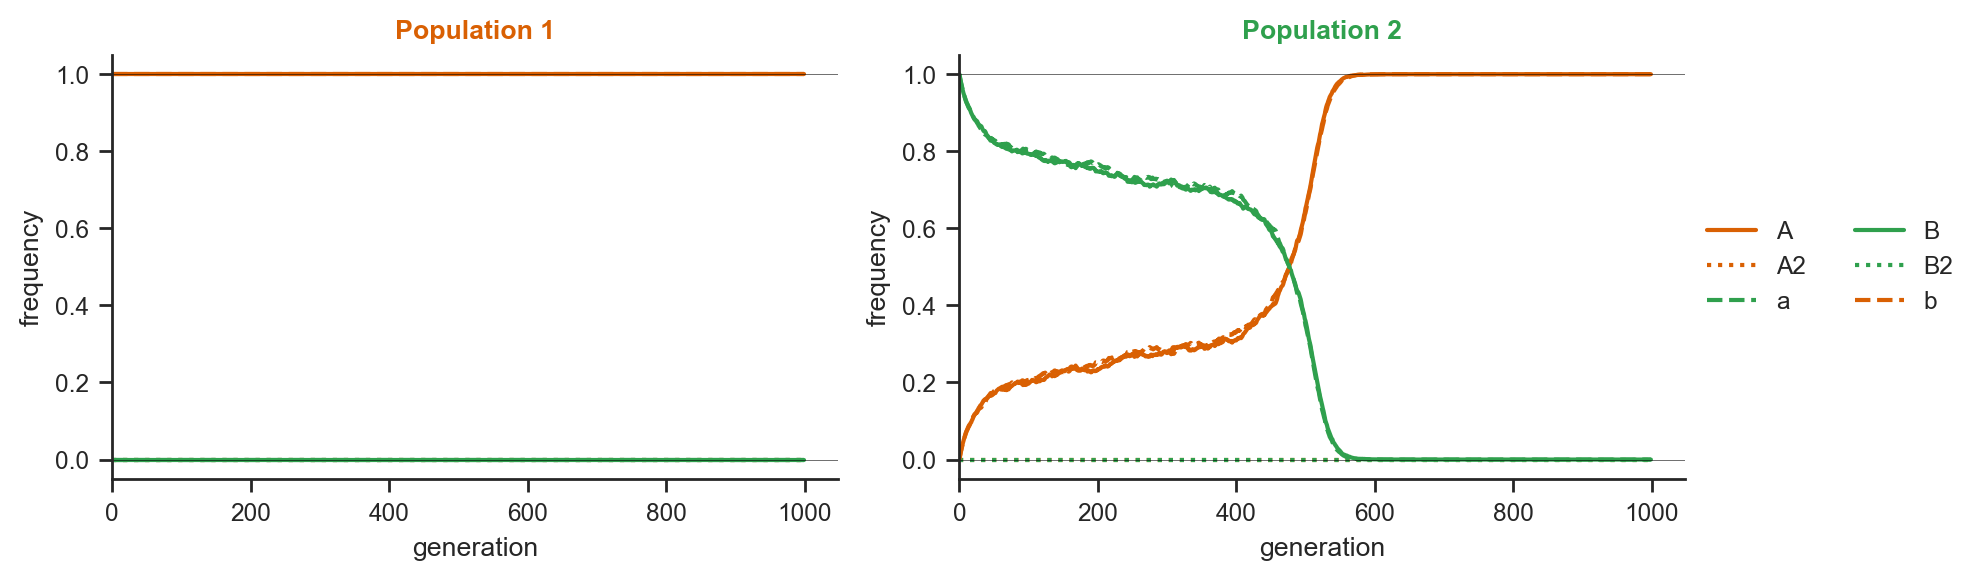

In [17]:
twolocus_twoallele_plot(
    compute_twolocus_twoallele_sample_data(generations=1000,
                                              N1=30000, N2=30000, 
                                              M1=0, M2=300,  
                                              init_pulse1=0, init_pulse2=0,
                                              A2_freq=0, B2_freq=0, 
                                              AB_bdmi_s=-0.1, ab_bdmi_s=-0.1,
                                              A_s=0, B_s=0,
                                              A2_s=0, B2_s=0, 
                                              a_s=0, b_s=0, 
                                              AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

---

Here an initial pulse just only slighly accelerates fixation of A and b in population 2:

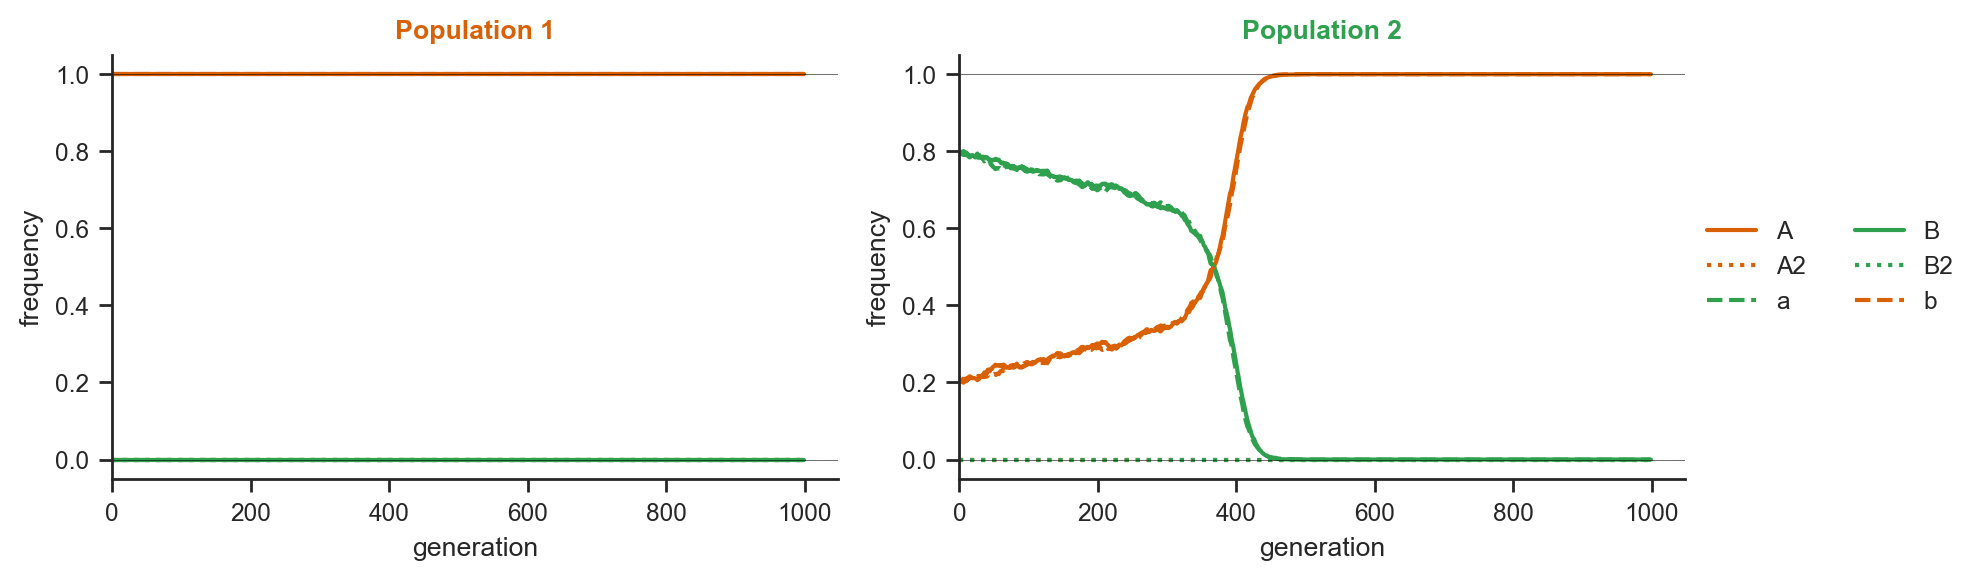

In [18]:
twolocus_twoallele_plot(
    compute_twolocus_twoallele_sample_data(generations=1000,
                                              N1=30000, N2=30000, 
                                              M1=0, M2=300,  
                                              init_pulse1=0, init_pulse2=0.2,
                                              A2_freq=0, B2_freq=0, 
                                              AB_bdmi_s=-0.1, ab_bdmi_s=-0.1,
                                              A_s=0, B_s=0,
                                              A2_s=0, B2_s=0, 
                                              a_s=0, b_s=0, 
                                              AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

---

## Stable high admixture proportions

Increasing selection to 1.1% prevents A from fixing:

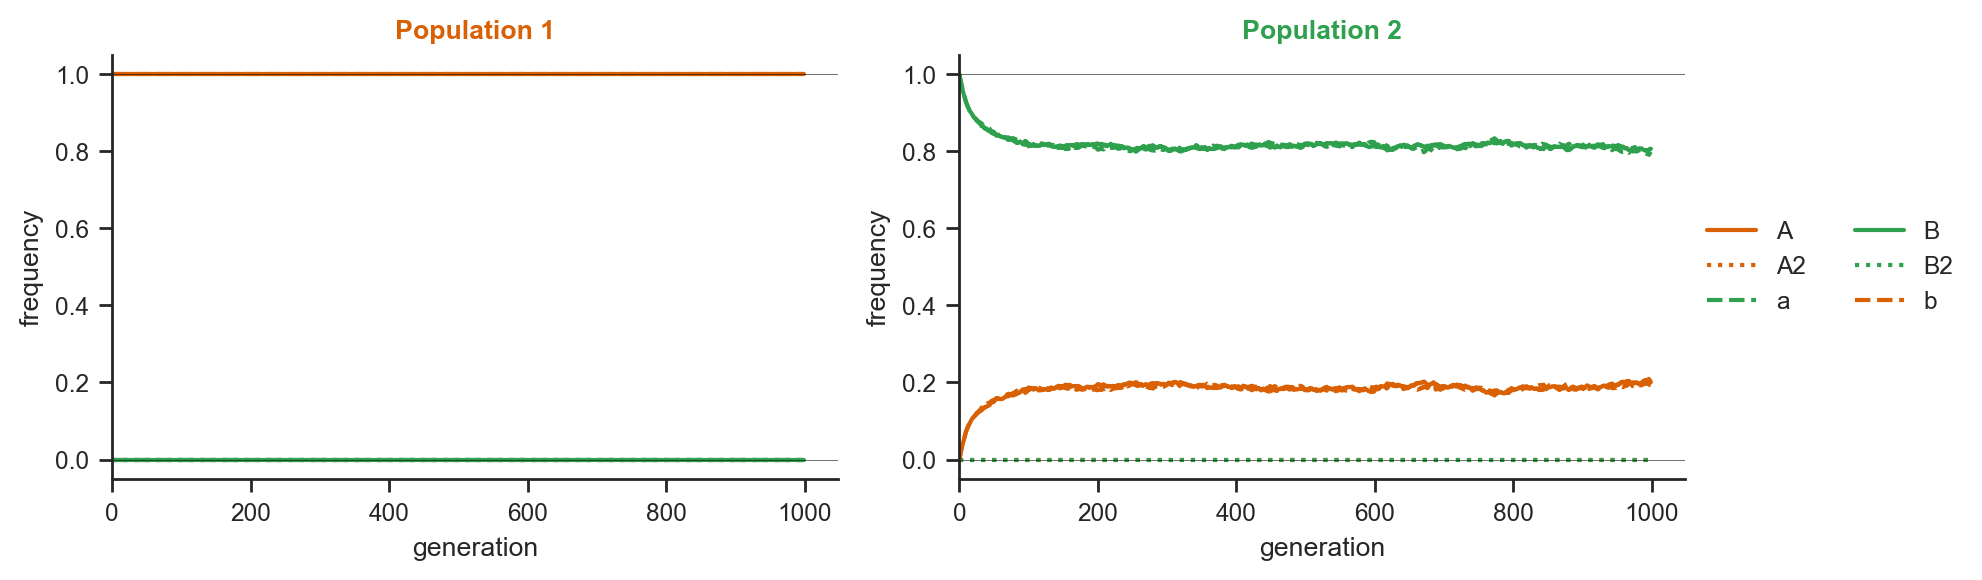

In [19]:
twolocus_twoallele_plot(
    compute_twolocus_twoallele_sample_data(generations=1000,
                                              N1=30000, N2=30000, 
                                              M1=0, M2=300,  
                                              init_pulse1=0, init_pulse2=0,
                                              A2_freq=0, B2_freq=0, 
                                              AB_bdmi_s=-0.11, ab_bdmi_s=-0.11,
                                              A_s=0, B_s=0,
                                              A2_s=0, B2_s=0, 
                                              a_s=0, b_s=0, 
                                              AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

---

Lowering migration rate below 1% produce same result:

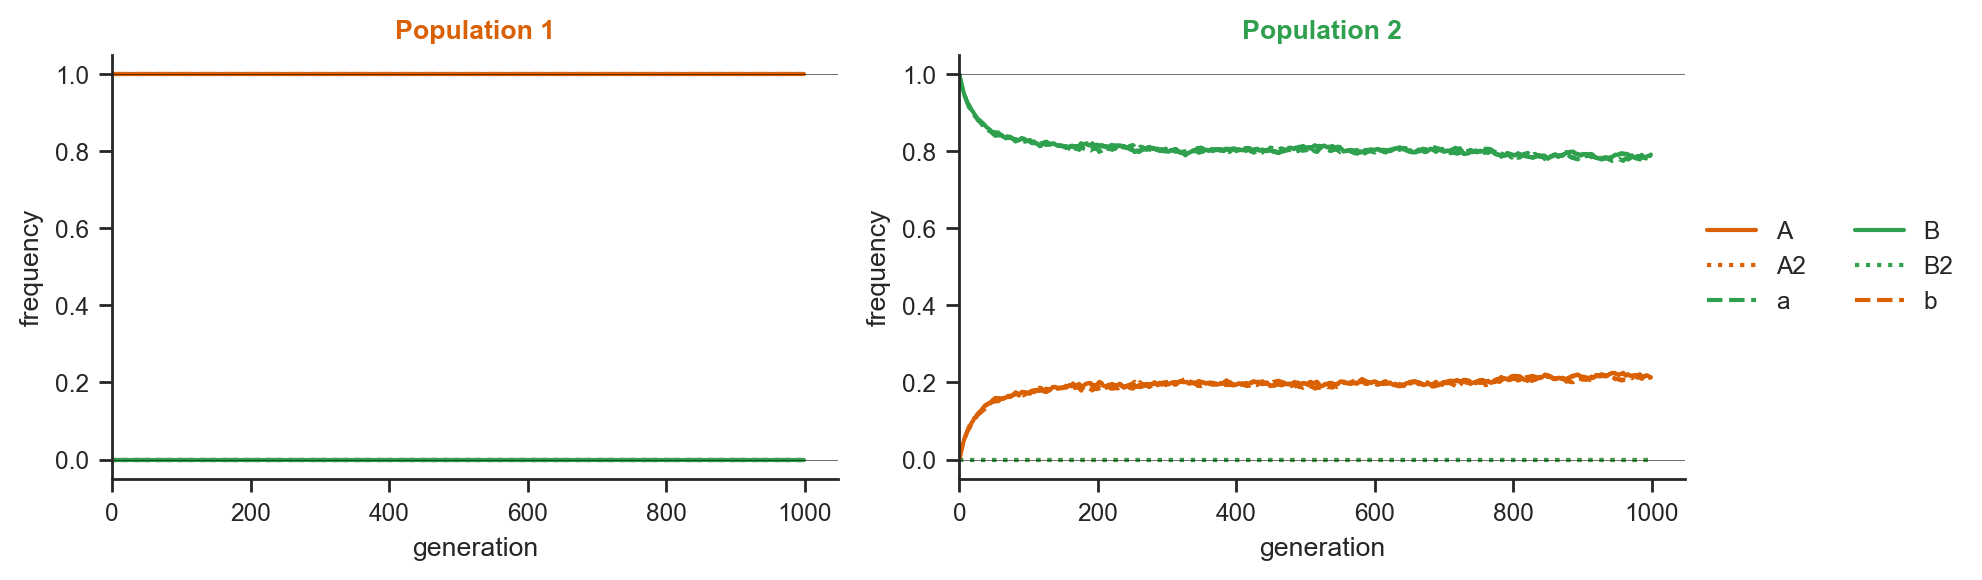

In [20]:
twolocus_twoallele_plot(
    compute_twolocus_twoallele_sample_data(generations=1000,
                                              N1=30000, N2=30000, 
                                              M1=0, M2=280,  
                                              init_pulse1=0, init_pulse2=0,
                                              A2_freq=0, B2_freq=0, 
                                              AB_bdmi_s=-0.1, ab_bdmi_s=-0.1,
                                              A_s=0, B_s=0,
                                              A2_s=0, B2_s=0, 
                                              a_s=0, b_s=0, 
                                              AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

---

So does adding 1/3 % migration in the other direction (reduces effective migration rate into population 2):

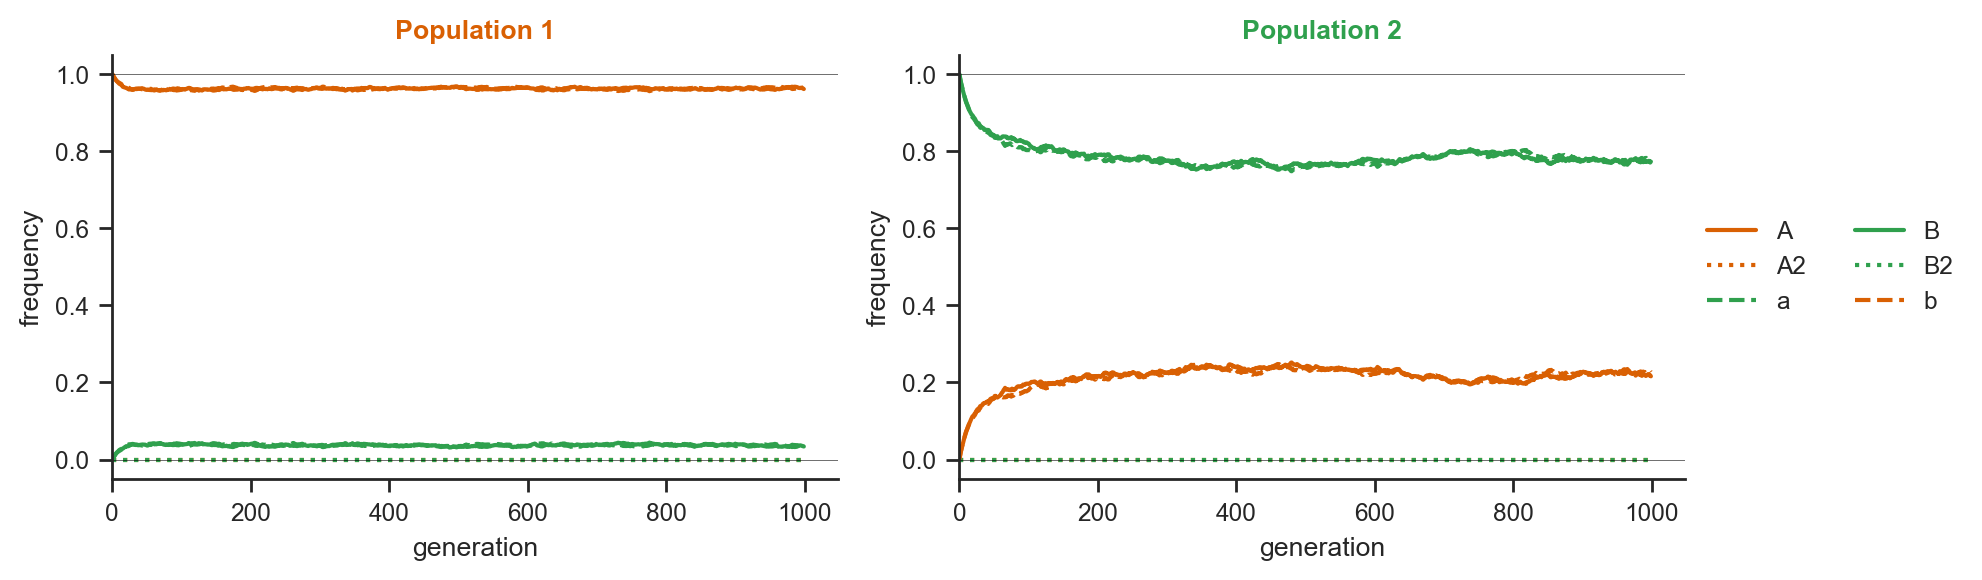

In [21]:
twolocus_twoallele_plot(
    compute_twolocus_twoallele_sample_data(generations=1000,
                                              N1=30000, N2=30000, 
                                              M1=100, M2=300,  
                                              init_pulse1=0, init_pulse2=0,
                                              A2_freq=0, B2_freq=0, 
                                              AB_bdmi_s=-0.1, ab_bdmi_s=-0.1,
                                              A_s=0, B_s=0,
                                              A2_s=0, B2_s=0, 
                                              a_s=0, b_s=0, 
                                              AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

---

## Conclusion

In this model with **1% unidirectional migration** and selection on **both AB and ab incompatibility**, selection coeficients **above/below 10%** determine major paraent ancestry in population 2.

---

## Lower negative bdmi seelection on ab:

If selection on ab genotypes is lowered, b alleles from population 1 will displace a and B in population 2, allowing A to fix.

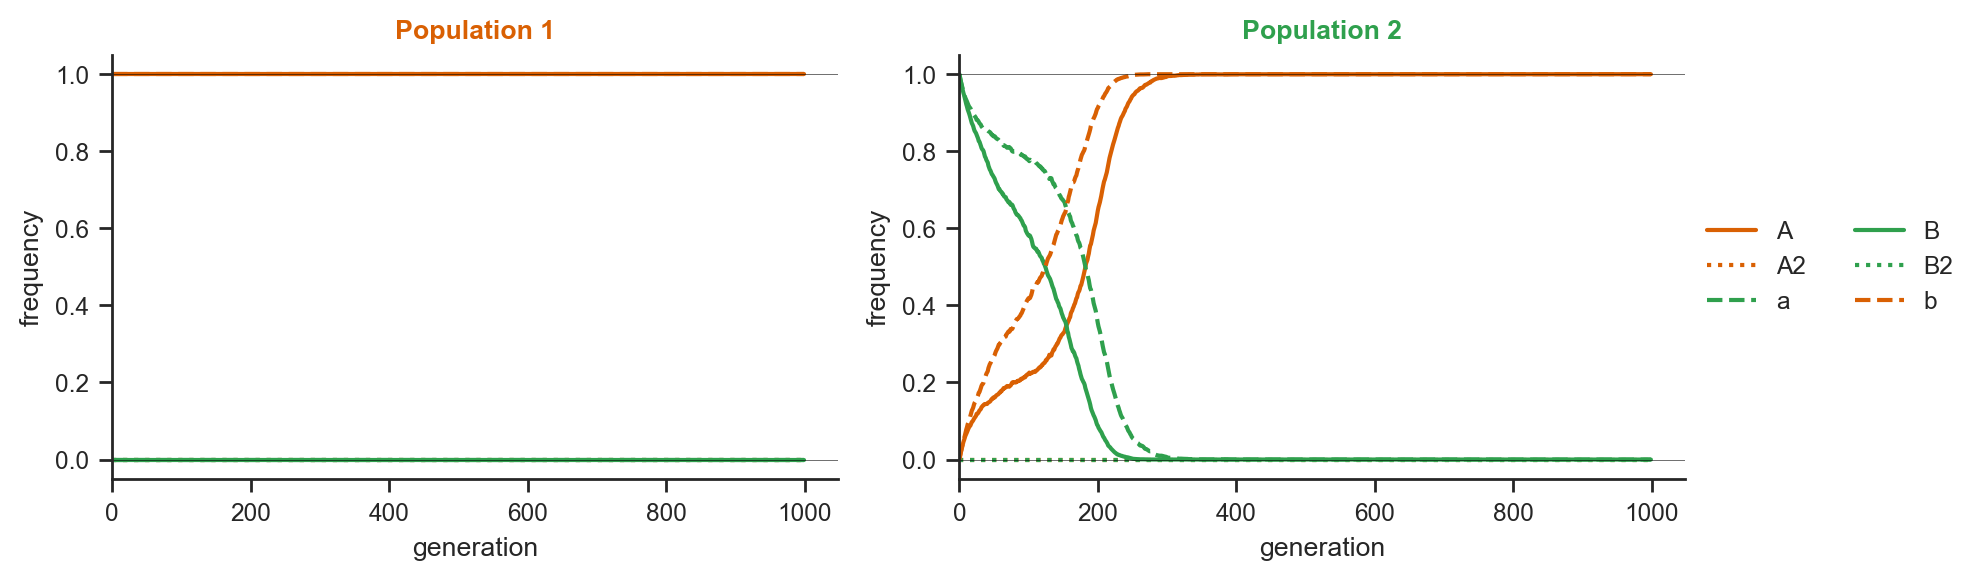

In [22]:
twolocus_twoallele_plot(
    compute_twolocus_twoallele_sample_data(generations=1000,
                                              N1=30000, N2=30000, 
                                              M1=0, M2=280,  
                                              init_pulse1=0, init_pulse2=0,
                                              A2_freq=0, B2_freq=0, 
                                              AB_bdmi_s=-0.1, ab_bdmi_s=-0.05,
                                              A_s=0, B_s=0,
                                              A2_s=0, B2_s=0, 
                                              a_s=0, b_s=0, 
                                              AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

## Funky scenarios...

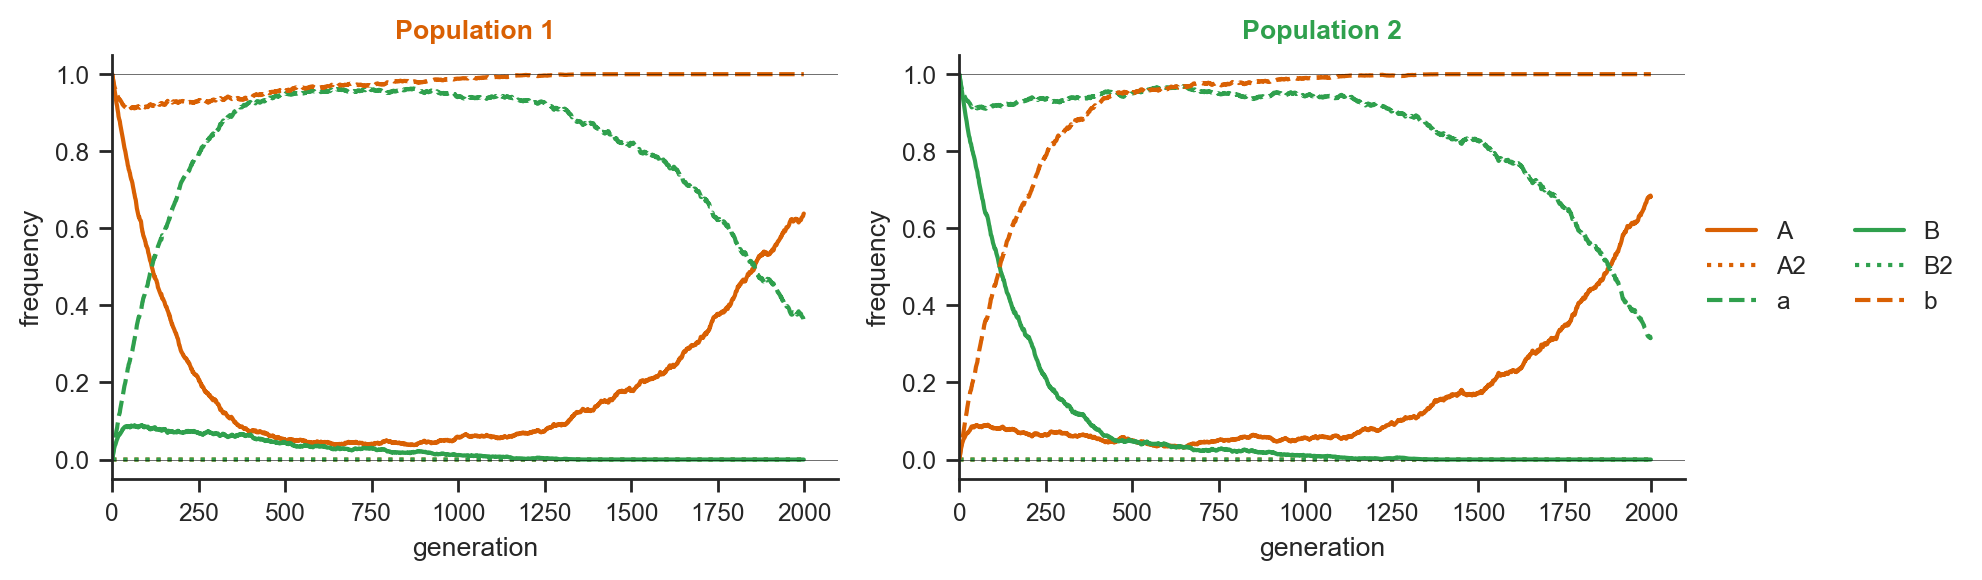

In [23]:
twolocus_twoallele_plot(
    compute_twolocus_twoallele_sample_data(generations=2000,
                                              N1=30000, N2=30000, 
                                              M1=200, M2=200,  
                                              init_pulse1=0, init_pulse2=0,
                                              A2_freq=0, B2_freq=0, 
                                              AB_bdmi_s=-0.1, ab_bdmi_s=-0.01,
                                              A_s=0, B_s=0,
                                              A2_s=0, B2_s=0, 
                                              a_s=0, b_s=0, 
                                              AB_bdmi_dom=0.5, A_dom=0.5, B_dom=0.5)) ;

## BDMI scenario to explain ECH observations

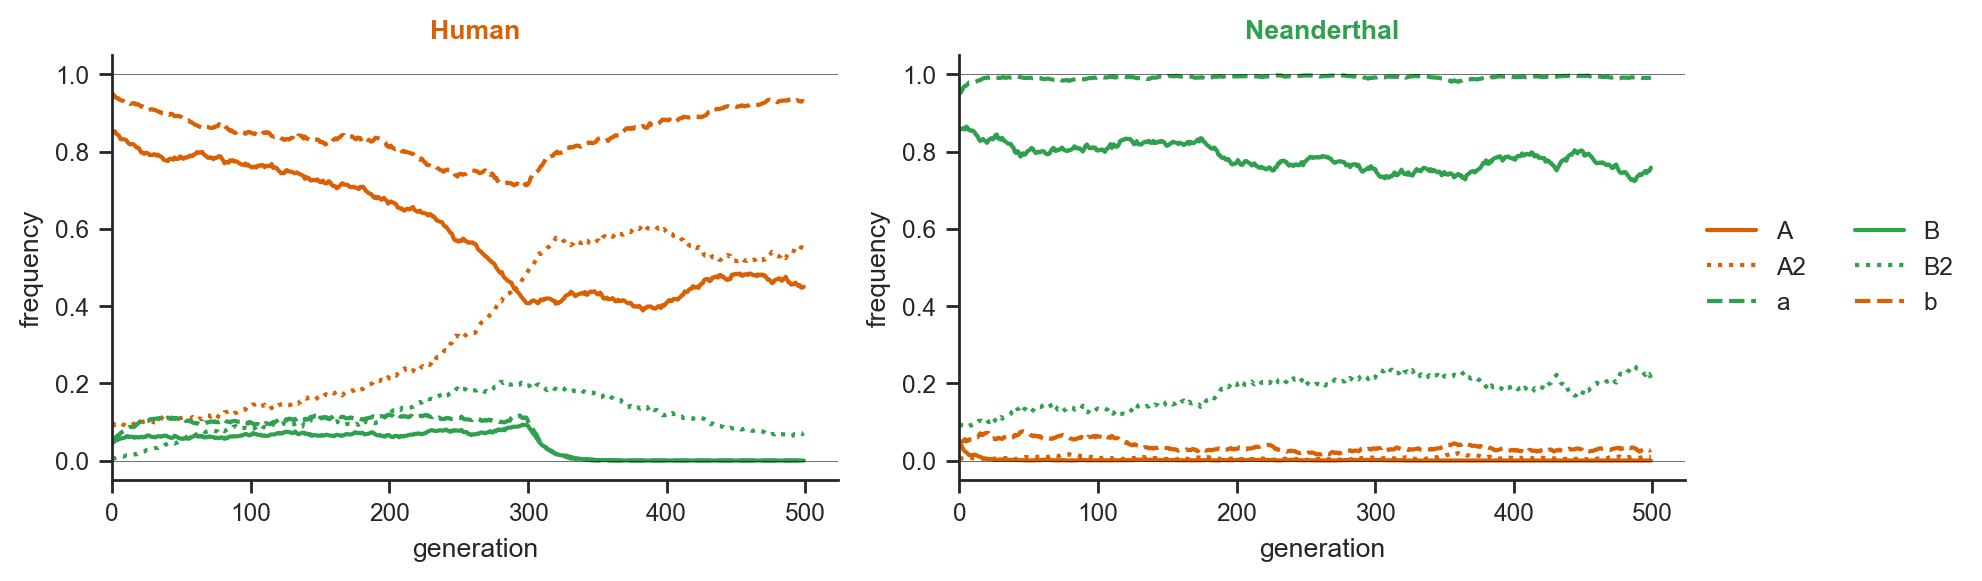

In [11]:
startmix = 0.05 # some fast initial admixture
data = compute_twolocus_twoallele_sample_data(N1=10000, N2=5000, 
                                              M1=100, M2=1,       # unidirectional migration ....
                                              generations=500, 
                                              startmix=startmix, 
                                              AB_bdmi_s=-0.2,    
                                              # ab_bdmi_s=-0.2,    
                                              a_s=-0.2,           # a incomp with *both* A, A2 and b (all human alleles)
                                              B_s=-0.01,          # some del mut load
                                              B2_s=-0.01,         # some del mut load
                                              A2_freq=0.1, 
                                              B2_freq=0.1,
                                              mig_interval=(0, 300)) # only 300 generations of admixture
twolocus_twoallele_plot(data, pop1='Human', pop2='Neanderthal') ;

# a_s determines background admixture level, which should be about 10%
# B_s determines the level B rises to once A is lost
# The frequency of B2 at the end corresponds to the background neanderthal level at the end of admixture, which should be about 10%

# TO MAKE IT WORK REQUIRES A LOT OF MIGRATION AND STRONG BDMI TO PRODUCE THE REQUIRED SELECTION ON A2

**Assumptions**

- Two loci with BDMI
- Alleles a and b are fixed in each population.

```
  Human       Neanderthal
  1   2         1   2
--A---b--     --a---B--      freq 0.9
--A2--b--     --a---B2--     freq 0.1
```

- Soft sweep of A2 occurs at locus 1
- Strong BDMI between alleles A and B
- Strongly assymetric migration from Neanderthals into humans (otherwise the Neanderthal source of B alleles into humans gets dilluted and ineffective)
- Some negative selection on B and B2 in addition from deleterious mutation load (otherwise the strong migration into humans produce more Neanderthal admixture than we observe)
- A2 needs to start at appreaciable frequency to have time to sweep in the limited span of time.
- Very strong negative selection on introgressing a alleles in the human population, more than what can be represented by ab_bdmi. with all human alleles at locus 2 (otherwise they will just rise in frequency along side A2). 


Largest problem is that neanderthals would need to supply 30000 migrants over 200 generations, when their pop size as at most 5000

# Old version with fixed alleles in each population

## Reproducing a BDMI plot like in Shumer et al

- Instant mixing (`startmix`) of populations with no subsequent migration
- It is assumed that there is no positive selection on A and B. I.e. the BDMI has developed neutrally.

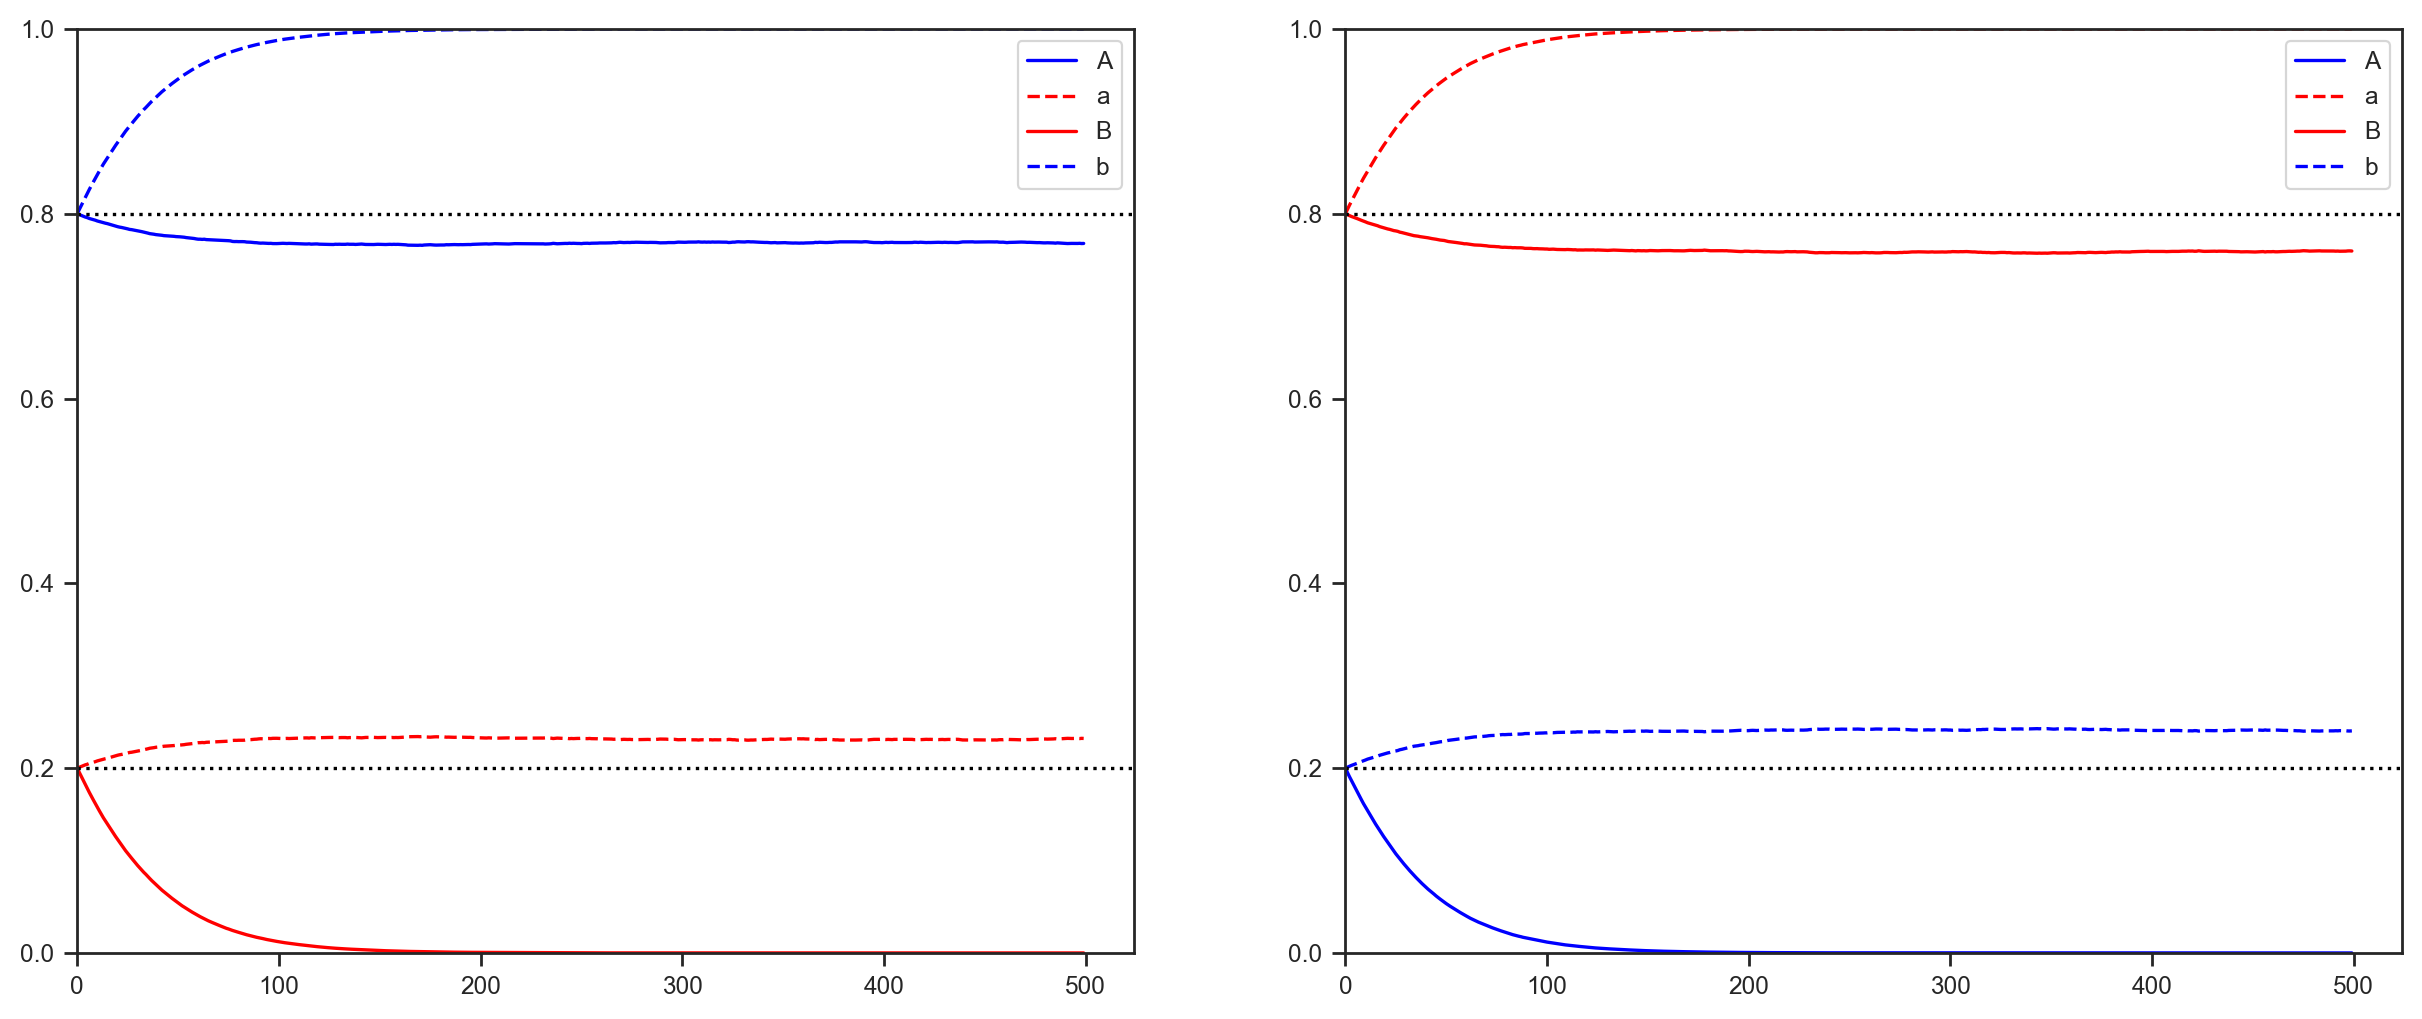

In [24]:
startmix = 0.2
data = compute_twolocus_sample_data(5000000, 0, 0.05, 500, startmix=startmix, bdmi=True, AB_dominance=0.5)
twolocus_plot()

## Adding positive selection on A and B

Even with a a bit of selection on A and B over a and b the positive correlation becomes negative very quickly:

In [25]:
startmix = 0.2
data = compute_twolocus_sample_data(5000000, 0, 0.02, 500, startmix=startmix, bdmi=True, pos_s=0.001)
plot()

NameError: name 'plot' is not defined

## No BDMI but with negative selection and migration

- Instant mixing of populations *and* subsequent migration
- No BDMI, only negative selection on B in pop1 and A in pop 2

Produces a positive correlation. So *with* migration, the correlation is can produced by ecological selection.

In [ ]:
startmix = 0.2
data = compute_twolocus_sample_data(5000000, 1000, 0.02, 500, startmix=startmix, bdmi=False)
plot()

This kind of assymetric negative selection (only selection on A and B in each population) eventually leads to loss of A and B.

In [ ]:
startmix = 0.2
data = compute_twolocus_sample_data(5000000, 1000, 0.02, 30000, startmix=startmix, bdmi=False)
plot()

## Neutral simulation with only migration

In [ ]:
startmix = 0.2
data = compute_twolocus_sample_data(5000000, 1000, 0.0, 30000, startmix=startmix, bdmi=False)
plot()

## Both BDMI and migration

- Both BDMI and subsequenct migration procudes a strong combined effect.

In [ ]:
startmix = 0.2
data = compute_twolocus_sample_data(5000000, 1000, 0.02, 500, startmix=startmix, bdmi=True)
plot()

If contributing, BDMI only contributes the correlation an extra boost right after the initial mix.

With only BDMI, the correlation does not increase after resolution of the incompatibility (after A or B are fixed). Maybe it is possible to get at this somehow?

## Compute the expected distribution of Spearman correlations

The distribution of spearman correlations dependes on both the number of samples, mean s and the distribution of s (here I use a gamma with shape 2):

In [ ]:
# Diploid population size:
N = 50000
# scale migration rate (1 ballances drift and migration):
M = 0
# additive selection coeficient for bdmi:
s = 0.02 
# generations to simulate:
generations = 1000
# start minor parent proportion:
startmix = 0.2
# wether to simulate bdmi (negative selection on A B combinations):
bdmi = True
# whether to sample selection coeficients from a gamma with mean s (shape 2 and scale s/2):
gamma_s = True
# positive selection coeficient on A in pop1 and B in pop2:
pos_s = 0
# number of two-locus samples used to compute each correlation:
samples = 100
# number of independent replications:
replications = 100

rerun = True
if rerun:
    pool = Pool(cpu_count())
    data = np.empty((replications, samples, generations, 2, 4))
    for r in trange(replications):
        for i, sample_data in enumerate(pool.starmap(compute_twolocus_sample_data, 
                                                     [(N, M, s, generations, startmix,
                                                       bdmi, pos_s, gamma_s)] * samples)):
            data[r][i] = sample_data        
    with open(f'data.npy', 'wb') as f:
        np.save(f, data)
else:
    with open(f'data.npy', 'rb') as f:
        data = np.load(f)

In [ ]:
import warnings
warnings.filterwarnings("error")

def spearman(a, b):
    import scipy
    try:
        return scipy.stats.spearmanr(a, b).correlation
    except scipy.stats.SpearmanRConstantInputWarning:
        return np.nan
    
spearman_vals = np.empty((replications, generations))
for r in trange(replications):
    
    a = np.transpose(data[r, :, :, 0, 3])
    b = np.transpose(data[r, :, :, 1, 3])
    
    spearman_vals[r] = pool.starmap(spearman, zip(a, b))

In [ ]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(18,7))
    for i in range(replications):
        plt.plot(spearman_vals[i], linewidth=0.1)
    plt.plot(np.array(spearman_vals).mean(0), color='black')
    plt.axhline(y=0, color='black', linestyle='dashed')

# Exploring if BDMI on X could allow a rare standing variant to go up in frequency becuase it is not incompatible with the Neandethal Y

# TODO: 

- implement incomp selection on the a b pair
- implement the pos_s on a and b
- Add a an optional third allele at each locus (A' and B') that segregates a ehaves like a and b but start at very low frequency

In [ ]:

def compute_twolocus_sample_data(N, M, s, g, startmix=(1, 1), bdmi=True, pos_s=(0, 0), gamma_s=False):
        
    if gamma_s:
        s = (gamma(2, s[0]/2, 1)[0], gamma(2, s[1]/2, 1)[0])
    
    m = (M[0] / N[0], M[1] / N[1])
    
    data = np.empty((g, 2, 4)) # gen, pop, alleles A, a, B, b (pops start out as AA bb, and aa BB, e.g. freq pop1: 1,1,0,0)
    
    data[0][0] = np.array([1-startmix[0], startmix[0], startmix[0], 1-startmix[0]])
    data[0][1] = np.array([startmix[1], 1-startmix[1], 1-startmix[1], startmix[1]])

    for g in range(1, g):
        # new generations
        for pop in range(2):

            f_A, f_a, f_B, f_b = data[g-1][pop]
            
            # construct genotypes
            locus1_genotypes = (f_A*f_A, 2*f_A*f_a, f_a*f_a)
            locus2_genotypes = (f_B*f_B, 2*f_B*f_b, f_b*f_b)
            
            # two locus genotypes
            genotypes = []
            for i in locus1_genotypes:
                row = []
                for j in locus2_genotypes:
                    row.append(i*j)
                genotypes.append(row)
            genotypes = np.array(genotypes)
            assert round(genotypes.sum(), 10) == 1, genotypes.sum()

            if bdmi:
                # selection against A B combinations (BDMI)
                sel = np.array([[1-2*s[0], 1-2*s[0], 1],
                                [1-2*s[0], 1-s[0], 1],
                                [1,   1,   1]])
            else:
                # just selection against B in pop 0 and A in pop 1 (ecological selection)
                if pop == 0:
                    sel = np.array([[1-2*s[0], 1-s[0], 1],
                                    [1-2*s[0], 1-s[0], 1],
                                    [1-2*s[0], 1-s[0], 1]])
                else:
                    sel = np.array([[1-2*s[0], 1-2*s[0], 1-2*s[0]],
                                    [1-s[0], 1-s[0], 1-s[0]],
                                    [1,   1,   1]])
            if any(pos_s):
                # positive selection on A and B
                a = np.array([1+2*pos_s[0], 1+pos_s[0], 1])
                if pop == 0:
                    sel = (sel.T * a).T
                else:
                    sel = sel * a

            genotypes_sampling_prob = genotypes * sel
            genotypes_sampling_prob /= genotypes_sampling_prob.sum()
            assert round(genotypes_sampling_prob.sum(), 10) == 1, genotypes_sampling_prob.sum()
            
            counts = np.random.multinomial(N[pop], genotypes_sampling_prob.flatten()).reshape((3, 3))

            f_A = counts[0, :].sum()*2 + counts[1, :].sum()
            f_a = counts[1, :].sum() + counts[2, :].sum()*2
            f_A, f_a = f_A / (f_A + f_a), f_a / (f_A + f_a)
            
            f_B = counts[:, 0].sum()*2 + counts[:, 1].sum()
            f_b = counts[:, 1].sum() + counts[:, 2].sum()*2
            f_B, f_b = f_B / (f_B + f_b), f_b / (f_B + f_b)

            new_freqs = np.array([f_A, f_a, f_B, f_b])
            assert round(new_freqs.sum(), 10) == 2, new_freqs
            data[g][pop] = new_freqs

        data[g][0], data[g][1] = (1-m[0])*data[g][0] + m[0]*data[g][1], (1-m[1])*data[g][1] + m[1]*data[g][0]

    return data


In [ ]:
def plot(labels=['A', 'a', 'B', 'b'], startmix=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.set_prop_cycle(color=['blue', 'red', 'red', 'blue'], linestyle=['solid', 'dashed', 'solid', 'dashed'])    
    for x, label in zip(data[:, 0, :].transpose(), labels):
        ax1.plot(x, label=label)
    ax1.legend()    
    ax2.set_prop_cycle(color=['blue', 'red', 'red', 'blue'], linestyle=['solid', 'dashed', 'solid', 'dashed'])    
    for x, label in zip(data[:, 1, :].transpose(), labels):
        ax2.plot(x, label=label)   
    ax2.legend() ;

    ax1.set_xlim(left=0)
    ax2.set_xlim(left=0)
    ax1.set_ylim((0, 1))
    ax2.set_ylim((0, 1))
    ax1.title.set_text('Population 1')
    ax2.title.set_text('Population 2')
    ax1.axhline(y=1-startmix[0], linestyle='dotted', color='black')
    ax1.axhline(y=startmix[0], linestyle='dotted', color='black')
    ax2.axhline(y=1-startmix[1], linestyle='dotted', color='black')
    ax2.axhline(y=startmix[1], linestyle='dotted', color='black') ;

In [ ]:
startmix = (0.2, 0.1)
data = compute_twolocus_sample_data(N=(100000, 100000), M=(0, 0), s=(0.01, 0.01), g=300, startmix=startmix, bdmi=True)
plot(['X', 'x', 'Y', 'y'], startmix)

With continued migration (influx of new Neanderthal Ys)

In [ ]:
startmix = 0.2
data = compute_twolocus_sample_data(100000, 1000, 0.01, 300, startmix=startmix, bdmi=True)
plot(['Hum X', 'Nean x', 'Nean Y', 'Hum y'])

The offending X an Y combinations are eventually removed. The Neanderthal allele compatible with the human Y eventually takes over the human population (and vice versa). This selection pressure would also propel a human X allele with the same properties as the Neanderthal X to the same high frequency...

Could that also explain invasions of X and Y from humans into neanderthals?... If the human Y is not inocmpatible with nean X but nean Nean Y is incompatible with human X?

If a rare human X variant (compatible with Neanderthal Y) would be selected on a background of incompatible X variants, then the neanderthal X variant would be selected too (because that is also compatible with the Neanderhal Y) - and we don't see that. However, it could be that the Neanderthal X is not selected because it is incompatbile with the Human Y.

    Human              Nean
    X    incomp with    Y 
    Y    incomp with    X
    X'  not incomp with Y


However, since we see that X' also displaces Denisovan admixture, it whould to also be compatible with Denisovan Y. Upon admixture with Denisovans (with more archaic incomp Ys mixing in) the X' should rise further in frequency, which we do not see. Further, any Denisovan segments that land on X' haplotypes at this point would not be displaced by selection on X'. Alternatively, X' could be from a seperate population in East Asia/Oceania (just like we think a a driver might), and then spread across Eurasia, displaceing both kinds of arhaic admixture just like we think a driver might. But in *that* case there would be no subsequent influx of more archaic Y's (requited to propel X' to high freqs). It would work just like BDMI with a single pulse of admixture, and X' would only rise modestly in frequency before the resident archaic Y's had been removed.

For the model to work in Human -> Neanderthal introgression it would not only require that Human Y is not incompatible with Neanderthal X. It would also require positive selection on Human Y (if it did not fix by chance). 